<h1>Sommaire<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Previously" data-toc-modified-id="Previously-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Previously</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Useful-functions" data-toc-modified-id="Useful-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Useful functions</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Train-set-&amp;-test-set" data-toc-modified-id="Train-set-&amp;-test-set-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Train set &amp; test set</a></span></li></ul></li><li><span><a href="#SGD-Classifier" data-toc-modified-id="SGD-Classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SGD Classifier</a></span><ul class="toc-item"><li><span><a href="#Previous-results" data-toc-modified-id="Previous-results-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Previous results</a></span><ul class="toc-item"><li><span><a href="#GridSearch-CV" data-toc-modified-id="GridSearch-CV-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>GridSearch CV</a></span></li><li><span><a href="#Model-scores" data-toc-modified-id="Model-scores-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Model scores</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Hyperparameters-optimization" data-toc-modified-id="Hyperparameters-optimization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Hyperparameters optimization</a></span><ul class="toc-item"><li><span><a href="#Previous-best-model" data-toc-modified-id="Previous-best-model-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Previous best model</a></span></li><li><span><a href="#GridSearchCV" data-toc-modified-id="GridSearchCV-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>GridSearchCV</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li></ul></li></ul></div>

## Introduction

In this notebook, development of machine learning classification models will be reported

### Previously

EDA was performed from a Kaggle kernel
Pre-processing was performed from a Kaggle kernel
The best model was selected after some tests in the previous notebook (machine_learning)

### Imports

In [23]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
#import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, auc, precision_score, recall_score, f1_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from sklearn.model_selection import train_test_split, GridSearchCV

# Imb-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

#SGD Classifier
from sklearn.linear_model import SGDClassifier

### Settings

In [10]:
%config IPCompleter.greedy=True #Auto-completion
sns.set(style='white')
pd.options.display.max_colwidth = 90  # set column width to see all of it
pd.set_option('display.max_columns', 50) # display max. 50 columns
pd.set_option('display.max_rows', 100)  # display max. 100 rows

# Random State
random_state = 77

### Useful functions

In [9]:
def make_model(clf):
    model = Pipeline([
            ('scaler', StandardScaler()),
            ('sampling', SMOTE(random_state=random_state, k_neighbors=3)),
            ('classification', clf)
        ])
    return model

In [5]:
def clf_results(clf_name, clf, X, y, X_train, y_train, X_test, y_test):
    
    """
    This function displays all results from a trained classification model
    Inputs : 
    - clf_name : str, name of the model
    - clf : model trained
    - X, y : data and target (dataframe or array)
    - X_train, y_train, X_test, y_test : data and target after train_test_split (dataframe or array)
    
    Outputs : 
    - train score
    - test score
    - classification report
    - confusion matrix
    - ROC AUC score
    - ROC curve
    """
    
    #Train score vs test score
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    # ROC AUC score 
    y_score_train = clf.predict_proba(X_train)[:, 1]
    roc_train = roc_auc_score(y_train, y_score_train)
    y_score_test = clf.predict_proba(X_test)[:, 1]
    roc_test = roc_auc_score(y_test, y_score_test)
    
    #Make prediction
    y_pred = clf.predict(X)
                           
    #Report
    print('Model:', clf)
    print('Train score:', train_score) 
    print('Test_score:', test_score)
    print('ROC AUC train score:', roc_train)
    print('ROC AUC test score:', roc_test)
    print(classification_report(y_true=y, y_pred=y_pred))
    print('Confusion matrix\n', confusion_matrix(y_true=y, y_pred=y_pred))

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name=clf_name)
    display.plot()
    plt.title('ROC curve')
    plt.show()
    
    

In [36]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_mat_visu(clf, X, y):
    """
    This function displays the confusion matrix. Adapted from ConfusionMatrixDisplay()
    """
    predictions = clf.predict(X)
    cm = confusion_matrix(y, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
    disp.plot()
    plt.title('Matrice de confusion')
    plt.show()

    

In [ ]:
# from sklearn.metrics import confusion_matrix

def custom_metric(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = mat.ravel()

    return ta_combinaison

In [ ]:
def mycosts(p_y_test, p_y_pred):

    # x = n et p
    tx, fx = confusion_matrix(p_y_test, p_y_pred).ravel() 

    # mon calcul 
    value = xxxxxxxxxxxxx avec tx et fx

    # value est une valeur numerique
    return  value

myscorer = make_scorer(mycosts)


et ensuite  myscorer  est passé en parametre  à un CV ->  scoring = myscorer 


Ma démarche a été la suivante : une société de crédit est une société "à but lucratif". J'ai donc supposé qu'elle cherche à optimiser ses revenus. J'ai ensuite associé à chacune des quatre situations possibles (FP, TP, FN, TN) une "valeur" (gain ou coût pour l'entreprise). En l'occurrence, j'ai considéré : TP_value = FP_value = 0 ; TN_value = 1 et FN_value = -10. Ce sont des valeurs arbitraires qui devraient être revues par l'entreprise en fonction de la "réalité métier" (cela revient à fixer le lambda de tes métriques). À partir de cela, j'ai construit le gain (fonction d'utilité si tu préfère) de l'entreprise. Et j'ai normalisé pour obtenir une valeur entre 0 (modèle naïf qui prédit la classe non-défaut à tous) et 1 (modèle parfait qui prédit les vrais classes). Cela me donne donc une "métrique métier", qui peut facilement être paramétrisée avec TN_value  et FN_value.


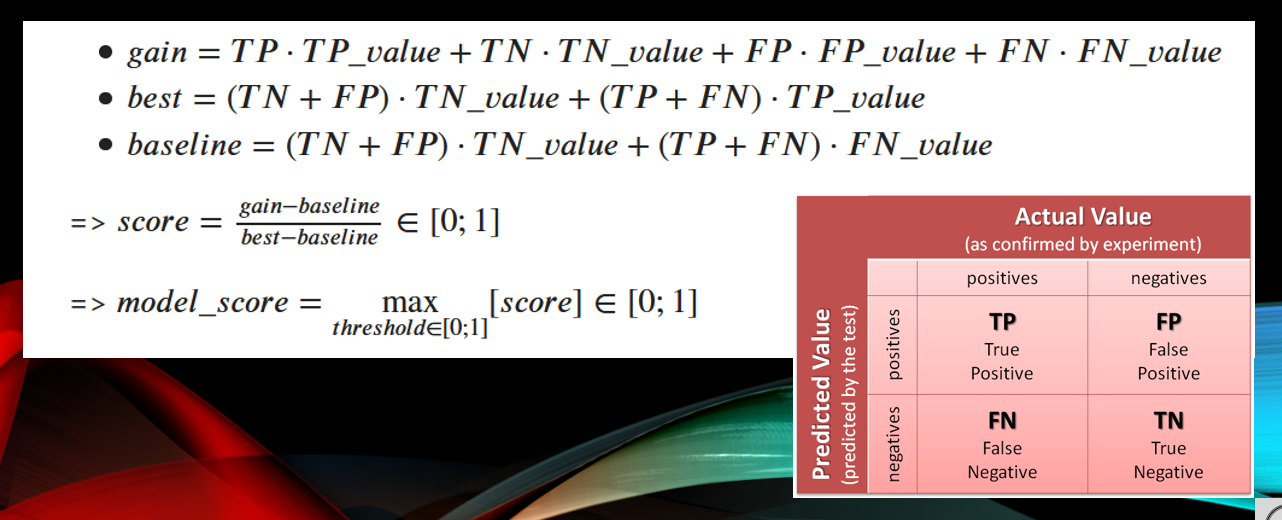

### Read data

In [7]:
data = pd.read_csv('p7_clean_dataset_for_ml.csv')

X = data.drop(columns=['TARGET'])
y = data['TARGET']

print("X dimensions : ", X.shape)
print("y dimensions : ", y.shape)

X dimensions :  (356251, 644)
y dimensions :  (356251,)


### Train set & test set

In [8]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=77)

## SGD Classifier

### Previous results

Dataset splitted in train set and test set
Train set: (285000, 644) (285000,)
Test set: (71251, 644) (71251,)
Resampling with SMOTE done
Classification model trained
Model: SGDClassifier(loss='log_loss', random_state=77)
Train score: 0.7413923129423565
Test_score: 0.7273582125163156
ROC AUC train score: 0.8146142252918551
ROC AUC test score: 0.7576621390923459
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83    331426
         1.0       0.15      0.65      0.25     24825

    accuracy                           0.72    356251
   macro avg       0.56      0.69      0.54    356251
weighted avg       0.91      0.72      0.79    356251

[[242117  89309]
 [  8667  16158]]


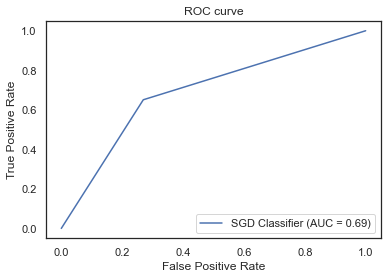

In [38]:
# from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log_loss', random_state=77)  # Default : loss = 'hinge' i.e. using linear svm
classifier_quick_evaluation(clf, 'SGD Classifier', X, y)

In [8]:
#from sklearn.linear_model import SGDClassifier
random_state = 77
clf = SGDClassifier(loss='log_loss', random_state=random_state, verbose=1)
model = make_model(clf)
model

Pipeline(steps=[('sampling', SMOTE(random_state=77)),
                ('classification',
                 SGDClassifier(loss='log_loss', random_state=77, verbose=1))])

In [9]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sampling', 'classification', 'sampling__k_neighbors', 'sampling__n_jobs', 'sampling__random_state', 'sampling__sampling_strategy', 'classification__alpha', 'classification__average', 'classification__class_weight', 'classification__early_stopping', 'classification__epsilon', 'classification__eta0', 'classification__fit_intercept', 'classification__l1_ratio', 'classification__learning_rate', 'classification__loss', 'classification__max_iter', 'classification__n_iter_no_change', 'classification__n_jobs', 'classification__penalty', 'classification__power_t', 'classification__random_state', 'classification__shuffle', 'classification__tol', 'classification__validation_fraction', 'classification__verbose', 'classification__warm_start'])

#### GridSearch CV

In [12]:
param_grid = {
    'sampling__k_neighbors' : [3, 5, 7] ,
    'classification__alpha' : [0.0001, 0.0005 , 0.001] ,
    'classification__penalty': ['l1', 'l2'],
    'classification__loss' : ['hinge', 'log_loss']
}

In [ ]:
grid = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
-- Epoch 1
Norm: 1849.33, NNZs: 239, Bias: -13.358525, T: 424318, Avg. loss: 19.889644
Total training time: 3.51 seconds.
-- Epoch 2
Norm: 1838.11, NNZs: 238, Bias: -12.698730, T: 848636, Avg. loss: 5.259014
Total training time: 7.32 seconds.
-- Epoch 3
Norm: 1830.66, NNZs: 252, Bias: -12.489883, T: 1272954, Avg. loss: 4.831378
Total training time: 10.96 seconds.
-- Epoch 4
Norm: 1825.43, NNZs: 279, Bias: -12.873798, T: 1697272, Avg. loss: 4.648084
Total training time: 14.58 seconds.
-- Epoch 5
Norm: 1821.36, NNZs: 280, Bias: -12.784457, T: 2121590, Avg. loss: 4.522672
Total training time: 18.16 seconds.
-- Epoch 6
Norm: 1817.94, NNZs: 283, Bias: -12.908902, T: 2545908, Avg. loss: 4.427871
Total training time: 21.79 seconds.
-- Epoch 7
Norm: 1815.05, NNZs: 287, Bias: -12.890719, T: 2970226, Avg. loss: 4.357551
Total training time: 25.39 seconds.
-- Epoch 8
Norm: 1812.59, NNZs: 283, Bias: -12.934178, T: 3394544, Avg. loss: 4.

Norm: 1775.06, NNZs: 378, Bias: -13.530123, T: 28004988, Avg. loss: 3.626584
Total training time: 221.20 seconds.
-- Epoch 67
Norm: 1774.81, NNZs: 398, Bias: -13.528955, T: 28429306, Avg. loss: 3.623787
Total training time: 224.37 seconds.
-- Epoch 68
Norm: 1774.56, NNZs: 385, Bias: -13.502914, T: 28853624, Avg. loss: 3.620875
Total training time: 227.46 seconds.
-- Epoch 69
Norm: 1774.31, NNZs: 419, Bias: -13.510763, T: 29277942, Avg. loss: 3.618426
Total training time: 230.58 seconds.
-- Epoch 70
Norm: 1774.07, NNZs: 407, Bias: -13.536621, T: 29702260, Avg. loss: 3.615644
Total training time: 233.67 seconds.
-- Epoch 71
Norm: 1773.83, NNZs: 400, Bias: -13.549149, T: 30126578, Avg. loss: 3.612886
Total training time: 236.72 seconds.
-- Epoch 72
Norm: 1773.59, NNZs: 383, Bias: -13.544007, T: 30550896, Avg. loss: 3.610191
Total training time: 239.79 seconds.
-- Epoch 73
Norm: 1773.36, NNZs: 401, Bias: -13.528375, T: 30975214, Avg. loss: 3.606946
Total training time: 242.91 seconds.
-- E

Norm: 1763.65, NNZs: 427, Bias: -13.617179, T: 55585658, Avg. loss: 3.496562
Total training time: 419.12 seconds.
-- Epoch 132
Norm: 1763.52, NNZs: 432, Bias: -13.595755, T: 56009976, Avg. loss: 3.495449
Total training time: 422.02 seconds.
-- Epoch 133
Norm: 1763.40, NNZs: 433, Bias: -13.619456, T: 56434294, Avg. loss: 3.493721
Total training time: 424.95 seconds.
-- Epoch 134
Norm: 1763.28, NNZs: 418, Bias: -13.630691, T: 56858612, Avg. loss: 3.492513
Total training time: 427.86 seconds.
-- Epoch 135
Norm: 1763.15, NNZs: 426, Bias: -13.599357, T: 57282930, Avg. loss: 3.491140
Total training time: 430.78 seconds.
-- Epoch 136
Norm: 1763.03, NNZs: 427, Bias: -13.615783, T: 57707248, Avg. loss: 3.489718
Total training time: 433.71 seconds.
-- Epoch 137
Norm: 1762.91, NNZs: 414, Bias: -13.648491, T: 58131566, Avg. loss: 3.488239
Total training time: 436.64 seconds.
-- Epoch 138
Norm: 1762.80, NNZs: 427, Bias: -13.614333, T: 58555884, Avg. loss: 3.487120
Total training time: 439.57 second

Norm: 1757.11, NNZs: 437, Bias: -13.676402, T: 83166328, Avg. loss: 3.422073
Total training time: 610.35 seconds.
-- Epoch 197
Norm: 1757.03, NNZs: 442, Bias: -13.659757, T: 83590646, Avg. loss: 3.421230
Total training time: 613.21 seconds.
-- Epoch 198
Norm: 1756.95, NNZs: 439, Bias: -13.680531, T: 84014964, Avg. loss: 3.420046
Total training time: 616.09 seconds.
-- Epoch 199
Norm: 1756.87, NNZs: 442, Bias: -13.676361, T: 84439282, Avg. loss: 3.419304
Total training time: 618.99 seconds.
-- Epoch 200
Norm: 1756.79, NNZs: 441, Bias: -13.662928, T: 84863600, Avg. loss: 3.418199
Total training time: 621.89 seconds.
-- Epoch 201
Norm: 1756.71, NNZs: 437, Bias: -13.674604, T: 85287918, Avg. loss: 3.417601
Total training time: 624.78 seconds.
-- Epoch 202
Norm: 1756.63, NNZs: 444, Bias: -13.676256, T: 85712236, Avg. loss: 3.416394
Total training time: 627.66 seconds.
-- Epoch 203
Norm: 1756.55, NNZs: 436, Bias: -13.671857, T: 86136554, Avg. loss: 3.415617
Total training time: 630.56 second

Norm: 1606.56, NNZs: 369, Bias: -14.577533, T: 14851130, Avg. loss: 1.461681
Total training time: 123.02 seconds.
-- Epoch 36
Norm: 1606.42, NNZs: 367, Bias: -14.593338, T: 15275448, Avg. loss: 1.449158
Total training time: 126.30 seconds.
-- Epoch 37
Norm: 1606.29, NNZs: 362, Bias: -14.582877, T: 15699766, Avg. loss: 1.437880
Total training time: 129.51 seconds.
-- Epoch 38
Norm: 1606.17, NNZs: 385, Bias: -14.539889, T: 16124084, Avg. loss: 1.425717
Total training time: 132.78 seconds.
-- Epoch 39
Norm: 1606.04, NNZs: 364, Bias: -14.488830, T: 16548402, Avg. loss: 1.415234
Total training time: 136.02 seconds.
-- Epoch 40
Norm: 1605.93, NNZs: 364, Bias: -14.499219, T: 16972720, Avg. loss: 1.403729
Total training time: 139.24 seconds.
-- Epoch 41
Norm: 1605.81, NNZs: 368, Bias: -14.464119, T: 17397038, Avg. loss: 1.393035
Total training time: 142.52 seconds.
-- Epoch 42
Norm: 1605.70, NNZs: 387, Bias: -14.457138, T: 17821356, Avg. loss: 1.382842
Total training time: 145.76 seconds.
-- E

Norm: 1602.59, NNZs: 425, Bias: -13.713379, T: 42856118, Avg. loss: 1.074190
Total training time: 330.80 seconds.
-- Epoch 102
Norm: 1602.56, NNZs: 421, Bias: -13.707295, T: 43280436, Avg. loss: 1.074097
Total training time: 333.81 seconds.
-- Epoch 103
Norm: 1602.53, NNZs: 422, Bias: -13.692603, T: 43704754, Avg. loss: 1.073276
Total training time: 336.82 seconds.
-- Epoch 104
Norm: 1602.51, NNZs: 416, Bias: -13.707888, T: 44129072, Avg. loss: 1.072698
Total training time: 339.81 seconds.
Convergence after 104 epochs took 339.81 seconds
-- Epoch 1
Norm: 953.91, NNZs: 238, Bias: -16.093703, T: 424318, Avg. loss: 17.290955
Total training time: 3.29 seconds.
-- Epoch 2
Norm: 953.31, NNZs: 234, Bias: -15.065841, T: 848636, Avg. loss: 2.376582
Total training time: 6.82 seconds.
-- Epoch 3
Norm: 951.85, NNZs: 243, Bias: -14.484592, T: 1272954, Avg. loss: 1.938258
Total training time: 10.52 seconds.
-- Epoch 4
Norm: 950.40, NNZs: 246, Bias: -13.922566, T: 1697272, Avg. loss: 1.829609
Total t

Norm: 928.76, NNZs: 389, Bias: -9.801240, T: 26732034, Avg. loss: 1.363918
Total training time: 210.08 seconds.
-- Epoch 64
Norm: 928.63, NNZs: 393, Bias: -9.767308, T: 27156352, Avg. loss: 1.362539
Total training time: 213.24 seconds.
-- Epoch 65
Norm: 928.51, NNZs: 392, Bias: -9.715618, T: 27580670, Avg. loss: 1.360310
Total training time: 216.36 seconds.
-- Epoch 66
Norm: 928.39, NNZs: 383, Bias: -9.713306, T: 28004988, Avg. loss: 1.358809
Total training time: 219.49 seconds.
-- Epoch 67
Norm: 928.28, NNZs: 390, Bias: -9.689640, T: 28429306, Avg. loss: 1.356961
Total training time: 222.81 seconds.
-- Epoch 68
Norm: 928.16, NNZs: 381, Bias: -9.655988, T: 28853624, Avg. loss: 1.355134
Total training time: 225.96 seconds.
-- Epoch 69
Norm: 928.05, NNZs: 399, Bias: -9.668798, T: 29277942, Avg. loss: 1.353880
Total training time: 229.03 seconds.
-- Epoch 70
Norm: 927.93, NNZs: 392, Bias: -9.657007, T: 29702260, Avg. loss: 1.352588
Total training time: 232.10 seconds.
-- Epoch 71
Norm: 92

-- Epoch 1
Norm: 1621.89, NNZs: 258, Bias: -20.012414, T: 424318, Avg. loss: 17.818531
Total training time: 3.46 seconds.
-- Epoch 2
Norm: 1621.55, NNZs: 251, Bias: -18.648582, T: 848636, Avg. loss: 2.307334
Total training time: 6.93 seconds.
-- Epoch 3
Norm: 1621.09, NNZs: 252, Bias: -18.424974, T: 1272954, Avg. loss: 1.762609
Total training time: 10.45 seconds.
-- Epoch 4
Norm: 1620.61, NNZs: 255, Bias: -18.082974, T: 1697272, Avg. loss: 1.610339
Total training time: 14.01 seconds.
-- Epoch 5
Norm: 1620.12, NNZs: 276, Bias: -17.829963, T: 2121590, Avg. loss: 1.524718
Total training time: 17.56 seconds.
-- Epoch 6
Norm: 1619.65, NNZs: 276, Bias: -17.560217, T: 2545908, Avg. loss: 1.469283
Total training time: 21.07 seconds.
-- Epoch 7
Norm: 1619.23, NNZs: 292, Bias: -17.376727, T: 2970226, Avg. loss: 1.430595
Total training time: 24.58 seconds.
-- Epoch 8
Norm: 1618.85, NNZs: 290, Bias: -17.301222, T: 3394544, Avg. loss: 1.398444
Total training time: 28.11 seconds.
-- Epoch 9
Norm: 16

Norm: 1612.08, NNZs: 393, Bias: -15.579753, T: 28429306, Avg. loss: 1.129112
Total training time: 1714.65 seconds.
-- Epoch 68
Norm: 1612.04, NNZs: 394, Bias: -15.555871, T: 28853624, Avg. loss: 1.127669
Total training time: 1716.07 seconds.
-- Epoch 69
Norm: 1611.99, NNZs: 385, Bias: -15.567381, T: 29277942, Avg. loss: 1.126583
Total training time: 1717.48 seconds.
-- Epoch 70
Norm: 1611.94, NNZs: 388, Bias: -15.585823, T: 29702260, Avg. loss: 1.125399
Total training time: 1718.88 seconds.
-- Epoch 71
Norm: 1611.90, NNZs: 397, Bias: -15.567467, T: 30126578, Avg. loss: 1.124533
Total training time: 1720.27 seconds.
-- Epoch 72
Norm: 1611.86, NNZs: 397, Bias: -15.546855, T: 30550896, Avg. loss: 1.123657
Total training time: 1721.65 seconds.
-- Epoch 73
Norm: 1611.81, NNZs: 389, Bias: -15.550878, T: 30975214, Avg. loss: 1.122560
Total training time: 1723.03 seconds.
-- Epoch 74
Norm: 1611.77, NNZs: 389, Bias: -15.511053, T: 31399532, Avg. loss: 1.121517
Total training time: 1724.41 secon

Norm: 1213.03, NNZs: 367, Bias: -16.783076, T: 14426880, Avg. loss: 1.849464
Total training time: 112.83 seconds.
-- Epoch 35
Norm: 1212.74, NNZs: 370, Bias: -16.714181, T: 14851200, Avg. loss: 1.843188
Total training time: 115.96 seconds.
-- Epoch 36
Norm: 1212.45, NNZs: 363, Bias: -16.720150, T: 15275520, Avg. loss: 1.837855
Total training time: 119.09 seconds.
-- Epoch 37
Norm: 1212.18, NNZs: 369, Bias: -16.659379, T: 15699840, Avg. loss: 1.832271
Total training time: 122.25 seconds.
-- Epoch 38
Norm: 1211.91, NNZs: 379, Bias: -16.696307, T: 16124160, Avg. loss: 1.826908
Total training time: 125.36 seconds.
-- Epoch 39
Norm: 1211.65, NNZs: 365, Bias: -16.653297, T: 16548480, Avg. loss: 1.821339
Total training time: 128.49 seconds.
-- Epoch 40
Norm: 1211.40, NNZs: 384, Bias: -16.601627, T: 16972800, Avg. loss: 1.816176
Total training time: 131.61 seconds.
-- Epoch 41
Norm: 1211.16, NNZs: 368, Bias: -16.592575, T: 17397120, Avg. loss: 1.811106
Total training time: 134.99 seconds.
-- E

Norm: 1202.84, NNZs: 416, Bias: -15.515070, T: 42432000, Avg. loss: 1.641668
Total training time: 313.12 seconds.
-- Epoch 101
Norm: 1202.75, NNZs: 416, Bias: -15.549195, T: 42856320, Avg. loss: 1.640341
Total training time: 316.12 seconds.
-- Epoch 102
Norm: 1202.67, NNZs: 417, Bias: -15.538448, T: 43280640, Avg. loss: 1.638209
Total training time: 319.08 seconds.
-- Epoch 103
Norm: 1202.58, NNZs: 411, Bias: -15.531950, T: 43704960, Avg. loss: 1.636649
Total training time: 322.15 seconds.
-- Epoch 104
Norm: 1202.50, NNZs: 418, Bias: -15.520011, T: 44129280, Avg. loss: 1.635007
Total training time: 325.12 seconds.
-- Epoch 105
Norm: 1202.42, NNZs: 416, Bias: -15.498582, T: 44553600, Avg. loss: 1.633309
Total training time: 328.05 seconds.
-- Epoch 106
Norm: 1202.33, NNZs: 417, Bias: -15.483893, T: 44977920, Avg. loss: 1.631702
Total training time: 331.04 seconds.
-- Epoch 107
Norm: 1202.25, NNZs: 419, Bias: -15.463448, T: 45402240, Avg. loss: 1.630137
Total training time: 334.00 second

Norm: 1198.62, NNZs: 427, Bias: -15.059805, T: 70012800, Avg. loss: 1.558929
Total training time: 504.51 seconds.
-- Epoch 166
Norm: 1198.57, NNZs: 438, Bias: -15.035707, T: 70437120, Avg. loss: 1.558204
Total training time: 507.68 seconds.
-- Epoch 167
Norm: 1198.52, NNZs: 427, Bias: -15.041214, T: 70861440, Avg. loss: 1.557188
Total training time: 510.85 seconds.
-- Epoch 168
Norm: 1198.48, NNZs: 423, Bias: -15.019959, T: 71285760, Avg. loss: 1.556223
Total training time: 513.95 seconds.
-- Epoch 169
Norm: 1198.43, NNZs: 430, Bias: -15.032817, T: 71710080, Avg. loss: 1.555404
Total training time: 517.04 seconds.
-- Epoch 170
Norm: 1198.38, NNZs: 428, Bias: -15.004458, T: 72134400, Avg. loss: 1.554563
Total training time: 519.93 seconds.
-- Epoch 171
Norm: 1198.33, NNZs: 432, Bias: -15.031643, T: 72558720, Avg. loss: 1.553445
Total training time: 522.85 seconds.
-- Epoch 172
Norm: 1198.29, NNZs: 426, Bias: -14.993571, T: 72983040, Avg. loss: 1.552583
Total training time: 525.80 second

Norm: 1080.36, NNZs: 377, Bias: -11.665448, T: 22064536, Avg. loss: 1.639198
Total training time: 455.25 seconds.
-- Epoch 53
Norm: 1080.18, NNZs: 394, Bias: -11.662487, T: 22488854, Avg. loss: 1.635188
Total training time: 456.64 seconds.
-- Epoch 54
Norm: 1080.01, NNZs: 394, Bias: -11.632564, T: 22913172, Avg. loss: 1.631182
Total training time: 458.06 seconds.
-- Epoch 55
Norm: 1079.84, NNZs: 387, Bias: -11.633338, T: 23337490, Avg. loss: 1.628035
Total training time: 459.45 seconds.
-- Epoch 56
Norm: 1079.67, NNZs: 384, Bias: -11.648411, T: 23761808, Avg. loss: 1.623600
Total training time: 460.85 seconds.
-- Epoch 57
Norm: 1079.51, NNZs: 392, Bias: -11.660022, T: 24186126, Avg. loss: 1.620305
Total training time: 462.25 seconds.
-- Epoch 58
Norm: 1079.35, NNZs: 388, Bias: -11.643994, T: 24610444, Avg. loss: 1.617104
Total training time: 463.66 seconds.
-- Epoch 59
Norm: 1079.19, NNZs: 378, Bias: -11.659638, T: 25034762, Avg. loss: 1.614624
Total training time: 465.12 seconds.
-- E

Norm: 1599.94, NNZs: 384, Bias: -13.709383, T: 14426812, Avg. loss: 1.089321
Total training time: 88.70 seconds.
-- Epoch 35
Norm: 1599.86, NNZs: 379, Bias: -13.721031, T: 14851130, Avg. loss: 1.087304
Total training time: 90.25 seconds.
-- Epoch 36
Norm: 1599.78, NNZs: 382, Bias: -13.764542, T: 15275448, Avg. loss: 1.085314
Total training time: 91.78 seconds.
-- Epoch 37
Norm: 1599.71, NNZs: 377, Bias: -13.765515, T: 15699766, Avg. loss: 1.083013
Total training time: 93.30 seconds.
-- Epoch 38
Norm: 1599.64, NNZs: 379, Bias: -13.720347, T: 16124084, Avg. loss: 1.080736
Total training time: 94.84 seconds.
-- Epoch 39
Norm: 1599.57, NNZs: 368, Bias: -13.699788, T: 16548402, Avg. loss: 1.079166
Total training time: 96.33 seconds.
-- Epoch 40
Norm: 1599.51, NNZs: 382, Bias: -13.692993, T: 16972720, Avg. loss: 1.076613
Total training time: 97.93 seconds.
-- Epoch 41
Norm: 1599.44, NNZs: 386, Bias: -13.711679, T: 17397038, Avg. loss: 1.075034
Total training time: 99.43 seconds.
-- Epoch 42


Norm: 923.78, NNZs: 339, Bias: -6.834297, T: 9334996, Avg. loss: 1.173269
Total training time: 37.72 seconds.
-- Epoch 23
Norm: 923.55, NNZs: 328, Bias: -6.834338, T: 9759314, Avg. loss: 1.169032
Total training time: 39.29 seconds.
-- Epoch 24
Norm: 923.34, NNZs: 339, Bias: -6.884402, T: 10183632, Avg. loss: 1.165337
Total training time: 41.06 seconds.
-- Epoch 25
Norm: 923.13, NNZs: 356, Bias: -6.825133, T: 10607950, Avg. loss: 1.161976
Total training time: 42.65 seconds.
-- Epoch 26
Norm: 922.93, NNZs: 361, Bias: -6.821109, T: 11032268, Avg. loss: 1.159254
Total training time: 44.24 seconds.
-- Epoch 27
Norm: 922.74, NNZs: 351, Bias: -6.766825, T: 11456586, Avg. loss: 1.155542
Total training time: 45.79 seconds.
-- Epoch 28
Norm: 922.56, NNZs: 351, Bias: -6.786406, T: 11880904, Avg. loss: 1.152637
Total training time: 47.41 seconds.
-- Epoch 29
Norm: 922.38, NNZs: 348, Bias: -6.766488, T: 12305222, Avg. loss: 1.150540
Total training time: 49.10 seconds.
-- Epoch 30
Norm: 922.20, NNZs

Norm: 904.58, NNZs: 319, Bias: -5.879508, T: 5091816, Avg. loss: 1.308947
Total training time: 20.52 seconds.
-- Epoch 13
Norm: 904.15, NNZs: 324, Bias: -5.820368, T: 5516134, Avg. loss: 1.284570
Total training time: 22.16 seconds.
-- Epoch 14
Norm: 903.75, NNZs: 314, Bias: -5.703317, T: 5940452, Avg. loss: 1.260300
Total training time: 23.77 seconds.
-- Epoch 15
Norm: 903.39, NNZs: 319, Bias: -5.658987, T: 6364770, Avg. loss: 1.238602
Total training time: 25.36 seconds.
-- Epoch 16
Norm: 903.05, NNZs: 335, Bias: -5.535008, T: 6789088, Avg. loss: 1.217178
Total training time: 26.97 seconds.
-- Epoch 17
Norm: 902.75, NNZs: 314, Bias: -5.473912, T: 7213406, Avg. loss: 1.198635
Total training time: 28.58 seconds.
-- Epoch 18
Norm: 902.46, NNZs: 338, Bias: -5.407255, T: 7637724, Avg. loss: 1.180528
Total training time: 30.24 seconds.
-- Epoch 19
Norm: 902.20, NNZs: 344, Bias: -5.355175, T: 8062042, Avg. loss: 1.163190
Total training time: 31.81 seconds.
-- Epoch 20
Norm: 901.95, NNZs: 340,

Norm: 897.16, NNZs: 399, Bias: -4.025113, T: 33521122, Avg. loss: 0.822984
Total training time: 121.37 seconds.
Convergence after 79 epochs took 121.37 seconds
-- Epoch 1
Norm: 1230.54, NNZs: 240, Bias: -22.574125, T: 424320, Avg. loss: 15.274873
Total training time: 1.67 seconds.
-- Epoch 2
Norm: 1230.73, NNZs: 232, Bias: -19.763321, T: 848640, Avg. loss: 2.307481
Total training time: 3.49 seconds.
-- Epoch 3
Norm: 1229.31, NNZs: 244, Bias: -19.149733, T: 1272960, Avg. loss: 1.999856
Total training time: 5.26 seconds.
-- Epoch 4
Norm: 1227.99, NNZs: 262, Bias: -18.701969, T: 1697280, Avg. loss: 1.878594
Total training time: 7.08 seconds.
-- Epoch 5
Norm: 1226.78, NNZs: 260, Bias: -18.543515, T: 2121600, Avg. loss: 1.809422
Total training time: 8.78 seconds.
-- Epoch 6
Norm: 1225.74, NNZs: 276, Bias: -18.340315, T: 2545920, Avg. loss: 1.753672
Total training time: 10.52 seconds.
-- Epoch 7
Norm: 1224.84, NNZs: 280, Bias: -18.240920, T: 2970240, Avg. loss: 1.716858
Total training time: 

Norm: 1209.73, NNZs: 404, Bias: -16.559592, T: 28005120, Avg. loss: 1.439894
Total training time: 101.50 seconds.
-- Epoch 67
Norm: 1209.62, NNZs: 413, Bias: -16.538619, T: 28429440, Avg. loss: 1.438529
Total training time: 102.96 seconds.
-- Epoch 68
Norm: 1209.53, NNZs: 406, Bias: -16.510180, T: 28853760, Avg. loss: 1.437212
Total training time: 104.44 seconds.
-- Epoch 69
Norm: 1209.43, NNZs: 412, Bias: -16.505641, T: 29278080, Avg. loss: 1.436574
Total training time: 105.88 seconds.
-- Epoch 70
Norm: 1209.33, NNZs: 406, Bias: -16.508830, T: 29702400, Avg. loss: 1.435075
Total training time: 107.28 seconds.
-- Epoch 71
Norm: 1209.24, NNZs: 424, Bias: -16.532735, T: 30126720, Avg. loss: 1.433948
Total training time: 108.71 seconds.
-- Epoch 72
Norm: 1209.14, NNZs: 412, Bias: -16.510269, T: 30551040, Avg. loss: 1.433010
Total training time: 110.15 seconds.
-- Epoch 73
Norm: 1209.05, NNZs: 405, Bias: -16.472492, T: 30975360, Avg. loss: 1.431664
Total training time: 111.52 seconds.
-- E

Norm: 1653.57, NNZs: 363, Bias: -16.756756, T: 10607950, Avg. loss: 1.138031
Total training time: 39.97 seconds.
-- Epoch 26
Norm: 1653.47, NNZs: 363, Bias: -16.757965, T: 11032268, Avg. loss: 1.127485
Total training time: 41.57 seconds.
-- Epoch 27
Norm: 1653.37, NNZs: 356, Bias: -16.753615, T: 11456586, Avg. loss: 1.115943
Total training time: 43.12 seconds.
-- Epoch 28
Norm: 1653.27, NNZs: 356, Bias: -16.753788, T: 11880904, Avg. loss: 1.106651
Total training time: 44.63 seconds.
-- Epoch 29
Norm: 1653.18, NNZs: 365, Bias: -16.777414, T: 12305222, Avg. loss: 1.096158
Total training time: 46.19 seconds.
-- Epoch 30
Norm: 1653.10, NNZs: 357, Bias: -16.742034, T: 12729540, Avg. loss: 1.087959
Total training time: 47.80 seconds.
-- Epoch 31
Norm: 1653.02, NNZs: 366, Bias: -16.746236, T: 13153858, Avg. loss: 1.078643
Total training time: 49.31 seconds.
-- Epoch 32
Norm: 1652.94, NNZs: 369, Bias: -16.737526, T: 13578176, Avg. loss: 1.070024
Total training time: 50.89 seconds.
-- Epoch 33


Norm: 1650.73, NNZs: 411, Bias: -16.418516, T: 38612938, Avg. loss: 0.918403
Total training time: 136.33 seconds.
-- Epoch 92
Norm: 1650.71, NNZs: 411, Bias: -16.448971, T: 39037256, Avg. loss: 0.917155
Total training time: 137.73 seconds.
-- Epoch 93
Norm: 1650.69, NNZs: 409, Bias: -16.418936, T: 39461574, Avg. loss: 0.915536
Total training time: 139.12 seconds.
-- Epoch 94
Norm: 1650.67, NNZs: 409, Bias: -16.451716, T: 39885892, Avg. loss: 0.914428
Total training time: 140.51 seconds.
-- Epoch 95
Norm: 1650.65, NNZs: 405, Bias: -16.436116, T: 40310210, Avg. loss: 0.913209
Total training time: 141.90 seconds.
-- Epoch 96
Norm: 1650.63, NNZs: 402, Bias: -16.422546, T: 40734528, Avg. loss: 0.912241
Total training time: 143.29 seconds.
-- Epoch 97
Norm: 1650.61, NNZs: 412, Bias: -16.402406, T: 41158846, Avg. loss: 0.910703
Total training time: 144.67 seconds.
-- Epoch 98
Norm: 1650.59, NNZs: 409, Bias: -16.419436, T: 41583164, Avg. loss: 0.909436
Total training time: 146.06 seconds.
-- E

Norm: 903.89, NNZs: 340, Bias: -4.902322, T: 10183632, Avg. loss: 0.956442
Total training time: 38.87 seconds.
-- Epoch 25
Norm: 903.77, NNZs: 345, Bias: -4.827938, T: 10607950, Avg. loss: 0.952348
Total training time: 40.38 seconds.
-- Epoch 26
Norm: 903.66, NNZs: 351, Bias: -4.846368, T: 11032268, Avg. loss: 0.948308
Total training time: 41.88 seconds.
-- Epoch 27
Norm: 903.55, NNZs: 335, Bias: -4.802142, T: 11456586, Avg. loss: 0.943504
Total training time: 43.39 seconds.
-- Epoch 28
Norm: 903.45, NNZs: 343, Bias: -4.802854, T: 11880904, Avg. loss: 0.940856
Total training time: 44.95 seconds.
-- Epoch 29
Norm: 903.35, NNZs: 354, Bias: -4.826206, T: 12305222, Avg. loss: 0.937028
Total training time: 46.46 seconds.
-- Epoch 30
Norm: 903.25, NNZs: 362, Bias: -4.772538, T: 12729540, Avg. loss: 0.934318
Total training time: 47.99 seconds.
-- Epoch 31
Norm: 903.16, NNZs: 371, Bias: -4.833205, T: 13153858, Avg. loss: 0.930592
Total training time: 49.49 seconds.
-- Epoch 32
Norm: 903.07, NN

Norm: 1644.16, NNZs: 353, Bias: -13.855389, T: 11880904, Avg. loss: 1.996222
Total training time: 45.63 seconds.
-- Epoch 29
Norm: 1643.88, NNZs: 355, Bias: -13.818840, T: 12305222, Avg. loss: 1.988776
Total training time: 47.21 seconds.
-- Epoch 30
Norm: 1643.61, NNZs: 360, Bias: -13.719808, T: 12729540, Avg. loss: 1.982164
Total training time: 48.79 seconds.
-- Epoch 31
Norm: 1643.35, NNZs: 341, Bias: -13.754129, T: 13153858, Avg. loss: 1.975361
Total training time: 50.36 seconds.
-- Epoch 32
Norm: 1643.10, NNZs: 363, Bias: -13.675102, T: 13578176, Avg. loss: 1.968393
Total training time: 51.91 seconds.
-- Epoch 33
Norm: 1642.86, NNZs: 351, Bias: -13.626187, T: 14002494, Avg. loss: 1.961829
Total training time: 53.43 seconds.
-- Epoch 34
Norm: 1642.63, NNZs: 371, Bias: -13.606541, T: 14426812, Avg. loss: 1.957197
Total training time: 55.02 seconds.
-- Epoch 35
Norm: 1642.40, NNZs: 363, Bias: -13.613908, T: 14851130, Avg. loss: 1.953888
Total training time: 56.61 seconds.
-- Epoch 36


Norm: 1634.86, NNZs: 404, Bias: -13.253021, T: 39885892, Avg. loss: 1.821964
Total training time: 142.79 seconds.
-- Epoch 95
Norm: 1634.78, NNZs: 410, Bias: -13.239996, T: 40310210, Avg. loss: 1.820559
Total training time: 144.20 seconds.
-- Epoch 96
Norm: 1634.70, NNZs: 406, Bias: -13.196551, T: 40734528, Avg. loss: 1.819551
Total training time: 145.61 seconds.
-- Epoch 97
Norm: 1634.62, NNZs: 404, Bias: -13.194700, T: 41158846, Avg. loss: 1.818184
Total training time: 147.00 seconds.
-- Epoch 98
Norm: 1634.55, NNZs: 413, Bias: -13.214769, T: 41583164, Avg. loss: 1.816798
Total training time: 148.40 seconds.
-- Epoch 99
Norm: 1634.47, NNZs: 410, Bias: -13.199643, T: 42007482, Avg. loss: 1.815611
Total training time: 149.80 seconds.
-- Epoch 100
Norm: 1634.40, NNZs: 400, Bias: -13.197949, T: 42431800, Avg. loss: 1.814405
Total training time: 151.20 seconds.
-- Epoch 101
Norm: 1634.33, NNZs: 420, Bias: -13.208662, T: 42856118, Avg. loss: 1.813125
Total training time: 152.64 seconds.
--

Norm: 1610.78, NNZs: 349, Bias: -15.883390, T: 13153858, Avg. loss: 1.181591
Total training time: 51.10 seconds.
-- Epoch 32
Norm: 1610.68, NNZs: 370, Bias: -15.826781, T: 13578176, Avg. loss: 1.178260
Total training time: 52.65 seconds.
-- Epoch 33
Norm: 1610.58, NNZs: 352, Bias: -15.817686, T: 14002494, Avg. loss: 1.176226
Total training time: 54.20 seconds.
-- Epoch 34
Norm: 1610.49, NNZs: 363, Bias: -15.786248, T: 14426812, Avg. loss: 1.173729
Total training time: 55.77 seconds.
-- Epoch 35
Norm: 1610.39, NNZs: 366, Bias: -15.760979, T: 14851130, Avg. loss: 1.170934
Total training time: 57.23 seconds.
-- Epoch 36
Norm: 1610.30, NNZs: 363, Bias: -15.755685, T: 15275448, Avg. loss: 1.169077
Total training time: 58.79 seconds.
-- Epoch 37
Norm: 1610.22, NNZs: 367, Bias: -15.800714, T: 15699766, Avg. loss: 1.165803
Total training time: 60.38 seconds.
-- Epoch 38
Norm: 1610.13, NNZs: 368, Bias: -15.740658, T: 16124084, Avg. loss: 1.163866
Total training time: 61.81 seconds.
-- Epoch 39


Norm: 1137.15, NNZs: 339, Bias: -10.951129, T: 9335040, Avg. loss: 0.929744
Total training time: 35.74 seconds.
-- Epoch 23
Norm: 1137.06, NNZs: 346, Bias: -10.975153, T: 9759360, Avg. loss: 0.926568
Total training time: 37.28 seconds.
-- Epoch 24
Norm: 1136.97, NNZs: 337, Bias: -10.881542, T: 10183680, Avg. loss: 0.923476
Total training time: 38.85 seconds.
-- Epoch 25
Norm: 1136.89, NNZs: 345, Bias: -10.904087, T: 10608000, Avg. loss: 0.919683
Total training time: 40.41 seconds.
-- Epoch 26
Norm: 1136.81, NNZs: 356, Bias: -10.849979, T: 11032320, Avg. loss: 0.916848
Total training time: 41.99 seconds.
-- Epoch 27
Norm: 1136.73, NNZs: 349, Bias: -10.898823, T: 11456640, Avg. loss: 0.913820
Total training time: 43.58 seconds.
-- Epoch 28
Norm: 1136.65, NNZs: 345, Bias: -10.841670, T: 11880960, Avg. loss: 0.911551
Total training time: 45.11 seconds.
-- Epoch 29
Norm: 1136.58, NNZs: 349, Bias: -10.853232, T: 12305280, Avg. loss: 0.909188
Total training time: 46.61 seconds.
-- Epoch 30
No

Norm: 4.85, NNZs: 625, Bias: -0.913834, T: 7213406, Avg. loss: 0.699144
Total training time: 10.54 seconds.
-- Epoch 18
Norm: 4.81, NNZs: 625, Bias: -0.881383, T: 7637724, Avg. loss: 0.692513
Total training time: 11.20 seconds.
-- Epoch 19
Norm: 4.74, NNZs: 625, Bias: -0.915152, T: 8062042, Avg. loss: 0.685818
Total training time: 11.83 seconds.
-- Epoch 20
Norm: 4.65, NNZs: 625, Bias: -0.831855, T: 8486360, Avg. loss: 0.681039
Total training time: 12.46 seconds.
-- Epoch 21
Norm: 4.66, NNZs: 625, Bias: -0.907411, T: 8910678, Avg. loss: 0.676364
Total training time: 13.10 seconds.
-- Epoch 22
Norm: 4.62, NNZs: 625, Bias: -0.817350, T: 9334996, Avg. loss: 0.671278
Total training time: 13.72 seconds.
-- Epoch 23
Norm: 4.61, NNZs: 625, Bias: -0.851288, T: 9759314, Avg. loss: 0.667451
Total training time: 14.34 seconds.
-- Epoch 24
Norm: 4.53, NNZs: 625, Bias: -0.854988, T: 10183632, Avg. loss: 0.663752
Total training time: 14.97 seconds.
-- Epoch 25
Norm: 4.52, NNZs: 625, Bias: -0.802433,

Norm: 4.41, NNZs: 625, Bias: -0.766510, T: 12729540, Avg. loss: 0.652167
Total training time: 18.89 seconds.
-- Epoch 31
Norm: 4.41, NNZs: 625, Bias: -0.818564, T: 13153858, Avg. loss: 0.650339
Total training time: 19.52 seconds.
-- Epoch 32
Norm: 4.39, NNZs: 625, Bias: -0.796439, T: 13578176, Avg. loss: 0.647692
Total training time: 20.15 seconds.
-- Epoch 33
Norm: 4.35, NNZs: 625, Bias: -0.781337, T: 14002494, Avg. loss: 0.645704
Total training time: 20.78 seconds.
-- Epoch 34
Norm: 4.36, NNZs: 625, Bias: -0.786410, T: 14426812, Avg. loss: 0.644226
Total training time: 21.41 seconds.
-- Epoch 35
Norm: 4.30, NNZs: 625, Bias: -0.725250, T: 14851130, Avg. loss: 0.642748
Total training time: 22.07 seconds.
-- Epoch 36
Norm: 4.31, NNZs: 625, Bias: -0.785588, T: 15275448, Avg. loss: 0.640854
Total training time: 22.71 seconds.
-- Epoch 37
Norm: 4.28, NNZs: 625, Bias: -0.803311, T: 15699766, Avg. loss: 0.640304
Total training time: 23.33 seconds.
-- Epoch 38
Norm: 4.29, NNZs: 625, Bias: -0.

Norm: 4.30, NNZs: 625, Bias: -0.803519, T: 14002494, Avg. loss: 0.645273
Total training time: 20.77 seconds.
-- Epoch 34
Norm: 4.32, NNZs: 625, Bias: -0.794928, T: 14426812, Avg. loss: 0.643688
Total training time: 21.44 seconds.
-- Epoch 35
Norm: 4.30, NNZs: 625, Bias: -0.737537, T: 14851130, Avg. loss: 0.641640
Total training time: 22.09 seconds.
-- Epoch 36
Norm: 4.27, NNZs: 625, Bias: -0.782027, T: 15275448, Avg. loss: 0.640740
Total training time: 22.74 seconds.
-- Epoch 37
Norm: 4.24, NNZs: 625, Bias: -0.763561, T: 15699766, Avg. loss: 0.638746
Total training time: 23.38 seconds.
-- Epoch 38
Norm: 4.26, NNZs: 625, Bias: -0.787518, T: 16124084, Avg. loss: 0.636926
Total training time: 24.04 seconds.
-- Epoch 39
Norm: 4.25, NNZs: 625, Bias: -0.765588, T: 16548402, Avg. loss: 0.636783
Total training time: 24.68 seconds.
-- Epoch 40
Norm: 4.25, NNZs: 625, Bias: -0.775734, T: 16972720, Avg. loss: 0.635023
Total training time: 25.34 seconds.
-- Epoch 41
Norm: 4.22, NNZs: 625, Bias: -0.

Norm: 4.19, NNZs: 625, Bias: -0.778483, T: 16972720, Avg. loss: 0.631471
Total training time: 25.03 seconds.
-- Epoch 41
Norm: 4.18, NNZs: 625, Bias: -0.766268, T: 17397038, Avg. loss: 0.630403
Total training time: 25.66 seconds.
-- Epoch 42
Norm: 4.18, NNZs: 625, Bias: -0.755758, T: 17821356, Avg. loss: 0.629292
Total training time: 26.30 seconds.
-- Epoch 43
Norm: 4.17, NNZs: 625, Bias: -0.779736, T: 18245674, Avg. loss: 0.628258
Total training time: 26.94 seconds.
-- Epoch 44
Norm: 4.18, NNZs: 625, Bias: -0.776779, T: 18669992, Avg. loss: 0.627175
Total training time: 27.57 seconds.
-- Epoch 45
Norm: 4.17, NNZs: 625, Bias: -0.762414, T: 19094310, Avg. loss: 0.626322
Total training time: 28.20 seconds.
-- Epoch 46
Norm: 4.16, NNZs: 625, Bias: -0.747072, T: 19518628, Avg. loss: 0.625920
Total training time: 28.84 seconds.
-- Epoch 47
Norm: 4.14, NNZs: 625, Bias: -0.794522, T: 19942946, Avg. loss: 0.624648
Total training time: 29.47 seconds.
-- Epoch 48
Norm: 4.15, NNZs: 625, Bias: -0.

Norm: 3.86, NNZs: 625, Bias: -0.767403, T: 22064640, Avg. loss: 0.621150
Total training time: 32.76 seconds.
-- Epoch 53
Norm: 3.86, NNZs: 625, Bias: -0.701853, T: 22488960, Avg. loss: 0.620324
Total training time: 33.39 seconds.
-- Epoch 54
Norm: 3.87, NNZs: 625, Bias: -0.761229, T: 22913280, Avg. loss: 0.619915
Total training time: 34.03 seconds.
-- Epoch 55
Norm: 3.84, NNZs: 625, Bias: -0.754199, T: 23337600, Avg. loss: 0.619093
Total training time: 34.66 seconds.
Convergence after 55 epochs took 34.66 seconds
-- Epoch 1
Norm: 19.88, NNZs: 625, Bias: -5.011957, T: 424318, Avg. loss: 13.055275
Total training time: 0.64 seconds.
-- Epoch 2
Norm: 14.40, NNZs: 625, Bias: -2.204438, T: 848636, Avg. loss: 2.038908
Total training time: 1.23 seconds.
-- Epoch 3
Norm: 11.87, NNZs: 625, Bias: -1.447980, T: 1272954, Avg. loss: 1.409360
Total training time: 1.86 seconds.
-- Epoch 4
Norm: 9.95, NNZs: 625, Bias: -1.586113, T: 1697272, Avg. loss: 1.167687
Total training time: 2.44 seconds.
-- Epoc

Norm: 10.12, NNZs: 625, Bias: -1.567094, T: 1697272, Avg. loss: 1.178022
Total training time: 2.43 seconds.
-- Epoch 5
Norm: 8.68, NNZs: 625, Bias: -1.419145, T: 2121590, Avg. loss: 1.036424
Total training time: 3.03 seconds.
-- Epoch 6
Norm: 7.99, NNZs: 625, Bias: -1.328518, T: 2545908, Avg. loss: 0.956009
Total training time: 3.67 seconds.
-- Epoch 7
Norm: 7.27, NNZs: 625, Bias: -1.241166, T: 2970226, Avg. loss: 0.893184
Total training time: 4.28 seconds.
-- Epoch 8
Norm: 7.04, NNZs: 625, Bias: -1.168159, T: 3394544, Avg. loss: 0.851656
Total training time: 4.93 seconds.
-- Epoch 9
Norm: 6.49, NNZs: 625, Bias: -1.173550, T: 3818862, Avg. loss: 0.819841
Total training time: 5.54 seconds.
-- Epoch 10
Norm: 6.12, NNZs: 625, Bias: -1.101852, T: 4243180, Avg. loss: 0.794982
Total training time: 6.15 seconds.
-- Epoch 11
Norm: 5.92, NNZs: 625, Bias: -0.944331, T: 4667498, Avg. loss: 0.774524
Total training time: 6.80 seconds.
-- Epoch 12
Norm: 5.73, NNZs: 625, Bias: -0.969658, T: 5091816, 

Norm: 5.43, NNZs: 625, Bias: -0.986836, T: 5091816, Avg. loss: 0.756349
Total training time: 7.37 seconds.
-- Epoch 13
Norm: 5.25, NNZs: 625, Bias: -0.965719, T: 5516134, Avg. loss: 0.741793
Total training time: 7.99 seconds.
-- Epoch 14
Norm: 5.06, NNZs: 625, Bias: -0.935312, T: 5940452, Avg. loss: 0.729666
Total training time: 8.61 seconds.
-- Epoch 15
Norm: 5.01, NNZs: 625, Bias: -0.945863, T: 6364770, Avg. loss: 0.719370
Total training time: 9.23 seconds.
-- Epoch 16
Norm: 4.99, NNZs: 625, Bias: -0.986696, T: 6789088, Avg. loss: 0.712086
Total training time: 9.85 seconds.
-- Epoch 17
Norm: 4.87, NNZs: 625, Bias: -0.874487, T: 7213406, Avg. loss: 0.703418
Total training time: 10.47 seconds.
-- Epoch 18
Norm: 4.80, NNZs: 625, Bias: -0.903631, T: 7637724, Avg. loss: 0.696189
Total training time: 11.10 seconds.
-- Epoch 19
Norm: 4.68, NNZs: 625, Bias: -0.937365, T: 8062042, Avg. loss: 0.689028
Total training time: 11.71 seconds.
-- Epoch 20
Norm: 4.67, NNZs: 625, Bias: -0.891828, T: 84

Norm: 4.81, NNZs: 625, Bias: -0.900202, T: 7637724, Avg. loss: 0.690300
Total training time: 10.99 seconds.
-- Epoch 19
Norm: 4.70, NNZs: 625, Bias: -0.953151, T: 8062042, Avg. loss: 0.683892
Total training time: 11.62 seconds.
-- Epoch 20
Norm: 4.71, NNZs: 625, Bias: -0.877604, T: 8486360, Avg. loss: 0.679250
Total training time: 12.24 seconds.
-- Epoch 21
Norm: 4.61, NNZs: 625, Bias: -0.907651, T: 8910678, Avg. loss: 0.674636
Total training time: 12.88 seconds.
-- Epoch 22
Norm: 4.58, NNZs: 625, Bias: -0.830633, T: 9334996, Avg. loss: 0.671574
Total training time: 13.50 seconds.
-- Epoch 23
Norm: 4.53, NNZs: 625, Bias: -0.811176, T: 9759314, Avg. loss: 0.666691
Total training time: 14.13 seconds.
-- Epoch 24
Norm: 4.50, NNZs: 625, Bias: -0.854778, T: 10183632, Avg. loss: 0.662349
Total training time: 14.76 seconds.
-- Epoch 25
Norm: 4.48, NNZs: 625, Bias: -0.830798, T: 10607950, Avg. loss: 0.659192
Total training time: 15.39 seconds.
-- Epoch 26
Norm: 4.42, NNZs: 625, Bias: -0.883449

Norm: 3.98, NNZs: 625, Bias: -0.737762, T: 14426880, Avg. loss: 0.640170
Total training time: 21.35 seconds.
-- Epoch 35
Norm: 3.97, NNZs: 625, Bias: -0.747461, T: 14851200, Avg. loss: 0.638700
Total training time: 21.98 seconds.
-- Epoch 36
Norm: 3.98, NNZs: 625, Bias: -0.766870, T: 15275520, Avg. loss: 0.637673
Total training time: 22.62 seconds.
-- Epoch 37
Norm: 3.94, NNZs: 625, Bias: -0.745650, T: 15699840, Avg. loss: 0.635697
Total training time: 23.25 seconds.
-- Epoch 38
Norm: 3.95, NNZs: 625, Bias: -0.831629, T: 16124160, Avg. loss: 0.635216
Total training time: 23.88 seconds.
-- Epoch 39
Norm: 3.94, NNZs: 625, Bias: -0.793497, T: 16548480, Avg. loss: 0.633639
Total training time: 24.51 seconds.
-- Epoch 40
Norm: 3.91, NNZs: 625, Bias: -0.750028, T: 16972800, Avg. loss: 0.632947
Total training time: 25.14 seconds.
-- Epoch 41
Norm: 3.92, NNZs: 625, Bias: -0.771833, T: 17397120, Avg. loss: 0.631030
Total training time: 25.77 seconds.
-- Epoch 42
Norm: 3.92, NNZs: 625, Bias: -0.

Norm: 4.11, NNZs: 625, Bias: -0.751614, T: 19942946, Avg. loss: 0.623022
Total training time: 29.34 seconds.
-- Epoch 48
Norm: 4.10, NNZs: 625, Bias: -0.770893, T: 20367264, Avg. loss: 0.622692
Total training time: 29.98 seconds.
-- Epoch 49
Norm: 4.10, NNZs: 625, Bias: -0.746592, T: 20791582, Avg. loss: 0.622445
Total training time: 30.61 seconds.
-- Epoch 50
Norm: 4.10, NNZs: 625, Bias: -0.712871, T: 21215900, Avg. loss: 0.621260
Total training time: 31.24 seconds.
-- Epoch 51
Norm: 4.10, NNZs: 625, Bias: -0.745109, T: 21640218, Avg. loss: 0.620623
Total training time: 31.87 seconds.
-- Epoch 52
Norm: 4.09, NNZs: 625, Bias: -0.779240, T: 22064536, Avg. loss: 0.619269
Total training time: 32.51 seconds.
-- Epoch 53
Norm: 4.10, NNZs: 625, Bias: -0.748069, T: 22488854, Avg. loss: 0.618941
Total training time: 33.16 seconds.
-- Epoch 54
Norm: 4.10, NNZs: 625, Bias: -0.729755, T: 22913172, Avg. loss: 0.618186
Total training time: 33.84 seconds.
-- Epoch 55
Norm: 4.08, NNZs: 625, Bias: -0.

Norm: 4.09, NNZs: 625, Bias: -0.721985, T: 24610444, Avg. loss: 0.618604
Total training time: 36.51 seconds.
-- Epoch 59
Norm: 4.08, NNZs: 625, Bias: -0.739465, T: 25034762, Avg. loss: 0.618729
Total training time: 37.16 seconds.
-- Epoch 60
Norm: 4.07, NNZs: 625, Bias: -0.752475, T: 25459080, Avg. loss: 0.618118
Total training time: 37.80 seconds.
-- Epoch 61
Norm: 4.07, NNZs: 625, Bias: -0.756087, T: 25883398, Avg. loss: 0.617566
Total training time: 38.43 seconds.
-- Epoch 62
Norm: 4.07, NNZs: 625, Bias: -0.737529, T: 26307716, Avg. loss: 0.617115
Total training time: 39.07 seconds.
-- Epoch 63
Norm: 4.06, NNZs: 625, Bias: -0.728884, T: 26732034, Avg. loss: 0.616527
Total training time: 39.70 seconds.
Convergence after 63 epochs took 39.70 seconds
-- Epoch 1
Norm: 27.57, NNZs: 625, Bias: -4.731714, T: 424318, Avg. loss: 12.578046
Total training time: 0.71 seconds.
-- Epoch 2
Norm: 14.40, NNZs: 625, Bias: -2.500083, T: 848636, Avg. loss: 2.051151
Total training time: 1.35 seconds.
--

Norm: 4.06, NNZs: 625, Bias: -0.728454, T: 26732034, Avg. loss: 0.615275
Total training time: 39.55 seconds.
-- Epoch 64
Norm: 4.05, NNZs: 625, Bias: -0.765124, T: 27156352, Avg. loss: 0.615153
Total training time: 40.19 seconds.
-- Epoch 65
Norm: 4.05, NNZs: 625, Bias: -0.704968, T: 27580670, Avg. loss: 0.614786
Total training time: 40.82 seconds.
-- Epoch 66
Norm: 4.04, NNZs: 625, Bias: -0.746933, T: 28004988, Avg. loss: 0.614307
Total training time: 41.46 seconds.
-- Epoch 67
Norm: 4.04, NNZs: 625, Bias: -0.715223, T: 28429306, Avg. loss: 0.613410
Total training time: 42.09 seconds.
Convergence after 67 epochs took 42.09 seconds
-- Epoch 1
Norm: 31.21, NNZs: 625, Bias: -4.916759, T: 424318, Avg. loss: 12.790681
Total training time: 0.63 seconds.
-- Epoch 2
Norm: 14.36, NNZs: 625, Bias: -2.265534, T: 848636, Avg. loss: 2.037566
Total training time: 1.21 seconds.
-- Epoch 3
Norm: 11.31, NNZs: 625, Bias: -2.019874, T: 1272954, Avg. loss: 1.404056
Total training time: 1.81 seconds.
-- E

Norm: 6.79, NNZs: 625, Bias: -1.554270, T: 2121600, Avg. loss: 1.026591
Total training time: 3.10 seconds.
-- Epoch 6
Norm: 6.14, NNZs: 625, Bias: -1.286844, T: 2545920, Avg. loss: 0.940367
Total training time: 3.72 seconds.
-- Epoch 7
Norm: 5.99, NNZs: 625, Bias: -1.225346, T: 2970240, Avg. loss: 0.885753
Total training time: 4.31 seconds.
-- Epoch 8
Norm: 5.42, NNZs: 625, Bias: -1.171271, T: 3394560, Avg. loss: 0.839861
Total training time: 4.92 seconds.
-- Epoch 9
Norm: 5.22, NNZs: 625, Bias: -1.110696, T: 3818880, Avg. loss: 0.807542
Total training time: 5.53 seconds.
-- Epoch 10
Norm: 4.98, NNZs: 625, Bias: -1.131584, T: 4243200, Avg. loss: 0.787705
Total training time: 6.14 seconds.
-- Epoch 11
Norm: 5.01, NNZs: 625, Bias: -0.959454, T: 4667520, Avg. loss: 0.764564
Total training time: 6.74 seconds.
-- Epoch 12
Norm: 4.78, NNZs: 625, Bias: -1.015345, T: 5091840, Avg. loss: 0.750312
Total training time: 7.36 seconds.
-- Epoch 13
Norm: 4.65, NNZs: 625, Bias: -0.975358, T: 5516160, 

Norm: 990.32, NNZs: 337, Bias: -9.102740, T: 6789088, Avg. loss: 1.229681
Total training time: 34.95 seconds.
-- Epoch 17
Norm: 989.92, NNZs: 332, Bias: -9.077714, T: 7213406, Avg. loss: 1.226260
Total training time: 36.84 seconds.
-- Epoch 18
Norm: 989.54, NNZs: 353, Bias: -9.076877, T: 7637724, Avg. loss: 1.223707
Total training time: 38.72 seconds.
-- Epoch 19
Norm: 989.18, NNZs: 338, Bias: -9.117683, T: 8062042, Avg. loss: 1.221439
Total training time: 40.67 seconds.
-- Epoch 20
Norm: 988.84, NNZs: 353, Bias: -9.027453, T: 8486360, Avg. loss: 1.218908
Total training time: 42.54 seconds.
-- Epoch 21
Norm: 988.51, NNZs: 356, Bias: -9.065209, T: 8910678, Avg. loss: 1.216669
Total training time: 44.49 seconds.
-- Epoch 22
Norm: 988.20, NNZs: 353, Bias: -9.014938, T: 9334996, Avg. loss: 1.214717
Total training time: 46.43 seconds.
-- Epoch 23
Norm: 987.91, NNZs: 352, Bias: -9.009728, T: 9759314, Avg. loss: 1.212710
Total training time: 48.28 seconds.
-- Epoch 24
Norm: 987.63, NNZs: 375,

Norm: 1598.33, NNZs: 377, Bias: -14.704976, T: 14002494, Avg. loss: 1.441663
Total training time: 65.68 seconds.
-- Epoch 34
Norm: 1598.16, NNZs: 388, Bias: -14.682419, T: 14426812, Avg. loss: 1.427197
Total training time: 67.47 seconds.
-- Epoch 35
Norm: 1598.00, NNZs: 376, Bias: -14.633028, T: 14851130, Avg. loss: 1.413687
Total training time: 69.23 seconds.
-- Epoch 36
Norm: 1597.85, NNZs: 382, Bias: -14.647827, T: 15275448, Avg. loss: 1.400442
Total training time: 71.00 seconds.
-- Epoch 37
Norm: 1597.71, NNZs: 388, Bias: -14.633149, T: 15699766, Avg. loss: 1.387755
Total training time: 72.74 seconds.
-- Epoch 38
Norm: 1597.57, NNZs: 397, Bias: -14.594774, T: 16124084, Avg. loss: 1.374587
Total training time: 74.51 seconds.
-- Epoch 39
Norm: 1597.44, NNZs: 390, Bias: -14.565644, T: 16548402, Avg. loss: 1.362638
Total training time: 76.26 seconds.
-- Epoch 40
Norm: 1597.31, NNZs: 388, Bias: -14.565186, T: 16972720, Avg. loss: 1.350382
Total training time: 77.99 seconds.
-- Epoch 41


Norm: 925.86, NNZs: 301, Bias: -12.696914, T: 3394544, Avg. loss: 1.512370
Total training time: 18.24 seconds.
-- Epoch 9
Norm: 924.75, NNZs: 295, Bias: -12.598134, T: 3818862, Avg. loss: 1.495297
Total training time: 20.37 seconds.
-- Epoch 10
Norm: 923.77, NNZs: 304, Bias: -12.339153, T: 4243180, Avg. loss: 1.481352
Total training time: 22.45 seconds.
-- Epoch 11
Norm: 922.89, NNZs: 305, Bias: -12.201256, T: 4667498, Avg. loss: 1.468496
Total training time: 24.46 seconds.
-- Epoch 12
Norm: 922.07, NNZs: 323, Bias: -12.140541, T: 5091816, Avg. loss: 1.457459
Total training time: 26.42 seconds.
-- Epoch 13
Norm: 921.33, NNZs: 322, Bias: -11.937774, T: 5516134, Avg. loss: 1.447704
Total training time: 28.37 seconds.
-- Epoch 14
Norm: 920.65, NNZs: 316, Bias: -11.863107, T: 5940452, Avg. loss: 1.438645
Total training time: 30.30 seconds.
-- Epoch 15
Norm: 920.01, NNZs: 323, Bias: -11.827808, T: 6364770, Avg. loss: 1.430663
Total training time: 32.27 seconds.
-- Epoch 16
Norm: 919.42, NNZ

Norm: 906.07, NNZs: 412, Bias: -9.520434, T: 31823850, Avg. loss: 1.257618
Total training time: 138.30 seconds.
-- Epoch 76
Norm: 905.96, NNZs: 400, Bias: -9.506332, T: 32248168, Avg. loss: 1.256268
Total training time: 139.96 seconds.
-- Epoch 77
Norm: 905.86, NNZs: 414, Bias: -9.496641, T: 32672486, Avg. loss: 1.255111
Total training time: 141.62 seconds.
-- Epoch 78
Norm: 905.75, NNZs: 413, Bias: -9.469401, T: 33096804, Avg. loss: 1.253959
Total training time: 143.28 seconds.
-- Epoch 79
Norm: 905.65, NNZs: 408, Bias: -9.446787, T: 33521122, Avg. loss: 1.252499
Total training time: 144.94 seconds.
-- Epoch 80
Norm: 905.55, NNZs: 413, Bias: -9.438805, T: 33945440, Avg. loss: 1.251435
Total training time: 146.59 seconds.
-- Epoch 81
Norm: 905.45, NNZs: 416, Bias: -9.417524, T: 34369758, Avg. loss: 1.250155
Total training time: 148.24 seconds.
-- Epoch 82
Norm: 905.36, NNZs: 406, Bias: -9.409664, T: 34794076, Avg. loss: 1.249039
Total training time: 149.89 seconds.
-- Epoch 83
Norm: 90

Norm: 1611.87, NNZs: 373, Bias: -15.687977, T: 14002494, Avg. loss: 1.073867
Total training time: 65.02 seconds.
-- Epoch 34
Norm: 1611.77, NNZs: 380, Bias: -15.671459, T: 14426812, Avg. loss: 1.072104
Total training time: 66.89 seconds.
-- Epoch 35
Norm: 1611.67, NNZs: 376, Bias: -15.651673, T: 14851130, Avg. loss: 1.070095
Total training time: 68.69 seconds.
-- Epoch 36
Norm: 1611.58, NNZs: 378, Bias: -15.640682, T: 15275448, Avg. loss: 1.068463
Total training time: 70.49 seconds.
-- Epoch 37
Norm: 1611.49, NNZs: 380, Bias: -15.666979, T: 15699766, Avg. loss: 1.066750
Total training time: 72.28 seconds.
-- Epoch 38
Norm: 1611.40, NNZs: 385, Bias: -15.648100, T: 16124084, Avg. loss: 1.064898
Total training time: 74.03 seconds.
-- Epoch 39
Norm: 1611.32, NNZs: 379, Bias: -15.640372, T: 16548402, Avg. loss: 1.063557
Total training time: 75.84 seconds.
-- Epoch 40
Norm: 1611.24, NNZs: 380, Bias: -15.629699, T: 16972720, Avg. loss: 1.061474
Total training time: 77.60 seconds.
-- Epoch 41


Norm: 952.39, NNZs: 372, Bias: -8.738686, T: 11032320, Avg. loss: 1.428945
Total training time: 53.48 seconds.
-- Epoch 27
Norm: 952.04, NNZs: 368, Bias: -8.807268, T: 11456640, Avg. loss: 1.425816
Total training time: 55.30 seconds.
-- Epoch 28
Norm: 951.70, NNZs: 374, Bias: -8.760309, T: 11880960, Avg. loss: 1.422423
Total training time: 57.12 seconds.
-- Epoch 29
Norm: 951.38, NNZs: 371, Bias: -8.712899, T: 12305280, Avg. loss: 1.418559
Total training time: 58.93 seconds.
-- Epoch 30
Norm: 951.07, NNZs: 376, Bias: -8.726661, T: 12729600, Avg. loss: 1.415477
Total training time: 60.76 seconds.
-- Epoch 31
Norm: 950.77, NNZs: 373, Bias: -8.693220, T: 13153920, Avg. loss: 1.412045
Total training time: 62.60 seconds.
-- Epoch 32
Norm: 950.48, NNZs: 380, Bias: -8.704588, T: 13578240, Avg. loss: 1.409293
Total training time: 64.39 seconds.
-- Epoch 33
Norm: 950.20, NNZs: 383, Bias: -8.676209, T: 14002560, Avg. loss: 1.406215
Total training time: 66.20 seconds.
-- Epoch 34
Norm: 949.92, NN

Norm: 941.12, NNZs: 428, Bias: -8.210449, T: 39461760, Avg. loss: 1.314094
Total training time: 168.85 seconds.
-- Epoch 94
Norm: 941.03, NNZs: 423, Bias: -8.199190, T: 39886080, Avg. loss: 1.313325
Total training time: 170.50 seconds.
Convergence after 94 epochs took 170.50 seconds
-- Epoch 1
Norm: 1135.58, NNZs: 230, Bias: -15.267954, T: 424318, Avg. loss: 15.555747
Total training time: 2.49 seconds.
-- Epoch 2
Norm: 1127.49, NNZs: 254, Bias: -13.463340, T: 848636, Avg. loss: 2.762215
Total training time: 4.98 seconds.
-- Epoch 3
Norm: 1123.19, NNZs: 271, Bias: -12.964920, T: 1272954, Avg. loss: 2.218599
Total training time: 7.30 seconds.
-- Epoch 4
Norm: 1120.09, NNZs: 287, Bias: -13.109238, T: 1697272, Avg. loss: 2.077723
Total training time: 9.62 seconds.
-- Epoch 5
Norm: 1117.62, NNZs: 282, Bias: -13.162765, T: 2121590, Avg. loss: 2.007127
Total training time: 11.86 seconds.
-- Epoch 6
Norm: 1115.58, NNZs: 300, Bias: -13.176889, T: 2545908, Avg. loss: 1.956000
Total training time

Norm: 1091.38, NNZs: 409, Bias: -12.887936, T: 27580670, Avg. loss: 1.523597
Total training time: 120.21 seconds.
-- Epoch 66
Norm: 1091.24, NNZs: 392, Bias: -12.922782, T: 28004988, Avg. loss: 1.522689
Total training time: 121.90 seconds.
-- Epoch 67
Norm: 1091.10, NNZs: 409, Bias: -12.909013, T: 28429306, Avg. loss: 1.521926
Total training time: 123.60 seconds.
-- Epoch 68
Norm: 1090.97, NNZs: 399, Bias: -12.880274, T: 28853624, Avg. loss: 1.520736
Total training time: 125.27 seconds.
-- Epoch 69
Norm: 1090.84, NNZs: 409, Bias: -12.888170, T: 29277942, Avg. loss: 1.520057
Total training time: 126.93 seconds.
-- Epoch 70
Norm: 1090.71, NNZs: 403, Bias: -12.889431, T: 29702260, Avg. loss: 1.518975
Total training time: 128.59 seconds.
-- Epoch 71
Norm: 1090.58, NNZs: 411, Bias: -12.899769, T: 30126578, Avg. loss: 1.518088
Total training time: 130.27 seconds.
-- Epoch 72
Norm: 1090.45, NNZs: 399, Bias: -12.879324, T: 30550896, Avg. loss: 1.517170
Total training time: 131.93 seconds.
-- E

Norm: 1592.12, NNZs: 399, Bias: -13.746746, T: 23761808, Avg. loss: 1.008162
Total training time: 108.58 seconds.
-- Epoch 57
Norm: 1592.06, NNZs: 402, Bias: -13.749725, T: 24186126, Avg. loss: 1.006636
Total training time: 110.31 seconds.
-- Epoch 58
Norm: 1592.01, NNZs: 412, Bias: -13.722531, T: 24610444, Avg. loss: 1.005458
Total training time: 112.04 seconds.
-- Epoch 59
Norm: 1591.96, NNZs: 405, Bias: -13.722508, T: 25034762, Avg. loss: 1.004020
Total training time: 113.75 seconds.
-- Epoch 60
Norm: 1591.91, NNZs: 411, Bias: -13.734842, T: 25459080, Avg. loss: 1.002572
Total training time: 115.48 seconds.
-- Epoch 61
Norm: 1591.86, NNZs: 402, Bias: -13.733824, T: 25883398, Avg. loss: 1.001160
Total training time: 117.24 seconds.
-- Epoch 62
Norm: 1591.82, NNZs: 418, Bias: -13.717980, T: 26307716, Avg. loss: 0.999859
Total training time: 118.98 seconds.
-- Epoch 63
Norm: 1591.77, NNZs: 409, Bias: -13.739900, T: 26732034, Avg. loss: 0.998396
Total training time: 120.70 seconds.
-- E

Norm: 880.61, NNZs: 372, Bias: -7.851663, T: 13153858, Avg. loss: 1.083104
Total training time: 64.58 seconds.
-- Epoch 32
Norm: 880.42, NNZs: 363, Bias: -7.750679, T: 13578176, Avg. loss: 1.079457
Total training time: 66.55 seconds.
-- Epoch 33
Norm: 880.23, NNZs: 373, Bias: -7.731974, T: 14002494, Avg. loss: 1.076725
Total training time: 68.38 seconds.
-- Epoch 34
Norm: 880.05, NNZs: 379, Bias: -7.686220, T: 14426812, Avg. loss: 1.073558
Total training time: 70.21 seconds.
-- Epoch 35
Norm: 879.88, NNZs: 372, Bias: -7.654338, T: 14851130, Avg. loss: 1.070946
Total training time: 72.10 seconds.
-- Epoch 36
Norm: 879.71, NNZs: 370, Bias: -7.631281, T: 15275448, Avg. loss: 1.067980
Total training time: 73.90 seconds.
-- Epoch 37
Norm: 879.55, NNZs: 377, Bias: -7.622858, T: 15699766, Avg. loss: 1.065215
Total training time: 75.77 seconds.
-- Epoch 38
Norm: 879.39, NNZs: 381, Bias: -7.581722, T: 16124084, Avg. loss: 1.062589
Total training time: 77.64 seconds.
-- Epoch 39
Norm: 879.24, NN

Norm: 874.18, NNZs: 422, Bias: -6.432819, T: 41583164, Avg. loss: 0.971474
Total training time: 181.77 seconds.
-- Epoch 99
Norm: 874.13, NNZs: 419, Bias: -6.418279, T: 42007482, Avg. loss: 0.970387
Total training time: 183.44 seconds.
-- Epoch 100
Norm: 874.08, NNZs: 416, Bias: -6.409686, T: 42431800, Avg. loss: 0.969389
Total training time: 185.09 seconds.
-- Epoch 101
Norm: 874.03, NNZs: 424, Bias: -6.400532, T: 42856118, Avg. loss: 0.968543
Total training time: 186.77 seconds.
-- Epoch 102
Norm: 873.98, NNZs: 420, Bias: -6.380442, T: 43280436, Avg. loss: 0.967541
Total training time: 188.50 seconds.
-- Epoch 103
Norm: 873.93, NNZs: 421, Bias: -6.366686, T: 43704754, Avg. loss: 0.966737
Total training time: 190.16 seconds.
-- Epoch 104
Norm: 873.88, NNZs: 421, Bias: -6.345502, T: 44129072, Avg. loss: 0.965802
Total training time: 191.81 seconds.
-- Epoch 105
Norm: 873.83, NNZs: 413, Bias: -6.352161, T: 44553390, Avg. loss: 0.964794
Total training time: 193.46 seconds.
-- Epoch 106
N

Norm: 884.48, NNZs: 384, Bias: -4.632255, T: 23337490, Avg. loss: 0.826753
Total training time: 107.03 seconds.
-- Epoch 56
Norm: 884.42, NNZs: 398, Bias: -4.626349, T: 23761808, Avg. loss: 0.822548
Total training time: 108.78 seconds.
-- Epoch 57
Norm: 884.36, NNZs: 396, Bias: -4.601355, T: 24186126, Avg. loss: 0.818140
Total training time: 110.54 seconds.
-- Epoch 58
Norm: 884.31, NNZs: 402, Bias: -4.585513, T: 24610444, Avg. loss: 0.814284
Total training time: 112.30 seconds.
-- Epoch 59
Norm: 884.25, NNZs: 386, Bias: -4.547663, T: 25034762, Avg. loss: 0.810299
Total training time: 114.05 seconds.
-- Epoch 60
Norm: 884.20, NNZs: 396, Bias: -4.554239, T: 25459080, Avg. loss: 0.806188
Total training time: 115.83 seconds.
-- Epoch 61
Norm: 884.15, NNZs: 408, Bias: -4.520757, T: 25883398, Avg. loss: 0.802477
Total training time: 117.58 seconds.
-- Epoch 62
Norm: 884.10, NNZs: 397, Bias: -4.503394, T: 26307716, Avg. loss: 0.798504
Total training time: 119.33 seconds.
-- Epoch 63
Norm: 88

Norm: 1200.50, NNZs: 391, Bias: -14.811940, T: 17821440, Avg. loss: 1.131027
Total training time: 83.18 seconds.
-- Epoch 43
Norm: 1200.38, NNZs: 389, Bias: -14.792790, T: 18245760, Avg. loss: 1.129706
Total training time: 85.06 seconds.
-- Epoch 44
Norm: 1200.27, NNZs: 400, Bias: -14.815737, T: 18670080, Avg. loss: 1.128497
Total training time: 86.85 seconds.
-- Epoch 45
Norm: 1200.16, NNZs: 396, Bias: -14.795542, T: 19094400, Avg. loss: 1.127397
Total training time: 88.62 seconds.
-- Epoch 46
Norm: 1200.05, NNZs: 388, Bias: -14.795944, T: 19518720, Avg. loss: 1.126351
Total training time: 90.38 seconds.
-- Epoch 47
Norm: 1199.95, NNZs: 396, Bias: -14.781938, T: 19943040, Avg. loss: 1.125624
Total training time: 92.12 seconds.
-- Epoch 48
Norm: 1199.84, NNZs: 388, Bias: -14.793119, T: 20367360, Avg. loss: 1.124481
Total training time: 93.85 seconds.
-- Epoch 49
Norm: 1199.74, NNZs: 402, Bias: -14.737666, T: 20791680, Avg. loss: 1.123725
Total training time: 95.58 seconds.
-- Epoch 50


Norm: 1633.51, NNZs: 385, Bias: -15.333883, T: 19942946, Avg. loss: 0.779744
Total training time: 93.53 seconds.
-- Epoch 48
Norm: 1633.48, NNZs: 401, Bias: -15.367003, T: 20367264, Avg. loss: 0.778190
Total training time: 95.33 seconds.
-- Epoch 49
Norm: 1633.45, NNZs: 401, Bias: -15.366082, T: 20791582, Avg. loss: 0.777240
Total training time: 97.06 seconds.
-- Epoch 50
Norm: 1633.42, NNZs: 390, Bias: -15.325331, T: 21215900, Avg. loss: 0.775813
Total training time: 98.78 seconds.
-- Epoch 51
Norm: 1633.39, NNZs: 400, Bias: -15.344956, T: 21640218, Avg. loss: 0.774566
Total training time: 100.50 seconds.
-- Epoch 52
Norm: 1633.36, NNZs: 403, Bias: -15.369502, T: 22064536, Avg. loss: 0.773050
Total training time: 102.20 seconds.
-- Epoch 53
Norm: 1633.34, NNZs: 402, Bias: -15.361707, T: 22488854, Avg. loss: 0.772144
Total training time: 103.94 seconds.
-- Epoch 54
Norm: 1633.31, NNZs: 397, Bias: -15.353687, T: 22913172, Avg. loss: 0.770633
Total training time: 105.70 seconds.
-- Epoch

Norm: 840.92, NNZs: 375, Bias: -1.597317, T: 13153858, Avg. loss: 0.580531
Total training time: 63.98 seconds.
-- Epoch 32
Norm: 840.90, NNZs: 379, Bias: -1.591231, T: 13578176, Avg. loss: 0.578014
Total training time: 65.77 seconds.
-- Epoch 33
Norm: 840.89, NNZs: 369, Bias: -1.555218, T: 14002494, Avg. loss: 0.576119
Total training time: 67.55 seconds.
-- Epoch 34
Norm: 840.88, NNZs: 386, Bias: -1.546904, T: 14426812, Avg. loss: 0.572970
Total training time: 69.38 seconds.
-- Epoch 35
Norm: 840.87, NNZs: 376, Bias: -1.547831, T: 14851130, Avg. loss: 0.571314
Total training time: 71.16 seconds.
-- Epoch 36
Norm: 840.86, NNZs: 377, Bias: -1.570400, T: 15275448, Avg. loss: 0.569139
Total training time: 72.95 seconds.
-- Epoch 37
Norm: 840.86, NNZs: 380, Bias: -1.598174, T: 15699766, Avg. loss: 0.566626
Total training time: 74.74 seconds.
-- Epoch 38
Norm: 840.85, NNZs: 383, Bias: -1.557883, T: 16124084, Avg. loss: 0.564372
Total training time: 76.60 seconds.
-- Epoch 39
Norm: 840.84, NN

Norm: 1631.12, NNZs: 385, Bias: -14.410724, T: 15275448, Avg. loss: 1.859434
Total training time: 71.80 seconds.
-- Epoch 37
Norm: 1630.90, NNZs: 383, Bias: -14.435499, T: 15699766, Avg. loss: 1.855904
Total training time: 73.56 seconds.
-- Epoch 38
Norm: 1630.69, NNZs: 393, Bias: -14.384367, T: 16124084, Avg. loss: 1.852718
Total training time: 75.31 seconds.
-- Epoch 39
Norm: 1630.48, NNZs: 382, Bias: -14.383787, T: 16548402, Avg. loss: 1.849322
Total training time: 77.03 seconds.
-- Epoch 40
Norm: 1630.27, NNZs: 389, Bias: -14.388500, T: 16972720, Avg. loss: 1.846210
Total training time: 78.79 seconds.
-- Epoch 41
Norm: 1630.08, NNZs: 390, Bias: -14.357439, T: 17397038, Avg. loss: 1.843416
Total training time: 80.55 seconds.
-- Epoch 42
Norm: 1629.88, NNZs: 386, Bias: -14.359241, T: 17821356, Avg. loss: 1.840284
Total training time: 82.35 seconds.
-- Epoch 43
Norm: 1629.70, NNZs: 379, Bias: -14.332080, T: 18245674, Avg. loss: 1.837385
Total training time: 84.11 seconds.
-- Epoch 44


Norm: 1623.04, NNZs: 418, Bias: -14.004542, T: 43280436, Avg. loss: 1.732763
Total training time: 184.40 seconds.
-- Epoch 103
Norm: 1622.97, NNZs: 421, Bias: -13.998143, T: 43704754, Avg. loss: 1.731598
Total training time: 186.05 seconds.
-- Epoch 104
Norm: 1622.90, NNZs: 421, Bias: -13.995756, T: 44129072, Avg. loss: 1.730416
Total training time: 187.70 seconds.
-- Epoch 105
Norm: 1622.83, NNZs: 422, Bias: -14.001367, T: 44553390, Avg. loss: 1.729118
Total training time: 189.36 seconds.
-- Epoch 106
Norm: 1622.76, NNZs: 425, Bias: -13.967014, T: 44977708, Avg. loss: 1.728163
Total training time: 191.04 seconds.
-- Epoch 107
Norm: 1622.69, NNZs: 424, Bias: -13.985883, T: 45402026, Avg. loss: 1.727003
Total training time: 192.67 seconds.
-- Epoch 108
Norm: 1622.62, NNZs: 433, Bias: -13.981506, T: 45826344, Avg. loss: 1.725941
Total training time: 194.36 seconds.
-- Epoch 109
Norm: 1622.55, NNZs: 429, Bias: -13.983362, T: 46250662, Avg. loss: 1.725033
Total training time: 196.01 second

Norm: 1605.46, NNZs: 401, Bias: -15.560500, T: 21215900, Avg. loss: 1.051942
Total training time: 95.32 seconds.
-- Epoch 51
Norm: 1605.40, NNZs: 401, Bias: -15.562016, T: 21640218, Avg. loss: 1.050455
Total training time: 97.16 seconds.
-- Epoch 52
Norm: 1605.33, NNZs: 395, Bias: -15.562402, T: 22064536, Avg. loss: 1.049256
Total training time: 98.90 seconds.
-- Epoch 53
Norm: 1605.27, NNZs: 401, Bias: -15.562319, T: 22488854, Avg. loss: 1.047932
Total training time: 100.62 seconds.
-- Epoch 54
Norm: 1605.21, NNZs: 395, Bias: -15.554438, T: 22913172, Avg. loss: 1.046856
Total training time: 102.35 seconds.
-- Epoch 55
Norm: 1605.15, NNZs: 399, Bias: -15.540270, T: 23337490, Avg. loss: 1.045652
Total training time: 104.02 seconds.
-- Epoch 56
Norm: 1605.09, NNZs: 397, Bias: -15.554213, T: 23761808, Avg. loss: 1.044530
Total training time: 105.67 seconds.
-- Epoch 57
Norm: 1605.04, NNZs: 394, Bias: -15.533976, T: 24186126, Avg. loss: 1.043074
Total training time: 107.33 seconds.
-- Epoc

Norm: 911.77, NNZs: 401, Bias: -7.048888, T: 18245760, Avg. loss: 0.898779
Total training time: 89.91 seconds.
-- Epoch 44
Norm: 911.67, NNZs: 390, Bias: -7.064707, T: 18670080, Avg. loss: 0.896022
Total training time: 91.79 seconds.
-- Epoch 45
Norm: 911.58, NNZs: 394, Bias: -7.038714, T: 19094400, Avg. loss: 0.893407
Total training time: 93.71 seconds.
-- Epoch 46
Norm: 911.50, NNZs: 389, Bias: -7.030951, T: 19518720, Avg. loss: 0.891118
Total training time: 95.56 seconds.
-- Epoch 47
Norm: 911.41, NNZs: 394, Bias: -7.002647, T: 19943040, Avg. loss: 0.888954
Total training time: 97.37 seconds.
-- Epoch 48
Norm: 911.33, NNZs: 387, Bias: -7.030433, T: 20367360, Avg. loss: 0.886035
Total training time: 99.18 seconds.
-- Epoch 49
Norm: 911.25, NNZs: 397, Bias: -6.968839, T: 20791680, Avg. loss: 0.884120
Total training time: 101.02 seconds.
-- Epoch 50
Norm: 911.17, NNZs: 402, Bias: -6.955587, T: 21216000, Avg. loss: 0.881852
Total training time: 102.86 seconds.
-- Epoch 51
Norm: 911.09, 

Norm: 908.44, NNZs: 424, Bias: -6.486528, T: 46675200, Avg. loss: 0.797554
Total training time: 210.52 seconds.
-- Epoch 111
Norm: 908.41, NNZs: 427, Bias: -6.492220, T: 47099520, Avg. loss: 0.796741
Total training time: 212.56 seconds.
-- Epoch 112
Norm: 908.38, NNZs: 426, Bias: -6.493214, T: 47523840, Avg. loss: 0.795772
Total training time: 214.46 seconds.
-- Epoch 113
Norm: 908.36, NNZs: 421, Bias: -6.474795, T: 47948160, Avg. loss: 0.794855
Total training time: 216.37 seconds.
-- Epoch 114
Norm: 908.33, NNZs: 424, Bias: -6.478383, T: 48372480, Avg. loss: 0.793902
Total training time: 218.10 seconds.
-- Epoch 115
Norm: 908.30, NNZs: 424, Bias: -6.441811, T: 48796800, Avg. loss: 0.793000
Total training time: 219.79 seconds.
Convergence after 115 epochs took 219.79 seconds
-- Epoch 1
Norm: 21.01, NNZs: 625, Bias: -4.074975, T: 424318, Avg. loss: 12.692770
Total training time: 0.95 seconds.
-- Epoch 2
Norm: 12.34, NNZs: 625, Bias: -1.911013, T: 848636, Avg. loss: 1.551996
Total traini

Norm: 4.04, NNZs: 625, Bias: -0.882266, T: 11456586, Avg. loss: 0.542644
Total training time: 22.60 seconds.
-- Epoch 28
Norm: 4.04, NNZs: 625, Bias: -0.870434, T: 11880904, Avg. loss: 0.540861
Total training time: 23.39 seconds.
-- Epoch 29
Norm: 4.01, NNZs: 625, Bias: -0.890230, T: 12305222, Avg. loss: 0.540681
Total training time: 24.19 seconds.
-- Epoch 30
Norm: 4.00, NNZs: 625, Bias: -0.841753, T: 12729540, Avg. loss: 0.539724
Total training time: 24.99 seconds.
-- Epoch 31
Norm: 4.01, NNZs: 625, Bias: -0.907231, T: 13153858, Avg. loss: 0.538881
Total training time: 25.80 seconds.
-- Epoch 32
Norm: 4.01, NNZs: 625, Bias: -0.871354, T: 13578176, Avg. loss: 0.537682
Total training time: 26.65 seconds.
-- Epoch 33
Norm: 3.96, NNZs: 625, Bias: -0.858811, T: 14002494, Avg. loss: 0.537247
Total training time: 27.51 seconds.
-- Epoch 34
Norm: 3.99, NNZs: 625, Bias: -0.864698, T: 14426812, Avg. loss: 0.536591
Total training time: 28.37 seconds.
-- Epoch 35
Norm: 3.93, NNZs: 625, Bias: -0.

Norm: 4.47, NNZs: 625, Bias: -0.973774, T: 6364770, Avg. loss: 0.565714
Total training time: 12.99 seconds.
-- Epoch 16
Norm: 4.52, NNZs: 625, Bias: -0.946891, T: 6789088, Avg. loss: 0.560873
Total training time: 13.82 seconds.
-- Epoch 17
Norm: 4.36, NNZs: 625, Bias: -0.944561, T: 7213406, Avg. loss: 0.558420
Total training time: 14.64 seconds.
-- Epoch 18
Norm: 4.34, NNZs: 625, Bias: -0.888656, T: 7637724, Avg. loss: 0.554667
Total training time: 15.45 seconds.
-- Epoch 19
Norm: 4.25, NNZs: 625, Bias: -0.953908, T: 8062042, Avg. loss: 0.552298
Total training time: 16.28 seconds.
-- Epoch 20
Norm: 4.24, NNZs: 625, Bias: -0.927969, T: 8486360, Avg. loss: 0.549503
Total training time: 17.09 seconds.
-- Epoch 21
Norm: 4.21, NNZs: 625, Bias: -0.932086, T: 8910678, Avg. loss: 0.548607
Total training time: 17.92 seconds.
-- Epoch 22
Norm: 4.18, NNZs: 625, Bias: -0.879945, T: 9334996, Avg. loss: 0.546562
Total training time: 18.71 seconds.
-- Epoch 23
Norm: 4.15, NNZs: 625, Bias: -0.859156, 

Norm: 3.72, NNZs: 625, Bias: -0.896511, T: 16124160, Avg. loss: 0.532053
Total training time: 31.22 seconds.
-- Epoch 39
Norm: 3.74, NNZs: 625, Bias: -0.894618, T: 16548480, Avg. loss: 0.531455
Total training time: 32.00 seconds.
-- Epoch 40
Norm: 3.70, NNZs: 625, Bias: -0.878461, T: 16972800, Avg. loss: 0.531156
Total training time: 32.78 seconds.
-- Epoch 41
Norm: 3.71, NNZs: 625, Bias: -0.883946, T: 17397120, Avg. loss: 0.530270
Total training time: 33.59 seconds.
Convergence after 41 epochs took 33.59 seconds
-- Epoch 1
Norm: 17.40, NNZs: 625, Bias: -4.203116, T: 424318, Avg. loss: 12.459705
Total training time: 1.00 seconds.
-- Epoch 2
Norm: 13.41, NNZs: 625, Bias: -1.796335, T: 848636, Avg. loss: 1.537805
Total training time: 1.83 seconds.
-- Epoch 3
Norm: 10.90, NNZs: 625, Bias: -1.195160, T: 1272954, Avg. loss: 0.997178
Total training time: 2.66 seconds.
-- Epoch 4
Norm: 8.66, NNZs: 625, Bias: -1.282458, T: 1697272, Avg. loss: 0.822902
Total training time: 3.47 seconds.
-- Epoc

Norm: 4.07, NNZs: 625, Bias: -0.904439, T: 12305222, Avg. loss: 0.540489
Total training time: 24.61 seconds.
-- Epoch 30
Norm: 4.05, NNZs: 625, Bias: -0.834055, T: 12729540, Avg. loss: 0.540048
Total training time: 25.43 seconds.
-- Epoch 31
Norm: 4.03, NNZs: 625, Bias: -0.891895, T: 13153858, Avg. loss: 0.538524
Total training time: 26.25 seconds.
-- Epoch 32
Norm: 4.05, NNZs: 625, Bias: -0.855368, T: 13578176, Avg. loss: 0.537678
Total training time: 27.08 seconds.
-- Epoch 33
Norm: 4.02, NNZs: 625, Bias: -0.846536, T: 14002494, Avg. loss: 0.537438
Total training time: 27.90 seconds.
-- Epoch 34
Norm: 4.03, NNZs: 625, Bias: -0.842547, T: 14426812, Avg. loss: 0.536895
Total training time: 28.70 seconds.
-- Epoch 35
Norm: 3.98, NNZs: 625, Bias: -0.865048, T: 14851130, Avg. loss: 0.536413
Total training time: 29.51 seconds.
-- Epoch 36
Norm: 4.01, NNZs: 625, Bias: -0.876826, T: 15275448, Avg. loss: 0.536097
Total training time: 30.33 seconds.
Convergence after 36 epochs took 30.33 secon

Norm: 4.21, NNZs: 625, Bias: -0.946069, T: 8910678, Avg. loss: 0.546669
Total training time: 17.21 seconds.
-- Epoch 22
Norm: 4.18, NNZs: 625, Bias: -0.893428, T: 9334996, Avg. loss: 0.545921
Total training time: 18.01 seconds.
-- Epoch 23
Norm: 4.13, NNZs: 625, Bias: -0.873011, T: 9759314, Avg. loss: 0.543774
Total training time: 18.80 seconds.
-- Epoch 24
Norm: 4.10, NNZs: 625, Bias: -0.915827, T: 10183632, Avg. loss: 0.542231
Total training time: 19.66 seconds.
-- Epoch 25
Norm: 4.08, NNZs: 625, Bias: -0.909644, T: 10607950, Avg. loss: 0.540485
Total training time: 20.56 seconds.
-- Epoch 26
Norm: 4.06, NNZs: 625, Bias: -0.938327, T: 11032268, Avg. loss: 0.539640
Total training time: 21.46 seconds.
-- Epoch 27
Norm: 4.06, NNZs: 625, Bias: -0.909075, T: 11456586, Avg. loss: 0.538906
Total training time: 22.34 seconds.
-- Epoch 28
Norm: 4.04, NNZs: 625, Bias: -0.896483, T: 11880904, Avg. loss: 0.537549
Total training time: 23.20 seconds.
-- Epoch 29
Norm: 4.01, NNZs: 625, Bias: -0.896

Norm: 4.12, NNZs: 625, Bias: -0.895432, T: 8486360, Avg. loss: 0.548562
Total training time: 16.52 seconds.
-- Epoch 21
Norm: 4.08, NNZs: 625, Bias: -0.945472, T: 8910678, Avg. loss: 0.546503
Total training time: 17.36 seconds.
-- Epoch 22
Norm: 4.06, NNZs: 625, Bias: -0.881904, T: 9334996, Avg. loss: 0.545220
Total training time: 18.17 seconds.
-- Epoch 23
Norm: 4.06, NNZs: 625, Bias: -0.891994, T: 9759314, Avg. loss: 0.543213
Total training time: 19.00 seconds.
-- Epoch 24
Norm: 4.02, NNZs: 625, Bias: -0.908781, T: 10183632, Avg. loss: 0.542602
Total training time: 19.79 seconds.
-- Epoch 25
Norm: 4.02, NNZs: 625, Bias: -0.903150, T: 10607950, Avg. loss: 0.540549
Total training time: 20.58 seconds.
-- Epoch 26
Norm: 4.01, NNZs: 625, Bias: -0.891788, T: 11032268, Avg. loss: 0.540007
Total training time: 21.40 seconds.
-- Epoch 27
Norm: 3.97, NNZs: 625, Bias: -0.880887, T: 11456586, Avg. loss: 0.538797
Total training time: 22.21 seconds.
-- Epoch 28
Norm: 3.96, NNZs: 625, Bias: -0.8725

Norm: 5.93, NNZs: 625, Bias: -1.159771, T: 2545908, Avg. loss: 0.683137
Total training time: 5.11 seconds.
-- Epoch 7
Norm: 5.38, NNZs: 625, Bias: -1.084423, T: 2970226, Avg. loss: 0.649295
Total training time: 5.96 seconds.
-- Epoch 8
Norm: 5.20, NNZs: 625, Bias: -1.072503, T: 3394544, Avg. loss: 0.627099
Total training time: 6.77 seconds.
-- Epoch 9
Norm: 4.93, NNZs: 625, Bias: -1.154829, T: 3818862, Avg. loss: 0.612635
Total training time: 7.60 seconds.
-- Epoch 10
Norm: 4.80, NNZs: 625, Bias: -1.062749, T: 4243180, Avg. loss: 0.596987
Total training time: 8.42 seconds.
-- Epoch 11
Norm: 4.60, NNZs: 625, Bias: -0.968702, T: 4667498, Avg. loss: 0.591556
Total training time: 9.27 seconds.
-- Epoch 12
Norm: 4.59, NNZs: 625, Bias: -1.007858, T: 5091816, Avg. loss: 0.582776
Total training time: 10.08 seconds.
-- Epoch 13
Norm: 4.44, NNZs: 625, Bias: -0.949726, T: 5516134, Avg. loss: 0.575477
Total training time: 10.87 seconds.
-- Epoch 14
Norm: 4.41, NNZs: 625, Bias: -0.947386, T: 594045

Norm: 3.82, NNZs: 625, Bias: -0.902553, T: 15699766, Avg. loss: 0.530789
Total training time: 32.34 seconds.
-- Epoch 38
Norm: 3.82, NNZs: 625, Bias: -0.871442, T: 16124084, Avg. loss: 0.530298
Total training time: 33.19 seconds.
-- Epoch 39
Norm: 3.83, NNZs: 625, Bias: -0.863941, T: 16548402, Avg. loss: 0.530021
Total training time: 34.02 seconds.
-- Epoch 40
Norm: 3.82, NNZs: 625, Bias: -0.874014, T: 16972720, Avg. loss: 0.529321
Total training time: 34.84 seconds.
Convergence after 40 epochs took 34.84 seconds
-- Epoch 1
Norm: 20.68, NNZs: 625, Bias: -3.602001, T: 424320, Avg. loss: 12.457061
Total training time: 0.98 seconds.
-- Epoch 2
Norm: 10.62, NNZs: 625, Bias: -2.440105, T: 848640, Avg. loss: 1.535251
Total training time: 1.84 seconds.
-- Epoch 3
Norm: 8.37, NNZs: 625, Bias: -1.502606, T: 1272960, Avg. loss: 1.004600
Total training time: 2.65 seconds.
-- Epoch 4
Norm: 7.60, NNZs: 625, Bias: -1.221441, T: 1697280, Avg. loss: 0.819679
Total training time: 3.45 seconds.
-- Epoch

Norm: 966.48, NNZs: 330, Bias: -7.860818, T: 12305222, Avg. loss: 0.786329
Total training time: 46.74 seconds.
-- Epoch 30
Norm: 966.46, NNZs: 338, Bias: -7.849137, T: 12729540, Avg. loss: 0.784693
Total training time: 48.28 seconds.
-- Epoch 31
Norm: 966.45, NNZs: 335, Bias: -7.849381, T: 13153858, Avg. loss: 0.783169
Total training time: 49.77 seconds.
-- Epoch 32
Norm: 966.44, NNZs: 348, Bias: -7.836159, T: 13578176, Avg. loss: 0.782241
Total training time: 51.24 seconds.
-- Epoch 33
Norm: 966.43, NNZs: 332, Bias: -7.838587, T: 14002494, Avg. loss: 0.781213
Total training time: 52.72 seconds.
-- Epoch 34
Norm: 966.42, NNZs: 346, Bias: -7.813230, T: 14426812, Avg. loss: 0.780214
Total training time: 54.17 seconds.
-- Epoch 35
Norm: 966.41, NNZs: 339, Bias: -7.813336, T: 14851130, Avg. loss: 0.779194
Total training time: 55.63 seconds.
-- Epoch 36
Norm: 966.40, NNZs: 342, Bias: -7.824164, T: 15275448, Avg. loss: 0.778160
Total training time: 57.09 seconds.
-- Epoch 37
Norm: 966.39, NN

Norm: 991.29, NNZs: 361, Bias: -8.841364, T: 21215900, Avg. loss: 1.533753
Total training time: 80.25 seconds.
-- Epoch 51
Norm: 991.25, NNZs: 358, Bias: -8.830113, T: 21640218, Avg. loss: 1.531983
Total training time: 81.71 seconds.
-- Epoch 52
Norm: 991.22, NNZs: 371, Bias: -8.841159, T: 22064536, Avg. loss: 1.530354
Total training time: 83.23 seconds.
-- Epoch 53
Norm: 991.18, NNZs: 361, Bias: -8.835156, T: 22488854, Avg. loss: 1.528461
Total training time: 84.74 seconds.
-- Epoch 54
Norm: 991.15, NNZs: 360, Bias: -8.826950, T: 22913172, Avg. loss: 1.526727
Total training time: 86.22 seconds.
-- Epoch 55
Norm: 991.11, NNZs: 365, Bias: -8.814238, T: 23337490, Avg. loss: 1.525104
Total training time: 87.77 seconds.
-- Epoch 56
Norm: 991.08, NNZs: 365, Bias: -8.825308, T: 23761808, Avg. loss: 1.523341
Total training time: 89.33 seconds.
-- Epoch 57
Norm: 991.05, NNZs: 367, Bias: -8.820934, T: 24186126, Avg. loss: 1.521835
Total training time: 90.90 seconds.
-- Epoch 58
Norm: 991.01, NN

Norm: 466.83, NNZs: 314, Bias: -6.076029, T: 8486360, Avg. loss: 1.188145
Total training time: 34.50 seconds.
-- Epoch 21
Norm: 466.72, NNZs: 317, Bias: -6.105200, T: 8910678, Avg. loss: 1.176608
Total training time: 36.13 seconds.
-- Epoch 22
Norm: 466.61, NNZs: 319, Bias: -6.083656, T: 9334996, Avg. loss: 1.165710
Total training time: 37.75 seconds.
-- Epoch 23
Norm: 466.51, NNZs: 324, Bias: -6.089618, T: 9759314, Avg. loss: 1.154813
Total training time: 39.38 seconds.
-- Epoch 24
Norm: 466.41, NNZs: 323, Bias: -6.113204, T: 10183632, Avg. loss: 1.144559
Total training time: 41.01 seconds.
-- Epoch 25
Norm: 466.32, NNZs: 323, Bias: -6.108116, T: 10607950, Avg. loss: 1.135149
Total training time: 42.62 seconds.
-- Epoch 26
Norm: 466.24, NNZs: 329, Bias: -6.136060, T: 11032268, Avg. loss: 1.126190
Total training time: 44.27 seconds.
-- Epoch 27
Norm: 466.16, NNZs: 324, Bias: -6.136729, T: 11456586, Avg. loss: 1.117721
Total training time: 45.89 seconds.
-- Epoch 28
Norm: 466.08, NNZs: 

Norm: 975.82, NNZs: 329, Bias: -8.359435, T: 11880904, Avg. loss: 1.558525
Total training time: 45.29 seconds.
-- Epoch 29
Norm: 975.75, NNZs: 334, Bias: -8.362992, T: 12305222, Avg. loss: 1.535559
Total training time: 46.85 seconds.
-- Epoch 30
Norm: 975.69, NNZs: 323, Bias: -8.343870, T: 12729540, Avg. loss: 1.513898
Total training time: 48.42 seconds.
-- Epoch 31
Norm: 975.63, NNZs: 334, Bias: -8.348504, T: 13153858, Avg. loss: 1.492982
Total training time: 50.00 seconds.
-- Epoch 32
Norm: 975.58, NNZs: 336, Bias: -8.321301, T: 13578176, Avg. loss: 1.472494
Total training time: 51.54 seconds.
-- Epoch 33
Norm: 975.52, NNZs: 326, Bias: -8.321972, T: 14002494, Avg. loss: 1.452457
Total training time: 53.01 seconds.
-- Epoch 34
Norm: 975.47, NNZs: 330, Bias: -8.301894, T: 14426812, Avg. loss: 1.433476
Total training time: 54.49 seconds.
-- Epoch 35
Norm: 975.43, NNZs: 335, Bias: -8.292426, T: 14851130, Avg. loss: 1.414843
Total training time: 55.96 seconds.
-- Epoch 36
Norm: 975.38, NN

Norm: 974.24, NNZs: 363, Bias: -7.955123, T: 40310210, Avg. loss: 1.014228
Total training time: 146.23 seconds.
-- Epoch 96
Norm: 974.23, NNZs: 370, Bias: -7.940471, T: 40734528, Avg. loss: 1.010728
Total training time: 147.70 seconds.
-- Epoch 97
Norm: 974.23, NNZs: 365, Bias: -7.941769, T: 41158846, Avg. loss: 1.007292
Total training time: 149.18 seconds.
-- Epoch 98
Norm: 974.22, NNZs: 362, Bias: -7.938153, T: 41583164, Avg. loss: 1.003770
Total training time: 150.65 seconds.
-- Epoch 99
Norm: 974.21, NNZs: 360, Bias: -7.936452, T: 42007482, Avg. loss: 1.000353
Total training time: 152.11 seconds.
-- Epoch 100
Norm: 974.20, NNZs: 361, Bias: -7.933445, T: 42431800, Avg. loss: 0.996937
Total training time: 153.57 seconds.
-- Epoch 101
Norm: 974.19, NNZs: 364, Bias: -7.933589, T: 42856118, Avg. loss: 0.993652
Total training time: 155.02 seconds.
-- Epoch 102
Norm: 974.19, NNZs: 368, Bias: -7.933255, T: 43280436, Avg. loss: 0.990460
Total training time: 156.48 seconds.
-- Epoch 103
Norm

Norm: 973.88, NNZs: 378, Bias: -7.993383, T: 68315198, Avg. loss: 0.869908
Total training time: 243.61 seconds.
-- Epoch 162
Norm: 973.88, NNZs: 376, Bias: -7.992570, T: 68739516, Avg. loss: 0.868499
Total training time: 245.04 seconds.
-- Epoch 163
Norm: 973.88, NNZs: 381, Bias: -7.995244, T: 69163834, Avg. loss: 0.867028
Total training time: 246.53 seconds.
-- Epoch 164
Norm: 973.87, NNZs: 378, Bias: -8.000617, T: 69588152, Avg. loss: 0.865663
Total training time: 247.99 seconds.
-- Epoch 165
Norm: 973.87, NNZs: 379, Bias: -7.995869, T: 70012470, Avg. loss: 0.864424
Total training time: 249.45 seconds.
-- Epoch 166
Norm: 973.87, NNZs: 382, Bias: -7.996607, T: 70436788, Avg. loss: 0.863016
Total training time: 250.91 seconds.
-- Epoch 167
Norm: 973.86, NNZs: 377, Bias: -8.000055, T: 70861106, Avg. loss: 0.861632
Total training time: 252.36 seconds.
-- Epoch 168
Norm: 973.86, NNZs: 376, Bias: -8.005613, T: 71285424, Avg. loss: 0.860252
Total training time: 253.79 seconds.
-- Epoch 169


Norm: 973.72, NNZs: 387, Bias: -8.100417, T: 96320186, Avg. loss: 0.792266
Total training time: 339.10 seconds.
-- Epoch 228
Norm: 973.72, NNZs: 388, Bias: -8.107127, T: 96744504, Avg. loss: 0.791226
Total training time: 340.63 seconds.
-- Epoch 229
Norm: 973.72, NNZs: 389, Bias: -8.100487, T: 97168822, Avg. loss: 0.790251
Total training time: 342.11 seconds.
-- Epoch 230
Norm: 973.72, NNZs: 387, Bias: -8.104205, T: 97593140, Avg. loss: 0.789240
Total training time: 343.54 seconds.
-- Epoch 231
Norm: 973.72, NNZs: 388, Bias: -8.105268, T: 98017458, Avg. loss: 0.788256
Total training time: 344.99 seconds.
-- Epoch 232
Norm: 973.71, NNZs: 390, Bias: -8.104196, T: 98441776, Avg. loss: 0.787283
Total training time: 346.42 seconds.
-- Epoch 233
Norm: 973.71, NNZs: 392, Bias: -8.111940, T: 98866094, Avg. loss: 0.786360
Total training time: 347.84 seconds.
-- Epoch 234
Norm: 973.71, NNZs: 388, Bias: -8.106824, T: 99290412, Avg. loss: 0.785385
Total training time: 349.26 seconds.
-- Epoch 235


Norm: 510.53, NNZs: 348, Bias: -3.998352, T: 25034880, Avg. loss: 0.799982
Total training time: 92.33 seconds.
-- Epoch 60
Norm: 510.52, NNZs: 351, Bias: -3.999440, T: 25459200, Avg. loss: 0.797047
Total training time: 93.87 seconds.
-- Epoch 61
Norm: 510.51, NNZs: 353, Bias: -3.999596, T: 25883520, Avg. loss: 0.794250
Total training time: 95.35 seconds.
-- Epoch 62
Norm: 510.50, NNZs: 356, Bias: -4.011465, T: 26307840, Avg. loss: 0.791627
Total training time: 96.82 seconds.
-- Epoch 63
Norm: 510.48, NNZs: 355, Bias: -4.018864, T: 26732160, Avg. loss: 0.788860
Total training time: 98.27 seconds.
-- Epoch 64
Norm: 510.47, NNZs: 357, Bias: -4.000558, T: 27156480, Avg. loss: 0.786043
Total training time: 99.72 seconds.
-- Epoch 65
Norm: 510.46, NNZs: 352, Bias: -4.013681, T: 27580800, Avg. loss: 0.783415
Total training time: 101.24 seconds.
-- Epoch 66
Norm: 510.45, NNZs: 351, Bias: -4.018843, T: 28005120, Avg. loss: 0.780747
Total training time: 102.75 seconds.
-- Epoch 67
Norm: 510.44, 

Norm: 504.04, NNZs: 343, Bias: -5.051722, T: 18245674, Avg. loss: 1.275069
Total training time: 68.70 seconds.
-- Epoch 44
Norm: 503.98, NNZs: 343, Bias: -5.041171, T: 18669992, Avg. loss: 1.271985
Total training time: 70.29 seconds.
-- Epoch 45
Norm: 503.92, NNZs: 351, Bias: -5.044604, T: 19094310, Avg. loss: 1.268802
Total training time: 71.88 seconds.
-- Epoch 46
Norm: 503.87, NNZs: 343, Bias: -5.031357, T: 19518628, Avg. loss: 1.265735
Total training time: 73.37 seconds.
-- Epoch 47
Norm: 503.81, NNZs: 342, Bias: -5.023947, T: 19942946, Avg. loss: 1.262520
Total training time: 74.89 seconds.
-- Epoch 48
Norm: 503.76, NNZs: 344, Bias: -5.022145, T: 20367264, Avg. loss: 1.259508
Total training time: 76.42 seconds.
-- Epoch 49
Norm: 503.70, NNZs: 347, Bias: -5.018812, T: 20791582, Avg. loss: 1.256896
Total training time: 77.97 seconds.
-- Epoch 50
Norm: 503.65, NNZs: 344, Bias: -4.983407, T: 21215900, Avg. loss: 1.254172
Total training time: 79.53 seconds.
-- Epoch 51
Norm: 503.60, NN

Norm: 501.80, NNZs: 374, Bias: -4.669850, T: 46674980, Avg. loss: 1.146081
Total training time: 171.93 seconds.
-- Epoch 111
Norm: 501.78, NNZs: 367, Bias: -4.662235, T: 47099298, Avg. loss: 1.144846
Total training time: 173.43 seconds.
-- Epoch 112
Norm: 501.76, NNZs: 362, Bias: -4.669378, T: 47523616, Avg. loss: 1.143561
Total training time: 174.93 seconds.
-- Epoch 113
Norm: 501.74, NNZs: 364, Bias: -4.654120, T: 47947934, Avg. loss: 1.142411
Total training time: 176.41 seconds.
-- Epoch 114
Norm: 501.72, NNZs: 373, Bias: -4.651388, T: 48372252, Avg. loss: 1.141142
Total training time: 177.92 seconds.
-- Epoch 115
Norm: 501.70, NNZs: 369, Bias: -4.648363, T: 48796570, Avg. loss: 1.139997
Total training time: 179.44 seconds.
-- Epoch 116
Norm: 501.69, NNZs: 375, Bias: -4.645684, T: 49220888, Avg. loss: 1.138906
Total training time: 180.96 seconds.
-- Epoch 117
Norm: 501.67, NNZs: 380, Bias: -4.647201, T: 49645206, Avg. loss: 1.137588
Total training time: 182.46 seconds.
-- Epoch 118


Norm: 976.05, NNZs: 329, Bias: -10.283513, T: 13578176, Avg. loss: 1.681924
Total training time: 51.10 seconds.
-- Epoch 33
Norm: 975.98, NNZs: 336, Bias: -10.244205, T: 14002494, Avg. loss: 1.672795
Total training time: 52.84 seconds.
-- Epoch 34
Norm: 975.92, NNZs: 345, Bias: -10.210774, T: 14426812, Avg. loss: 1.663989
Total training time: 54.47 seconds.
-- Epoch 35
Norm: 975.85, NNZs: 345, Bias: -10.207106, T: 14851130, Avg. loss: 1.655474
Total training time: 56.06 seconds.
-- Epoch 36
Norm: 975.80, NNZs: 340, Bias: -10.175049, T: 15275448, Avg. loss: 1.647114
Total training time: 57.63 seconds.
-- Epoch 37
Norm: 975.74, NNZs: 346, Bias: -10.172978, T: 15699766, Avg. loss: 1.638961
Total training time: 59.19 seconds.
-- Epoch 38
Norm: 975.68, NNZs: 342, Bias: -10.133483, T: 16124084, Avg. loss: 1.630995
Total training time: 60.79 seconds.
-- Epoch 39
Norm: 975.63, NNZs: 337, Bias: -10.115883, T: 16548402, Avg. loss: 1.623559
Total training time: 62.34 seconds.
-- Epoch 40
Norm: 97

Norm: 973.94, NNZs: 380, Bias: -9.302913, T: 42007482, Avg. loss: 1.378773
Total training time: 152.73 seconds.
-- Epoch 100
Norm: 973.93, NNZs: 382, Bias: -9.290080, T: 42431800, Avg. loss: 1.376255
Total training time: 154.19 seconds.
-- Epoch 101
Norm: 973.91, NNZs: 381, Bias: -9.287145, T: 42856118, Avg. loss: 1.373589
Total training time: 155.68 seconds.
-- Epoch 102
Norm: 973.90, NNZs: 379, Bias: -9.276300, T: 43280436, Avg. loss: 1.371058
Total training time: 157.19 seconds.
-- Epoch 103
Norm: 973.88, NNZs: 380, Bias: -9.273167, T: 43704754, Avg. loss: 1.368544
Total training time: 158.72 seconds.
-- Epoch 104
Norm: 973.87, NNZs: 384, Bias: -9.254328, T: 44129072, Avg. loss: 1.365977
Total training time: 160.24 seconds.
-- Epoch 105
Norm: 973.85, NNZs: 380, Bias: -9.247840, T: 44553390, Avg. loss: 1.363591
Total training time: 161.79 seconds.
-- Epoch 106
Norm: 973.84, NNZs: 383, Bias: -9.235104, T: 44977708, Avg. loss: 1.361015
Total training time: 163.28 seconds.
-- Epoch 107


Norm: 973.21, NNZs: 397, Bias: -8.851843, T: 70012470, Avg. loss: 1.247035
Total training time: 251.52 seconds.
-- Epoch 166
Norm: 973.20, NNZs: 394, Bias: -8.849194, T: 70436788, Avg. loss: 1.245531
Total training time: 252.99 seconds.
-- Epoch 167
Norm: 973.19, NNZs: 392, Bias: -8.838281, T: 70861106, Avg. loss: 1.244041
Total training time: 254.50 seconds.
-- Epoch 168
Norm: 973.18, NNZs: 390, Bias: -8.841912, T: 71285424, Avg. loss: 1.242440
Total training time: 255.97 seconds.
-- Epoch 169
Norm: 973.18, NNZs: 393, Bias: -8.834430, T: 71709742, Avg. loss: 1.240886
Total training time: 257.47 seconds.
-- Epoch 170
Norm: 973.17, NNZs: 397, Bias: -8.828196, T: 72134060, Avg. loss: 1.239419
Total training time: 258.97 seconds.
-- Epoch 171
Norm: 973.16, NNZs: 398, Bias: -8.822579, T: 72558378, Avg. loss: 1.237841
Total training time: 260.44 seconds.
-- Epoch 172
Norm: 973.15, NNZs: 398, Bias: -8.817873, T: 72982696, Avg. loss: 1.236424
Total training time: 261.89 seconds.
-- Epoch 173


Norm: 972.80, NNZs: 402, Bias: -8.560043, T: 98017458, Avg. loss: 1.160808
Total training time: 348.38 seconds.
-- Epoch 232
Norm: 972.79, NNZs: 395, Bias: -8.554403, T: 98441776, Avg. loss: 1.159695
Total training time: 349.90 seconds.
-- Epoch 233
Norm: 972.79, NNZs: 396, Bias: -8.550909, T: 98866094, Avg. loss: 1.158567
Total training time: 351.40 seconds.
-- Epoch 234
Norm: 972.78, NNZs: 398, Bias: -8.543328, T: 99290412, Avg. loss: 1.157572
Total training time: 352.90 seconds.
-- Epoch 235
Norm: 972.78, NNZs: 399, Bias: -8.542246, T: 99714730, Avg. loss: 1.156391
Total training time: 354.40 seconds.
-- Epoch 236
Norm: 972.77, NNZs: 396, Bias: -8.537668, T: 100139048, Avg. loss: 1.155327
Total training time: 355.84 seconds.
-- Epoch 237
Norm: 972.77, NNZs: 399, Bias: -8.539427, T: 100563366, Avg. loss: 1.154198
Total training time: 357.33 seconds.
-- Epoch 238
Norm: 972.76, NNZs: 398, Bias: -8.531806, T: 100987684, Avg. loss: 1.153203
Total training time: 358.78 seconds.
-- Epoch 2

Norm: 429.75, NNZs: 333, Bias: -0.827532, T: 10607950, Avg. loss: 0.611997
Total training time: 40.61 seconds.
-- Epoch 26
Norm: 429.75, NNZs: 335, Bias: -0.828582, T: 11032268, Avg. loss: 0.611501
Total training time: 42.15 seconds.
Convergence after 26 epochs took 42.15 seconds
-- Epoch 1
Norm: 452.10, NNZs: 173, Bias: -5.085326, T: 424318, Avg. loss: 7.497951
Total training time: 1.85 seconds.
-- Epoch 2
Norm: 449.43, NNZs: 189, Bias: -4.419337, T: 848636, Avg. loss: 1.882253
Total training time: 3.54 seconds.
-- Epoch 3
Norm: 447.90, NNZs: 224, Bias: -4.020206, T: 1272954, Avg. loss: 1.665389
Total training time: 5.19 seconds.
-- Epoch 4
Norm: 446.92, NNZs: 235, Bias: -3.825473, T: 1697272, Avg. loss: 1.527100
Total training time: 6.86 seconds.
-- Epoch 5
Norm: 446.22, NNZs: 239, Bias: -3.655514, T: 2121590, Avg. loss: 1.428262
Total training time: 8.52 seconds.
-- Epoch 6
Norm: 445.69, NNZs: 251, Bias: -3.444301, T: 2545908, Avg. loss: 1.349815
Total training time: 10.13 seconds.


Norm: 441.03, NNZs: 347, Bias: -1.820575, T: 28004988, Avg. loss: 0.862724
Total training time: 105.11 seconds.
-- Epoch 67
Norm: 441.01, NNZs: 351, Bias: -1.802960, T: 28429306, Avg. loss: 0.860176
Total training time: 106.60 seconds.
-- Epoch 68
Norm: 440.99, NNZs: 351, Bias: -1.795247, T: 28853624, Avg. loss: 0.857749
Total training time: 108.13 seconds.
-- Epoch 69
Norm: 440.98, NNZs: 347, Bias: -1.780569, T: 29277942, Avg. loss: 0.855415
Total training time: 109.62 seconds.
-- Epoch 70
Norm: 440.96, NNZs: 352, Bias: -1.783406, T: 29702260, Avg. loss: 0.852915
Total training time: 111.12 seconds.
-- Epoch 71
Norm: 440.94, NNZs: 344, Bias: -1.770828, T: 30126578, Avg. loss: 0.850712
Total training time: 112.64 seconds.
-- Epoch 72
Norm: 440.93, NNZs: 351, Bias: -1.758876, T: 30550896, Avg. loss: 0.848479
Total training time: 114.17 seconds.
-- Epoch 73
Norm: 440.91, NNZs: 350, Bias: -1.748344, T: 30975214, Avg. loss: 0.846172
Total training time: 115.67 seconds.
-- Epoch 74
Norm: 44

Norm: 440.40, NNZs: 370, Bias: -1.354760, T: 56009976, Avg. loss: 0.748831
Total training time: 203.16 seconds.
-- Epoch 133
Norm: 440.39, NNZs: 365, Bias: -1.356528, T: 56434294, Avg. loss: 0.747646
Total training time: 204.65 seconds.
-- Epoch 134
Norm: 440.39, NNZs: 365, Bias: -1.354727, T: 56858612, Avg. loss: 0.746356
Total training time: 206.09 seconds.
-- Epoch 135
Norm: 440.38, NNZs: 358, Bias: -1.341684, T: 57282930, Avg. loss: 0.745150
Total training time: 207.53 seconds.
-- Epoch 136
Norm: 440.38, NNZs: 365, Bias: -1.346690, T: 57707248, Avg. loss: 0.743985
Total training time: 209.01 seconds.
-- Epoch 137
Norm: 440.37, NNZs: 371, Bias: -1.342650, T: 58131566, Avg. loss: 0.742756
Total training time: 210.51 seconds.
-- Epoch 138
Norm: 440.37, NNZs: 364, Bias: -1.337003, T: 58555884, Avg. loss: 0.741574
Total training time: 212.02 seconds.
-- Epoch 139
Norm: 440.36, NNZs: 362, Bias: -1.331565, T: 58980202, Avg. loss: 0.740413
Total training time: 213.53 seconds.
-- Epoch 140


Norm: 520.99, NNZs: 329, Bias: -3.691650, T: 12305280, Avg. loss: 0.639106
Total training time: 46.80 seconds.
-- Epoch 30
Norm: 520.99, NNZs: 328, Bias: -3.674213, T: 12729600, Avg. loss: 0.633825
Total training time: 48.54 seconds.
-- Epoch 31
Norm: 520.98, NNZs: 330, Bias: -3.661287, T: 13153920, Avg. loss: 0.628628
Total training time: 50.06 seconds.
-- Epoch 32
Norm: 520.98, NNZs: 330, Bias: -3.674129, T: 13578240, Avg. loss: 0.623928
Total training time: 51.57 seconds.
-- Epoch 33
Norm: 520.98, NNZs: 345, Bias: -3.664704, T: 14002560, Avg. loss: 0.619317
Total training time: 53.10 seconds.
-- Epoch 34
Norm: 520.98, NNZs: 335, Bias: -3.644401, T: 14426880, Avg. loss: 0.614908
Total training time: 54.61 seconds.
-- Epoch 35
Norm: 520.98, NNZs: 335, Bias: -3.641585, T: 14851200, Avg. loss: 0.610467
Total training time: 56.12 seconds.
-- Epoch 36
Norm: 520.98, NNZs: 345, Bias: -3.640948, T: 15275520, Avg. loss: 0.606119
Total training time: 57.59 seconds.
-- Epoch 37
Norm: 520.99, NN

Norm: 974.68, NNZs: 355, Bias: -8.640514, T: 22488854, Avg. loss: 0.898733
Total training time: 85.23 seconds.
-- Epoch 54
Norm: 974.67, NNZs: 344, Bias: -8.632360, T: 22913172, Avg. loss: 0.896688
Total training time: 86.79 seconds.
-- Epoch 55
Norm: 974.66, NNZs: 348, Bias: -8.622826, T: 23337490, Avg. loss: 0.895104
Total training time: 88.32 seconds.
-- Epoch 56
Norm: 974.65, NNZs: 346, Bias: -8.617300, T: 23761808, Avg. loss: 0.893499
Total training time: 89.88 seconds.
-- Epoch 57
Norm: 974.64, NNZs: 353, Bias: -8.619850, T: 24186126, Avg. loss: 0.891866
Total training time: 91.43 seconds.
-- Epoch 58
Norm: 974.63, NNZs: 350, Bias: -8.602406, T: 24610444, Avg. loss: 0.890181
Total training time: 92.93 seconds.
-- Epoch 59
Norm: 974.62, NNZs: 355, Bias: -8.596682, T: 25034762, Avg. loss: 0.888616
Total training time: 94.45 seconds.
-- Epoch 60
Norm: 974.61, NNZs: 348, Bias: -8.599496, T: 25459080, Avg. loss: 0.886882
Total training time: 95.97 seconds.
-- Epoch 61
Norm: 974.60, NN

Norm: 468.51, NNZs: 300, Bias: -5.092181, T: 6364770, Avg. loss: 1.381238
Total training time: 24.77 seconds.
-- Epoch 16
Norm: 468.31, NNZs: 302, Bias: -5.046052, T: 6789088, Avg. loss: 1.374136
Total training time: 26.36 seconds.
-- Epoch 17
Norm: 468.12, NNZs: 297, Bias: -5.022031, T: 7213406, Avg. loss: 1.367650
Total training time: 27.89 seconds.
-- Epoch 18
Norm: 467.94, NNZs: 314, Bias: -4.978900, T: 7637724, Avg. loss: 1.361044
Total training time: 29.41 seconds.
-- Epoch 19
Norm: 467.78, NNZs: 308, Bias: -4.940367, T: 8062042, Avg. loss: 1.354967
Total training time: 30.92 seconds.
-- Epoch 20
Norm: 467.62, NNZs: 312, Bias: -4.900588, T: 8486360, Avg. loss: 1.349461
Total training time: 32.52 seconds.
-- Epoch 21
Norm: 467.47, NNZs: 322, Bias: -4.878318, T: 8910678, Avg. loss: 1.343841
Total training time: 34.05 seconds.
-- Epoch 22
Norm: 467.33, NNZs: 305, Bias: -4.856097, T: 9334996, Avg. loss: 1.338659
Total training time: 35.57 seconds.
-- Epoch 23
Norm: 467.19, NNZs: 319,

Norm: 463.64, NNZs: 363, Bias: -4.129697, T: 34794076, Avg. loss: 1.200084
Total training time: 128.10 seconds.
-- Epoch 83
Norm: 463.61, NNZs: 368, Bias: -4.110221, T: 35218394, Avg. loss: 1.198844
Total training time: 129.62 seconds.
-- Epoch 84
Norm: 463.58, NNZs: 357, Bias: -4.105015, T: 35642712, Avg. loss: 1.197660
Total training time: 131.08 seconds.
-- Epoch 85
Norm: 463.55, NNZs: 359, Bias: -4.100963, T: 36067030, Avg. loss: 1.196416
Total training time: 132.55 seconds.
-- Epoch 86
Norm: 463.52, NNZs: 359, Bias: -4.099958, T: 36491348, Avg. loss: 1.195184
Total training time: 134.10 seconds.
-- Epoch 87
Norm: 463.49, NNZs: 367, Bias: -4.088719, T: 36915666, Avg. loss: 1.193967
Total training time: 135.67 seconds.
-- Epoch 88
Norm: 463.46, NNZs: 360, Bias: -4.087840, T: 37339984, Avg. loss: 1.192829
Total training time: 137.15 seconds.
-- Epoch 89
Norm: 463.43, NNZs: 366, Bias: -4.084354, T: 37764302, Avg. loss: 1.191673
Total training time: 138.66 seconds.
-- Epoch 90
Norm: 46

Norm: 979.73, NNZs: 345, Bias: -10.913658, T: 16548402, Avg. loss: 1.225393
Total training time: 60.62 seconds.
-- Epoch 40
Norm: 979.69, NNZs: 347, Bias: -10.920613, T: 16972720, Avg. loss: 1.224102
Total training time: 62.11 seconds.
-- Epoch 41
Norm: 979.66, NNZs: 337, Bias: -10.909678, T: 17397038, Avg. loss: 1.223106
Total training time: 63.58 seconds.
-- Epoch 42
Norm: 979.63, NNZs: 354, Bias: -10.904003, T: 17821356, Avg. loss: 1.222062
Total training time: 65.07 seconds.
-- Epoch 43
Norm: 979.60, NNZs: 342, Bias: -10.883746, T: 18245674, Avg. loss: 1.220876
Total training time: 66.57 seconds.
-- Epoch 44
Norm: 979.58, NNZs: 351, Bias: -10.902902, T: 18669992, Avg. loss: 1.219856
Total training time: 68.06 seconds.
-- Epoch 45
Norm: 979.55, NNZs: 356, Bias: -10.890720, T: 19094310, Avg. loss: 1.218740
Total training time: 69.56 seconds.
-- Epoch 46
Norm: 979.52, NNZs: 351, Bias: -10.872651, T: 19518628, Avg. loss: 1.217993
Total training time: 71.08 seconds.
-- Epoch 47
Norm: 97

Norm: 964.91, NNZs: 349, Bias: -7.782305, T: 21640218, Avg. loss: 0.756621
Total training time: 84.08 seconds.
-- Epoch 52
Norm: 964.91, NNZs: 354, Bias: -7.774117, T: 22064536, Avg. loss: 0.754377
Total training time: 85.65 seconds.
-- Epoch 53
Norm: 964.90, NNZs: 355, Bias: -7.775302, T: 22488854, Avg. loss: 0.751637
Total training time: 87.39 seconds.
-- Epoch 54
Norm: 964.89, NNZs: 360, Bias: -7.761366, T: 22913172, Avg. loss: 0.748996
Total training time: 89.12 seconds.
-- Epoch 55
Norm: 964.89, NNZs: 347, Bias: -7.744349, T: 23337490, Avg. loss: 0.746342
Total training time: 90.73 seconds.
-- Epoch 56
Norm: 964.88, NNZs: 347, Bias: -7.740996, T: 23761808, Avg. loss: 0.744050
Total training time: 92.36 seconds.
-- Epoch 57
Norm: 964.88, NNZs: 359, Bias: -7.722963, T: 24186126, Avg. loss: 0.741484
Total training time: 94.10 seconds.
-- Epoch 58
Norm: 964.87, NNZs: 359, Bias: -7.712940, T: 24610444, Avg. loss: 0.739046
Total training time: 95.88 seconds.
-- Epoch 59
Norm: 964.87, NN

Norm: 505.43, NNZs: 321, Bias: -3.784479, T: 6789120, Avg. loss: 0.734975
Total training time: 28.34 seconds.
-- Epoch 17
Norm: 505.41, NNZs: 324, Bias: -3.758697, T: 7213440, Avg. loss: 0.728117
Total training time: 30.08 seconds.
-- Epoch 18
Norm: 505.38, NNZs: 325, Bias: -3.742319, T: 7637760, Avg. loss: 0.722325
Total training time: 31.74 seconds.
-- Epoch 19
Norm: 505.36, NNZs: 323, Bias: -3.718519, T: 8062080, Avg. loss: 0.717555
Total training time: 33.27 seconds.
-- Epoch 20
Norm: 505.35, NNZs: 319, Bias: -3.705933, T: 8486400, Avg. loss: 0.713578
Total training time: 34.81 seconds.
-- Epoch 21
Norm: 505.33, NNZs: 335, Bias: -3.691409, T: 8910720, Avg. loss: 0.709027
Total training time: 36.36 seconds.
-- Epoch 22
Norm: 505.31, NNZs: 327, Bias: -3.661180, T: 9335040, Avg. loss: 0.705494
Total training time: 38.07 seconds.
-- Epoch 23
Norm: 505.30, NNZs: 337, Bias: -3.657280, T: 9759360, Avg. loss: 0.701605
Total training time: 39.60 seconds.
-- Epoch 24
Norm: 505.29, NNZs: 324,

Norm: 2.69, NNZs: 625, Bias: -0.704389, T: 9334996, Avg. loss: 0.602640
Total training time: 15.18 seconds.
-- Epoch 23
Norm: 2.68, NNZs: 625, Bias: -0.689098, T: 9759314, Avg. loss: 0.602198
Total training time: 15.88 seconds.
-- Epoch 24
Norm: 2.68, NNZs: 625, Bias: -0.707007, T: 10183632, Avg. loss: 0.601127
Total training time: 16.57 seconds.
-- Epoch 25
Norm: 2.68, NNZs: 625, Bias: -0.688363, T: 10607950, Avg. loss: 0.600204
Total training time: 17.24 seconds.
-- Epoch 26
Norm: 2.67, NNZs: 625, Bias: -0.702794, T: 11032268, Avg. loss: 0.600198
Total training time: 17.91 seconds.
-- Epoch 27
Norm: 2.68, NNZs: 625, Bias: -0.692305, T: 11456586, Avg. loss: 0.599262
Total training time: 18.57 seconds.
-- Epoch 28
Norm: 2.67, NNZs: 625, Bias: -0.697841, T: 11880904, Avg. loss: 0.598702
Total training time: 19.21 seconds.
-- Epoch 29
Norm: 2.67, NNZs: 625, Bias: -0.710245, T: 12305222, Avg. loss: 0.598086
Total training time: 19.84 seconds.
Convergence after 29 epochs took 19.84 seconds

Norm: 3.01, NNZs: 625, Bias: -0.805934, T: 2545908, Avg. loss: 0.653955
Total training time: 4.17 seconds.
-- Epoch 7
Norm: 2.97, NNZs: 625, Bias: -0.766268, T: 2970226, Avg. loss: 0.643065
Total training time: 4.82 seconds.
-- Epoch 8
Norm: 2.89, NNZs: 625, Bias: -0.744119, T: 3394544, Avg. loss: 0.634738
Total training time: 5.50 seconds.
-- Epoch 9
Norm: 2.82, NNZs: 625, Bias: -0.799990, T: 3818862, Avg. loss: 0.629230
Total training time: 6.17 seconds.
-- Epoch 10
Norm: 2.81, NNZs: 625, Bias: -0.720979, T: 4243180, Avg. loss: 0.625203
Total training time: 6.82 seconds.
-- Epoch 11
Norm: 2.78, NNZs: 625, Bias: -0.736351, T: 4667498, Avg. loss: 0.620965
Total training time: 7.57 seconds.
-- Epoch 12
Norm: 2.74, NNZs: 625, Bias: -0.742379, T: 5091816, Avg. loss: 0.617762
Total training time: 8.26 seconds.
-- Epoch 13
Norm: 2.75, NNZs: 625, Bias: -0.740461, T: 5516134, Avg. loss: 0.615377
Total training time: 9.03 seconds.
-- Epoch 14
Norm: 2.73, NNZs: 625, Bias: -0.712381, T: 5940452,

Norm: 2.66, NNZs: 625, Bias: -0.690803, T: 9334996, Avg. loss: 0.604565
Total training time: 15.48 seconds.
-- Epoch 23
Norm: 2.66, NNZs: 625, Bias: -0.692634, T: 9759314, Avg. loss: 0.603623
Total training time: 16.19 seconds.
-- Epoch 24
Norm: 2.65, NNZs: 625, Bias: -0.711408, T: 10183632, Avg. loss: 0.603035
Total training time: 16.89 seconds.
-- Epoch 25
Norm: 2.64, NNZs: 625, Bias: -0.692537, T: 10607950, Avg. loss: 0.602440
Total training time: 17.59 seconds.
-- Epoch 26
Norm: 2.65, NNZs: 625, Bias: -0.685931, T: 11032268, Avg. loss: 0.602092
Total training time: 18.29 seconds.
Convergence after 26 epochs took 18.29 seconds
-- Epoch 1
Norm: 6.76, NNZs: 625, Bias: -1.532416, T: 424318, Avg. loss: 3.421986
Total training time: 0.72 seconds.
-- Epoch 2
Norm: 4.28, NNZs: 625, Bias: -1.029714, T: 848636, Avg. loss: 0.863966
Total training time: 1.41 seconds.
-- Epoch 3
Norm: 3.75, NNZs: 625, Bias: -0.853118, T: 1272954, Avg. loss: 0.746207
Total training time: 2.09 seconds.
-- Epoch 4

Norm: 2.73, NNZs: 625, Bias: -0.717181, T: 5940452, Avg. loss: 0.612243
Total training time: 10.36 seconds.
-- Epoch 15
Norm: 2.71, NNZs: 625, Bias: -0.750883, T: 6364770, Avg. loss: 0.611006
Total training time: 11.06 seconds.
-- Epoch 16
Norm: 2.71, NNZs: 625, Bias: -0.736561, T: 6789088, Avg. loss: 0.608910
Total training time: 11.75 seconds.
-- Epoch 17
Norm: 2.71, NNZs: 625, Bias: -0.720011, T: 7213406, Avg. loss: 0.607276
Total training time: 12.47 seconds.
-- Epoch 18
Norm: 2.69, NNZs: 625, Bias: -0.742977, T: 7637724, Avg. loss: 0.606109
Total training time: 13.15 seconds.
-- Epoch 19
Norm: 2.68, NNZs: 625, Bias: -0.725520, T: 8062042, Avg. loss: 0.604688
Total training time: 13.85 seconds.
-- Epoch 20
Norm: 2.68, NNZs: 625, Bias: -0.729626, T: 8486360, Avg. loss: 0.603947
Total training time: 14.54 seconds.
-- Epoch 21
Norm: 2.68, NNZs: 625, Bias: -0.717140, T: 8910678, Avg. loss: 0.603035
Total training time: 15.23 seconds.
-- Epoch 22
Norm: 2.68, NNZs: 625, Bias: -0.710839, 

Norm: 2.87, NNZs: 625, Bias: -0.738132, T: 3394544, Avg. loss: 0.638053
Total training time: 5.67 seconds.
-- Epoch 9
Norm: 2.81, NNZs: 625, Bias: -0.797950, T: 3818862, Avg. loss: 0.631459
Total training time: 6.35 seconds.
-- Epoch 10
Norm: 2.80, NNZs: 625, Bias: -0.776139, T: 4243180, Avg. loss: 0.626522
Total training time: 7.07 seconds.
-- Epoch 11
Norm: 2.79, NNZs: 625, Bias: -0.732098, T: 4667498, Avg. loss: 0.623409
Total training time: 7.76 seconds.
-- Epoch 12
Norm: 2.75, NNZs: 625, Bias: -0.717323, T: 5091816, Avg. loss: 0.619684
Total training time: 8.43 seconds.
-- Epoch 13
Norm: 2.74, NNZs: 625, Bias: -0.704913, T: 5516134, Avg. loss: 0.617450
Total training time: 9.11 seconds.
-- Epoch 14
Norm: 2.73, NNZs: 625, Bias: -0.693193, T: 5940452, Avg. loss: 0.615271
Total training time: 9.85 seconds.
-- Epoch 15
Norm: 2.69, NNZs: 625, Bias: -0.752743, T: 6364770, Avg. loss: 0.613471
Total training time: 10.68 seconds.
-- Epoch 16
Norm: 2.70, NNZs: 625, Bias: -0.732867, T: 67890

Norm: 2.64, NNZs: 625, Bias: -0.721621, T: 8486360, Avg. loss: 0.603463
Total training time: 14.90 seconds.
-- Epoch 21
Norm: 2.62, NNZs: 625, Bias: -0.718101, T: 8910678, Avg. loss: 0.602865
Total training time: 15.58 seconds.
-- Epoch 22
Norm: 2.62, NNZs: 625, Bias: -0.695137, T: 9334996, Avg. loss: 0.601634
Total training time: 16.30 seconds.
-- Epoch 23
Norm: 2.62, NNZs: 625, Bias: -0.696220, T: 9759314, Avg. loss: 0.601242
Total training time: 16.98 seconds.
-- Epoch 24
Norm: 2.61, NNZs: 625, Bias: -0.713957, T: 10183632, Avg. loss: 0.600014
Total training time: 17.71 seconds.
-- Epoch 25
Norm: 2.61, NNZs: 625, Bias: -0.703570, T: 10607950, Avg. loss: 0.599596
Total training time: 18.39 seconds.
-- Epoch 26
Norm: 2.61, NNZs: 625, Bias: -0.702924, T: 11032268, Avg. loss: 0.599160
Total training time: 19.03 seconds.
-- Epoch 27
Norm: 2.60, NNZs: 625, Bias: -0.710379, T: 11456586, Avg. loss: 0.598695
Total training time: 19.77 seconds.
-- Epoch 28
Norm: 2.60, NNZs: 625, Bias: -0.6864

Norm: 489.49, NNZs: 308, Bias: -3.569869, T: 14002494, Avg. loss: 0.797633
Total training time: 72.11 seconds.
-- Epoch 34
Norm: 489.46, NNZs: 310, Bias: -3.567549, T: 14426812, Avg. loss: 0.797377
Total training time: 74.12 seconds.
Convergence after 34 epochs took 74.12 seconds
-- Epoch 1
Norm: 983.87, NNZs: 172, Bias: -6.058212, T: 424318, Avg. loss: 7.373122
Total training time: 2.63 seconds.
-- Epoch 2
Norm: 982.69, NNZs: 215, Bias: -6.131693, T: 848636, Avg. loss: 1.483375
Total training time: 4.82 seconds.
-- Epoch 3
Norm: 982.17, NNZs: 226, Bias: -6.109204, T: 1272954, Avg. loss: 1.249919
Total training time: 7.17 seconds.
-- Epoch 4
Norm: 981.85, NNZs: 232, Bias: -6.143853, T: 1697272, Avg. loss: 1.118293
Total training time: 9.27 seconds.
-- Epoch 5
Norm: 981.63, NNZs: 226, Bias: -6.225239, T: 2121590, Avg. loss: 1.048616
Total training time: 11.63 seconds.
-- Epoch 6
Norm: 981.46, NNZs: 249, Bias: -6.253148, T: 2545908, Avg. loss: 1.007063
Total training time: 13.92 seconds.

Norm: 449.27, NNZs: 319, Bias: -5.136175, T: 18669992, Avg. loss: 0.847490
Total training time: 95.75 seconds.
-- Epoch 45
Norm: 449.24, NNZs: 321, Bias: -5.143756, T: 19094310, Avg. loss: 0.843347
Total training time: 97.88 seconds.
-- Epoch 46
Norm: 449.21, NNZs: 325, Bias: -5.146350, T: 19518628, Avg. loss: 0.839435
Total training time: 100.08 seconds.
-- Epoch 47
Norm: 449.18, NNZs: 323, Bias: -5.154079, T: 19942946, Avg. loss: 0.835542
Total training time: 102.33 seconds.
-- Epoch 48
Norm: 449.15, NNZs: 326, Bias: -5.158310, T: 20367264, Avg. loss: 0.831662
Total training time: 104.70 seconds.
-- Epoch 49
Norm: 449.12, NNZs: 325, Bias: -5.155174, T: 20791582, Avg. loss: 0.827966
Total training time: 106.75 seconds.
-- Epoch 50
Norm: 449.09, NNZs: 322, Bias: -5.149514, T: 21215900, Avg. loss: 0.824305
Total training time: 108.69 seconds.
-- Epoch 51
Norm: 449.07, NNZs: 322, Bias: -5.150448, T: 21640218, Avg. loss: 0.820773
Total training time: 110.70 seconds.
-- Epoch 52
Norm: 449.

Norm: 973.44, NNZs: 317, Bias: -8.972196, T: 22064536, Avg. loss: 0.752648
Total training time: 115.08 seconds.
-- Epoch 53
Norm: 973.43, NNZs: 318, Bias: -8.961757, T: 22488854, Avg. loss: 0.750321
Total training time: 117.26 seconds.
-- Epoch 54
Norm: 973.42, NNZs: 321, Bias: -8.953944, T: 22913172, Avg. loss: 0.748098
Total training time: 119.35 seconds.
-- Epoch 55
Norm: 973.41, NNZs: 316, Bias: -8.938025, T: 23337490, Avg. loss: 0.745930
Total training time: 121.56 seconds.
-- Epoch 56
Norm: 973.40, NNZs: 318, Bias: -8.926447, T: 23761808, Avg. loss: 0.743738
Total training time: 123.45 seconds.
-- Epoch 57
Norm: 973.40, NNZs: 320, Bias: -8.919440, T: 24186126, Avg. loss: 0.741620
Total training time: 125.60 seconds.
-- Epoch 58
Norm: 973.39, NNZs: 315, Bias: -8.910611, T: 24610444, Avg. loss: 0.739517
Total training time: 127.55 seconds.
-- Epoch 59
Norm: 973.38, NNZs: 313, Bias: -8.894834, T: 25034762, Avg. loss: 0.737537
Total training time: 129.51 seconds.
-- Epoch 60
Norm: 97

Norm: 973.15, NNZs: 332, Bias: -8.480057, T: 50069524, Avg. loss: 0.655777
Total training time: 256.18 seconds.
-- Epoch 119
Norm: 973.15, NNZs: 332, Bias: -8.467884, T: 50493842, Avg. loss: 0.654816
Total training time: 258.25 seconds.
-- Epoch 120
Norm: 973.14, NNZs: 332, Bias: -8.464415, T: 50918160, Avg. loss: 0.653803
Total training time: 260.42 seconds.
-- Epoch 121
Norm: 973.14, NNZs: 331, Bias: -8.456911, T: 51342478, Avg. loss: 0.652866
Total training time: 262.60 seconds.
-- Epoch 122
Norm: 973.14, NNZs: 333, Bias: -8.452628, T: 51766796, Avg. loss: 0.651896
Total training time: 264.79 seconds.
-- Epoch 123
Norm: 973.14, NNZs: 331, Bias: -8.447770, T: 52191114, Avg. loss: 0.650994
Total training time: 266.82 seconds.
-- Epoch 124
Norm: 973.14, NNZs: 332, Bias: -8.449370, T: 52615432, Avg. loss: 0.650595
Total training time: 268.89 seconds.
-- Epoch 125
Norm: 973.13, NNZs: 333, Bias: -8.442711, T: 53039750, Avg. loss: 0.650447
Total training time: 270.95 seconds.
Convergence a

Norm: 422.50, NNZs: 332, Bias: -1.650636, T: 25459200, Avg. loss: 0.593424
Total training time: 128.34 seconds.
-- Epoch 61
Norm: 422.49, NNZs: 331, Bias: -1.648135, T: 25883520, Avg. loss: 0.590630
Total training time: 130.52 seconds.
-- Epoch 62
Norm: 422.49, NNZs: 333, Bias: -1.659607, T: 26307840, Avg. loss: 0.587960
Total training time: 132.47 seconds.
-- Epoch 63
Norm: 422.48, NNZs: 340, Bias: -1.662104, T: 26732160, Avg. loss: 0.585340
Total training time: 134.52 seconds.
-- Epoch 64
Norm: 422.48, NNZs: 335, Bias: -1.658239, T: 27156480, Avg. loss: 0.582602
Total training time: 136.51 seconds.
-- Epoch 65
Norm: 422.47, NNZs: 331, Bias: -1.662492, T: 27580800, Avg. loss: 0.580072
Total training time: 138.59 seconds.
-- Epoch 66
Norm: 422.47, NNZs: 330, Bias: -1.667951, T: 28005120, Avg. loss: 0.577509
Total training time: 141.06 seconds.
-- Epoch 67
Norm: 422.47, NNZs: 334, Bias: -1.670662, T: 28429440, Avg. loss: 0.575023
Total training time: 143.05 seconds.
-- Epoch 68
Norm: 42

Norm: 498.78, NNZs: 326, Bias: -6.729711, T: 18669992, Avg. loss: 1.925846
Total training time: 92.75 seconds.
-- Epoch 45
Norm: 498.65, NNZs: 322, Bias: -6.712878, T: 19094310, Avg. loss: 1.919009
Total training time: 94.67 seconds.
-- Epoch 46
Norm: 498.53, NNZs: 331, Bias: -6.699888, T: 19518628, Avg. loss: 1.912514
Total training time: 96.56 seconds.
-- Epoch 47
Norm: 498.41, NNZs: 322, Bias: -6.682595, T: 19942946, Avg. loss: 1.905892
Total training time: 98.51 seconds.
-- Epoch 48
Norm: 498.30, NNZs: 325, Bias: -6.677085, T: 20367264, Avg. loss: 1.899592
Total training time: 100.50 seconds.
-- Epoch 49
Norm: 498.18, NNZs: 329, Bias: -6.656441, T: 20791582, Avg. loss: 1.893451
Total training time: 102.47 seconds.
-- Epoch 50
Norm: 498.07, NNZs: 328, Bias: -6.626023, T: 21215900, Avg. loss: 1.887419
Total training time: 104.58 seconds.
-- Epoch 51
Norm: 497.97, NNZs: 333, Bias: -6.615373, T: 21640218, Avg. loss: 1.881456
Total training time: 106.71 seconds.
-- Epoch 52
Norm: 497.86

Norm: 494.10, NNZs: 337, Bias: -6.005937, T: 47099298, Avg. loss: 1.654985
Total training time: 232.84 seconds.
-- Epoch 112
Norm: 494.06, NNZs: 343, Bias: -6.005149, T: 47523616, Avg. loss: 1.652546
Total training time: 234.80 seconds.
-- Epoch 113
Norm: 494.02, NNZs: 340, Bias: -5.992758, T: 47947934, Avg. loss: 1.650157
Total training time: 236.73 seconds.
-- Epoch 114
Norm: 493.98, NNZs: 342, Bias: -5.985239, T: 48372252, Avg. loss: 1.647774
Total training time: 238.63 seconds.
-- Epoch 115
Norm: 493.94, NNZs: 340, Bias: -5.979463, T: 48796570, Avg. loss: 1.645418
Total training time: 240.59 seconds.
-- Epoch 116
Norm: 493.90, NNZs: 339, Bias: -5.969107, T: 49220888, Avg. loss: 1.643094
Total training time: 242.66 seconds.
-- Epoch 117
Norm: 493.86, NNZs: 347, Bias: -5.966728, T: 49645206, Avg. loss: 1.640760
Total training time: 244.76 seconds.
-- Epoch 118
Norm: 493.82, NNZs: 345, Bias: -5.961376, T: 50069524, Avg. loss: 1.638555
Total training time: 246.97 seconds.
-- Epoch 119


Norm: 492.09, NNZs: 347, Bias: -5.619049, T: 75104286, Avg. loss: 1.529394
Total training time: 363.50 seconds.
-- Epoch 178
Norm: 492.07, NNZs: 346, Bias: -5.611338, T: 75528604, Avg. loss: 1.527854
Total training time: 365.38 seconds.
-- Epoch 179
Norm: 492.05, NNZs: 347, Bias: -5.609617, T: 75952922, Avg. loss: 1.526362
Total training time: 367.26 seconds.
-- Epoch 180
Norm: 492.02, NNZs: 349, Bias: -5.604278, T: 76377240, Avg. loss: 1.524887
Total training time: 369.14 seconds.
-- Epoch 181
Norm: 492.00, NNZs: 349, Bias: -5.600437, T: 76801558, Avg. loss: 1.523389
Total training time: 371.02 seconds.
-- Epoch 182
Norm: 491.98, NNZs: 346, Bias: -5.594279, T: 77225876, Avg. loss: 1.521895
Total training time: 372.91 seconds.
-- Epoch 183
Norm: 491.96, NNZs: 348, Bias: -5.590660, T: 77650194, Avg. loss: 1.520443
Total training time: 374.79 seconds.
-- Epoch 184
Norm: 491.94, NNZs: 345, Bias: -5.588109, T: 78074512, Avg. loss: 1.518985
Total training time: 376.69 seconds.
-- Epoch 185


Norm: 490.86, NNZs: 352, Bias: -5.355935, T: 103109274, Avg. loss: 1.444260
Total training time: 490.59 seconds.
-- Epoch 244
Norm: 490.84, NNZs: 353, Bias: -5.351922, T: 103533592, Avg. loss: 1.443166
Total training time: 492.61 seconds.
-- Epoch 245
Norm: 490.83, NNZs: 352, Bias: -5.347709, T: 103957910, Avg. loss: 1.442059
Total training time: 494.76 seconds.
-- Epoch 246
Norm: 490.81, NNZs: 351, Bias: -5.346124, T: 104382228, Avg. loss: 1.440966
Total training time: 496.67 seconds.
-- Epoch 247
Norm: 490.80, NNZs: 351, Bias: -5.339712, T: 104806546, Avg. loss: 1.439880
Total training time: 498.66 seconds.
-- Epoch 248
Norm: 490.78, NNZs: 350, Bias: -5.336149, T: 105230864, Avg. loss: 1.438807
Total training time: 500.53 seconds.
-- Epoch 249
Norm: 490.77, NNZs: 353, Bias: -5.332514, T: 105655182, Avg. loss: 1.437704
Total training time: 502.42 seconds.
-- Epoch 250
Norm: 490.75, NNZs: 353, Bias: -5.330072, T: 106079500, Avg. loss: 1.436659
Total training time: 504.33 seconds.
-- Ep

Norm: 972.04, NNZs: 317, Bias: -9.483492, T: 15275448, Avg. loss: 1.390972
Total training time: 72.69 seconds.
-- Epoch 37
Norm: 971.99, NNZs: 320, Bias: -9.475015, T: 15699766, Avg. loss: 1.385062
Total training time: 74.70 seconds.
-- Epoch 38
Norm: 971.94, NNZs: 326, Bias: -9.456841, T: 16124084, Avg. loss: 1.379477
Total training time: 76.73 seconds.
-- Epoch 39
Norm: 971.90, NNZs: 321, Bias: -9.456271, T: 16548402, Avg. loss: 1.374061
Total training time: 78.75 seconds.
-- Epoch 40
Norm: 971.85, NNZs: 326, Bias: -9.443544, T: 16972720, Avg. loss: 1.368681
Total training time: 80.71 seconds.
-- Epoch 41
Norm: 971.81, NNZs: 325, Bias: -9.436937, T: 17397038, Avg. loss: 1.363362
Total training time: 82.61 seconds.
-- Epoch 42
Norm: 971.77, NNZs: 320, Bias: -9.420408, T: 17821356, Avg. loss: 1.358483
Total training time: 84.51 seconds.
-- Epoch 43
Norm: 971.73, NNZs: 319, Bias: -9.412904, T: 18245674, Avg. loss: 1.353948
Total training time: 86.41 seconds.
-- Epoch 44
Norm: 971.69, NN

Norm: 970.40, NNZs: 344, Bias: -9.017422, T: 43704754, Avg. loss: 1.199283
Total training time: 201.18 seconds.
-- Epoch 104
Norm: 970.38, NNZs: 345, Bias: -9.008886, T: 44129072, Avg. loss: 1.197566
Total training time: 203.02 seconds.
-- Epoch 105
Norm: 970.37, NNZs: 340, Bias: -9.006381, T: 44553390, Avg. loss: 1.195926
Total training time: 204.86 seconds.
-- Epoch 106
Norm: 970.36, NNZs: 346, Bias: -9.000055, T: 44977708, Avg. loss: 1.194210
Total training time: 206.83 seconds.
-- Epoch 107
Norm: 970.35, NNZs: 345, Bias: -8.995323, T: 45402026, Avg. loss: 1.192530
Total training time: 208.80 seconds.
-- Epoch 108
Norm: 970.33, NNZs: 339, Bias: -8.991680, T: 45826344, Avg. loss: 1.190945
Total training time: 210.74 seconds.
-- Epoch 109
Norm: 970.32, NNZs: 348, Bias: -8.989202, T: 46250662, Avg. loss: 1.189328
Total training time: 212.64 seconds.
-- Epoch 110
Norm: 970.31, NNZs: 344, Bias: -8.983590, T: 46674980, Avg. loss: 1.187644
Total training time: 214.54 seconds.
-- Epoch 111


Norm: 969.76, NNZs: 353, Bias: -8.790950, T: 71709742, Avg. loss: 1.112176
Total training time: 325.56 seconds.
-- Epoch 170
Norm: 969.76, NNZs: 354, Bias: -8.788820, T: 72134060, Avg. loss: 1.111144
Total training time: 327.44 seconds.
-- Epoch 171
Norm: 969.75, NNZs: 352, Bias: -8.785886, T: 72558378, Avg. loss: 1.110105
Total training time: 329.27 seconds.
-- Epoch 172
Norm: 969.74, NNZs: 353, Bias: -8.782960, T: 72982696, Avg. loss: 1.109090
Total training time: 331.14 seconds.
-- Epoch 173
Norm: 969.73, NNZs: 351, Bias: -8.778848, T: 73407014, Avg. loss: 1.108082
Total training time: 332.97 seconds.
-- Epoch 174
Norm: 969.73, NNZs: 354, Bias: -8.777324, T: 73831332, Avg. loss: 1.107075
Total training time: 334.83 seconds.
-- Epoch 175
Norm: 969.72, NNZs: 351, Bias: -8.774375, T: 74255650, Avg. loss: 1.106035
Total training time: 336.77 seconds.
-- Epoch 176
Norm: 969.71, NNZs: 353, Bias: -8.771501, T: 74679968, Avg. loss: 1.105031
Total training time: 338.68 seconds.
-- Epoch 177


Norm: 435.82, NNZs: 306, Bias: -2.857069, T: 13153858, Avg. loss: 0.926202
Total training time: 69.63 seconds.
-- Epoch 32
Norm: 435.77, NNZs: 314, Bias: -2.804557, T: 13578176, Avg. loss: 0.919809
Total training time: 71.66 seconds.
-- Epoch 33
Norm: 435.71, NNZs: 308, Bias: -2.772423, T: 14002494, Avg. loss: 0.913540
Total training time: 73.67 seconds.
-- Epoch 34
Norm: 435.66, NNZs: 318, Bias: -2.734834, T: 14426812, Avg. loss: 0.907594
Total training time: 75.63 seconds.
-- Epoch 35
Norm: 435.61, NNZs: 313, Bias: -2.705376, T: 14851130, Avg. loss: 0.901721
Total training time: 77.66 seconds.
-- Epoch 36
Norm: 435.57, NNZs: 315, Bias: -2.678326, T: 15275448, Avg. loss: 0.895897
Total training time: 79.68 seconds.
-- Epoch 37
Norm: 435.52, NNZs: 313, Bias: -2.649180, T: 15699766, Avg. loss: 0.890343
Total training time: 81.80 seconds.
-- Epoch 38
Norm: 435.48, NNZs: 313, Bias: -2.625401, T: 16124084, Avg. loss: 0.885087
Total training time: 83.94 seconds.
-- Epoch 39
Norm: 435.44, NN

Norm: 434.34, NNZs: 344, Bias: -1.637536, T: 41583164, Avg. loss: 0.699007
Total training time: 209.37 seconds.
-- Epoch 99
Norm: 434.33, NNZs: 340, Bias: -1.627888, T: 42007482, Avg. loss: 0.697650
Total training time: 211.46 seconds.
-- Epoch 100
Norm: 434.33, NNZs: 340, Bias: -1.625562, T: 42431800, Avg. loss: 0.696491
Total training time: 213.49 seconds.
-- Epoch 101
Norm: 434.32, NNZs: 344, Bias: -1.621433, T: 42856118, Avg. loss: 0.695276
Total training time: 215.55 seconds.
-- Epoch 102
Norm: 434.31, NNZs: 344, Bias: -1.614028, T: 43280436, Avg. loss: 0.694093
Total training time: 217.56 seconds.
-- Epoch 103
Norm: 434.30, NNZs: 340, Bias: -1.607179, T: 43704754, Avg. loss: 0.692901
Total training time: 219.63 seconds.
-- Epoch 104
Norm: 434.30, NNZs: 341, Bias: -1.601062, T: 44129072, Avg. loss: 0.691748
Total training time: 221.55 seconds.
-- Epoch 105
Norm: 434.29, NNZs: 343, Bias: -1.597427, T: 44553390, Avg. loss: 0.690614
Total training time: 223.55 seconds.
-- Epoch 106
N

Norm: 507.43, NNZs: 310, Bias: -3.962269, T: 14002560, Avg. loss: 0.652960
Total training time: 73.11 seconds.
-- Epoch 34
Norm: 507.41, NNZs: 319, Bias: -3.962171, T: 14426880, Avg. loss: 0.648835
Total training time: 75.11 seconds.
-- Epoch 35
Norm: 507.40, NNZs: 313, Bias: -3.952122, T: 14851200, Avg. loss: 0.644810
Total training time: 77.20 seconds.
-- Epoch 36
Norm: 507.39, NNZs: 322, Bias: -3.947616, T: 15275520, Avg. loss: 0.640872
Total training time: 79.24 seconds.
-- Epoch 37
Norm: 507.38, NNZs: 313, Bias: -3.932167, T: 15699840, Avg. loss: 0.637144
Total training time: 81.27 seconds.
-- Epoch 38
Norm: 507.37, NNZs: 318, Bias: -3.945680, T: 16124160, Avg. loss: 0.633904
Total training time: 83.29 seconds.
-- Epoch 39
Norm: 507.36, NNZs: 320, Bias: -3.938514, T: 16548480, Avg. loss: 0.633201
Total training time: 85.33 seconds.
-- Epoch 40
Norm: 507.35, NNZs: 320, Bias: -3.934843, T: 16972800, Avg. loss: 0.633021
Total training time: 87.44 seconds.
-- Epoch 41
Norm: 507.34, NN

Norm: 995.44, NNZs: 331, Bias: -11.265890, T: 23761808, Avg. loss: 1.006239
Total training time: 124.70 seconds.
-- Epoch 57
Norm: 995.43, NNZs: 328, Bias: -11.266817, T: 24186126, Avg. loss: 1.004865
Total training time: 126.90 seconds.
-- Epoch 58
Norm: 995.41, NNZs: 331, Bias: -11.257146, T: 24610444, Avg. loss: 1.003471
Total training time: 128.96 seconds.
-- Epoch 59
Norm: 995.39, NNZs: 329, Bias: -11.248804, T: 25034762, Avg. loss: 1.002136
Total training time: 131.02 seconds.
-- Epoch 60
Norm: 995.38, NNZs: 327, Bias: -11.253847, T: 25459080, Avg. loss: 1.000756
Total training time: 133.10 seconds.
-- Epoch 61
Norm: 995.36, NNZs: 329, Bias: -11.246676, T: 25883398, Avg. loss: 0.999439
Total training time: 135.32 seconds.
-- Epoch 62
Norm: 995.35, NNZs: 328, Bias: -11.232952, T: 26307716, Avg. loss: 0.998188
Total training time: 137.35 seconds.
-- Epoch 63
Norm: 995.33, NNZs: 326, Bias: -11.228139, T: 26732034, Avg. loss: 0.996858
Total training time: 139.38 seconds.
-- Epoch 64


Norm: 437.43, NNZs: 326, Bias: -3.003293, T: 16124084, Avg. loss: 0.756551
Total training time: 81.80 seconds.
-- Epoch 39
Norm: 437.41, NNZs: 326, Bias: -2.992975, T: 16548402, Avg. loss: 0.754858
Total training time: 83.93 seconds.
-- Epoch 40
Norm: 437.38, NNZs: 324, Bias: -2.982975, T: 16972720, Avg. loss: 0.753154
Total training time: 85.92 seconds.
-- Epoch 41
Norm: 437.36, NNZs: 331, Bias: -2.973599, T: 17397038, Avg. loss: 0.751529
Total training time: 87.99 seconds.
-- Epoch 42
Norm: 437.33, NNZs: 325, Bias: -2.965750, T: 17821356, Avg. loss: 0.749901
Total training time: 90.00 seconds.
-- Epoch 43
Norm: 437.31, NNZs: 328, Bias: -2.950214, T: 18245674, Avg. loss: 0.748328
Total training time: 92.04 seconds.
-- Epoch 44
Norm: 437.29, NNZs: 321, Bias: -2.946129, T: 18669992, Avg. loss: 0.746890
Total training time: 94.02 seconds.
-- Epoch 45
Norm: 437.26, NNZs: 326, Bias: -2.935895, T: 19094310, Avg. loss: 0.745340
Total training time: 96.16 seconds.
-- Epoch 46
Norm: 437.24, NN

Norm: 978.49, NNZs: 320, Bias: -11.104271, T: 13578176, Avg. loss: 1.158217
Total training time: 65.05 seconds.
-- Epoch 33
Norm: 978.46, NNZs: 316, Bias: -11.095228, T: 14002494, Avg. loss: 1.156918
Total training time: 66.96 seconds.
-- Epoch 34
Norm: 978.42, NNZs: 323, Bias: -11.078689, T: 14426812, Avg. loss: 1.155714
Total training time: 68.88 seconds.
-- Epoch 35
Norm: 978.38, NNZs: 324, Bias: -11.070469, T: 14851130, Avg. loss: 1.154513
Total training time: 70.81 seconds.
-- Epoch 36
Norm: 978.35, NNZs: 324, Bias: -11.067507, T: 15275448, Avg. loss: 1.153293
Total training time: 72.71 seconds.
-- Epoch 37
Norm: 978.31, NNZs: 325, Bias: -11.065512, T: 15699766, Avg. loss: 1.152094
Total training time: 74.63 seconds.
-- Epoch 38
Norm: 978.28, NNZs: 328, Bias: -11.052537, T: 16124084, Avg. loss: 1.151072
Total training time: 76.58 seconds.
-- Epoch 39
Norm: 978.24, NNZs: 323, Bias: -11.045823, T: 16548402, Avg. loss: 1.150002
Total training time: 78.50 seconds.
-- Epoch 40
Norm: 97

Norm: 961.74, NNZs: 324, Bias: -8.153386, T: 19942946, Avg. loss: 0.720659
Total training time: 104.22 seconds.
-- Epoch 48
Norm: 961.73, NNZs: 326, Bias: -8.146187, T: 20367264, Avg. loss: 0.717853
Total training time: 106.21 seconds.
-- Epoch 49
Norm: 961.72, NNZs: 319, Bias: -8.122237, T: 20791582, Avg. loss: 0.715014
Total training time: 108.52 seconds.
-- Epoch 50
Norm: 961.71, NNZs: 321, Bias: -8.103970, T: 21215900, Avg. loss: 0.712254
Total training time: 110.77 seconds.
-- Epoch 51
Norm: 961.70, NNZs: 331, Bias: -8.097297, T: 21640218, Avg. loss: 0.709359
Total training time: 112.85 seconds.
-- Epoch 52
Norm: 961.70, NNZs: 324, Bias: -8.082511, T: 22064536, Avg. loss: 0.706889
Total training time: 114.75 seconds.
-- Epoch 53
Norm: 961.69, NNZs: 323, Bias: -8.079205, T: 22488854, Avg. loss: 0.704210
Total training time: 116.78 seconds.
-- Epoch 54
Norm: 961.68, NNZs: 330, Bias: -8.068750, T: 22913172, Avg. loss: 0.701646
Total training time: 118.79 seconds.
-- Epoch 55
Norm: 96

Norm: 434.27, NNZs: 309, Bias: -2.111556, T: 10183680, Avg. loss: 0.583285
Total training time: 54.81 seconds.
-- Epoch 25
Norm: 434.26, NNZs: 306, Bias: -2.104260, T: 10608000, Avg. loss: 0.580472
Total training time: 56.88 seconds.
-- Epoch 26
Norm: 434.25, NNZs: 309, Bias: -2.085982, T: 11032320, Avg. loss: 0.577810
Total training time: 58.97 seconds.
-- Epoch 27
Norm: 434.24, NNZs: 309, Bias: -2.083730, T: 11456640, Avg. loss: 0.575285
Total training time: 61.07 seconds.
-- Epoch 28
Norm: 434.23, NNZs: 307, Bias: -2.063338, T: 11880960, Avg. loss: 0.573007
Total training time: 63.36 seconds.
-- Epoch 29
Norm: 434.23, NNZs: 305, Bias: -2.048203, T: 12305280, Avg. loss: 0.570784
Total training time: 66.19 seconds.
-- Epoch 30
Norm: 434.22, NNZs: 307, Bias: -2.034244, T: 12729600, Avg. loss: 0.568755
Total training time: 68.69 seconds.
-- Epoch 31
Norm: 434.22, NNZs: 313, Bias: -2.026406, T: 13153920, Avg. loss: 0.566875
Total training time: 70.75 seconds.
-- Epoch 32
Norm: 434.21, NN

Norm: 2.49, NNZs: 625, Bias: -0.837619, T: 5516134, Avg. loss: 0.527319
Total training time: 12.36 seconds.
-- Epoch 14
Norm: 2.49, NNZs: 625, Bias: -0.809731, T: 5940452, Avg. loss: 0.526514
Total training time: 13.29 seconds.
-- Epoch 15
Norm: 2.48, NNZs: 625, Bias: -0.861867, T: 6364770, Avg. loss: 0.525920
Total training time: 14.21 seconds.
-- Epoch 16
Norm: 2.48, NNZs: 625, Bias: -0.830442, T: 6789088, Avg. loss: 0.525320
Total training time: 15.11 seconds.
-- Epoch 17
Norm: 2.46, NNZs: 625, Bias: -0.837751, T: 7213406, Avg. loss: 0.525140
Total training time: 16.05 seconds.
-- Epoch 18
Norm: 2.46, NNZs: 625, Bias: -0.843103, T: 7637724, Avg. loss: 0.524396
Total training time: 17.00 seconds.
Convergence after 18 epochs took 17.00 seconds
-- Epoch 1
Norm: 6.14, NNZs: 625, Bias: -1.273543, T: 424318, Avg. loss: 2.949819
Total training time: 0.97 seconds.
-- Epoch 2
Norm: 3.37, NNZs: 625, Bias: -0.979511, T: 848636, Avg. loss: 0.643268
Total training time: 1.89 seconds.
-- Epoch 3


Norm: 2.51, NNZs: 625, Bias: -0.841640, T: 5091816, Avg. loss: 0.526715
Total training time: 10.49 seconds.
-- Epoch 13
Norm: 2.51, NNZs: 625, Bias: -0.839051, T: 5516134, Avg. loss: 0.525757
Total training time: 11.30 seconds.
-- Epoch 14
Norm: 2.51, NNZs: 625, Bias: -0.813800, T: 5940452, Avg. loss: 0.525033
Total training time: 12.12 seconds.
-- Epoch 15
Norm: 2.49, NNZs: 625, Bias: -0.871489, T: 6364770, Avg. loss: 0.524311
Total training time: 12.93 seconds.
-- Epoch 16
Norm: 2.49, NNZs: 625, Bias: -0.851471, T: 6789088, Avg. loss: 0.523861
Total training time: 13.76 seconds.
-- Epoch 17
Norm: 2.49, NNZs: 625, Bias: -0.834472, T: 7213406, Avg. loss: 0.523209
Total training time: 14.58 seconds.
Convergence after 17 epochs took 14.58 seconds
-- Epoch 1
Norm: 5.17, NNZs: 625, Bias: -1.292562, T: 424318, Avg. loss: 2.976651
Total training time: 0.92 seconds.
-- Epoch 2
Norm: 3.24, NNZs: 625, Bias: -0.944759, T: 848636, Avg. loss: 0.640470
Total training time: 1.77 seconds.
-- Epoch 3


Norm: 2.49, NNZs: 625, Bias: -0.869049, T: 3818880, Avg. loss: 0.530664
Total training time: 8.55 seconds.
-- Epoch 10
Norm: 2.44, NNZs: 625, Bias: -0.876966, T: 4243200, Avg. loss: 0.529030
Total training time: 9.45 seconds.
-- Epoch 11
Norm: 2.45, NNZs: 625, Bias: -0.872446, T: 4667520, Avg. loss: 0.527450
Total training time: 10.25 seconds.
-- Epoch 12
Norm: 2.44, NNZs: 625, Bias: -0.869231, T: 5091840, Avg. loss: 0.526418
Total training time: 11.10 seconds.
-- Epoch 13
Norm: 2.43, NNZs: 625, Bias: -0.854907, T: 5516160, Avg. loss: 0.525541
Total training time: 12.03 seconds.
-- Epoch 14
Norm: 2.41, NNZs: 625, Bias: -0.845948, T: 5940480, Avg. loss: 0.524515
Total training time: 13.00 seconds.
-- Epoch 15
Norm: 2.40, NNZs: 625, Bias: -0.856496, T: 6364800, Avg. loss: 0.523785
Total training time: 13.83 seconds.
-- Epoch 16
Norm: 2.42, NNZs: 625, Bias: -0.838491, T: 6789120, Avg. loss: 0.523302
Total training time: 14.80 seconds.
-- Epoch 17
Norm: 2.40, NNZs: 625, Bias: -0.834526, T:

Norm: 2.69, NNZs: 625, Bias: -0.861793, T: 2545908, Avg. loss: 0.538259
Total training time: 5.72 seconds.
-- Epoch 7
Norm: 2.65, NNZs: 625, Bias: -0.885673, T: 2970226, Avg. loss: 0.534199
Total training time: 6.66 seconds.
-- Epoch 8
Norm: 2.60, NNZs: 625, Bias: -0.834547, T: 3394544, Avg. loss: 0.530958
Total training time: 7.55 seconds.
-- Epoch 9
Norm: 2.57, NNZs: 625, Bias: -0.896554, T: 3818862, Avg. loss: 0.529276
Total training time: 8.41 seconds.
-- Epoch 10
Norm: 2.54, NNZs: 625, Bias: -0.862879, T: 4243180, Avg. loss: 0.527170
Total training time: 9.32 seconds.
-- Epoch 11
Norm: 2.54, NNZs: 625, Bias: -0.848017, T: 4667498, Avg. loss: 0.526422
Total training time: 10.27 seconds.
-- Epoch 12
Norm: 2.50, NNZs: 625, Bias: -0.843001, T: 5091816, Avg. loss: 0.524813
Total training time: 11.21 seconds.
-- Epoch 13
Norm: 2.51, NNZs: 625, Bias: -0.846683, T: 5516134, Avg. loss: 0.524398
Total training time: 12.16 seconds.
-- Epoch 14
Norm: 2.50, NNZs: 625, Bias: -0.833569, T: 59404

Norm: 805.80, NNZs: 251, Bias: -9.712101, T: 3394544, Avg. loss: 1.638075
Total training time: 13.33 seconds.
-- Epoch 9
Norm: 805.66, NNZs: 243, Bias: -9.693022, T: 3818862, Avg. loss: 1.617681
Total training time: 15.07 seconds.
-- Epoch 10
Norm: 805.53, NNZs: 253, Bias: -9.610959, T: 4243180, Avg. loss: 1.599515
Total training time: 16.74 seconds.
-- Epoch 11
Norm: 805.42, NNZs: 255, Bias: -9.550263, T: 4667498, Avg. loss: 1.583130
Total training time: 18.49 seconds.
-- Epoch 12
Norm: 805.32, NNZs: 256, Bias: -9.503088, T: 5091816, Avg. loss: 1.568313
Total training time: 20.25 seconds.
-- Epoch 13
Norm: 805.23, NNZs: 260, Bias: -9.462522, T: 5516134, Avg. loss: 1.554508
Total training time: 21.87 seconds.
-- Epoch 14
Norm: 805.15, NNZs: 259, Bias: -9.408430, T: 5940452, Avg. loss: 1.541630
Total training time: 23.42 seconds.
-- Epoch 15
Norm: 805.07, NNZs: 265, Bias: -9.409964, T: 6364770, Avg. loss: 1.530691
Total training time: 24.98 seconds.
-- Epoch 16
Norm: 805.00, NNZs: 271, 

Norm: 803.40, NNZs: 314, Bias: -8.846657, T: 31823850, Avg. loss: 1.396528
Total training time: 120.69 seconds.
-- Epoch 76
Norm: 803.38, NNZs: 322, Bias: -8.841157, T: 32248168, Avg. loss: 1.395386
Total training time: 122.26 seconds.
-- Epoch 77
Norm: 803.37, NNZs: 322, Bias: -8.840727, T: 32672486, Avg. loss: 1.394435
Total training time: 123.80 seconds.
-- Epoch 78
Norm: 803.36, NNZs: 320, Bias: -8.836096, T: 33096804, Avg. loss: 1.393325
Total training time: 125.34 seconds.
-- Epoch 79
Norm: 803.35, NNZs: 317, Bias: -8.823868, T: 33521122, Avg. loss: 1.392318
Total training time: 126.90 seconds.
-- Epoch 80
Norm: 803.33, NNZs: 313, Bias: -8.827385, T: 33945440, Avg. loss: 1.391245
Total training time: 128.45 seconds.
-- Epoch 81
Norm: 803.32, NNZs: 317, Bias: -8.822501, T: 34369758, Avg. loss: 1.390372
Total training time: 130.00 seconds.
-- Epoch 82
Norm: 803.31, NNZs: 320, Bias: -8.822180, T: 34794076, Avg. loss: 1.389289
Total training time: 131.54 seconds.
-- Epoch 83
Norm: 80

Norm: 355.63, NNZs: 296, Bias: -3.826089, T: 23337490, Avg. loss: 0.888915
Total training time: 86.33 seconds.
-- Epoch 56
Norm: 355.62, NNZs: 302, Bias: -3.834234, T: 23761808, Avg. loss: 0.886863
Total training time: 87.84 seconds.
-- Epoch 57
Norm: 355.61, NNZs: 304, Bias: -3.837236, T: 24186126, Avg. loss: 0.884838
Total training time: 89.40 seconds.
-- Epoch 58
Norm: 355.59, NNZs: 299, Bias: -3.834177, T: 24610444, Avg. loss: 0.882706
Total training time: 90.98 seconds.
-- Epoch 59
Norm: 355.58, NNZs: 300, Bias: -3.844441, T: 25034762, Avg. loss: 0.880824
Total training time: 92.56 seconds.
-- Epoch 60
Norm: 355.57, NNZs: 301, Bias: -3.841369, T: 25459080, Avg. loss: 0.878930
Total training time: 94.09 seconds.
-- Epoch 61
Norm: 355.56, NNZs: 298, Bias: -3.846914, T: 25883398, Avg. loss: 0.876957
Total training time: 95.68 seconds.
-- Epoch 62
Norm: 355.54, NNZs: 301, Bias: -3.847842, T: 26307716, Avg. loss: 0.875195
Total training time: 97.23 seconds.
-- Epoch 63
Norm: 355.53, NN

Norm: 802.14, NNZs: 216, Bias: -8.949315, T: 1697272, Avg. loss: 1.935121
Total training time: 7.03 seconds.
-- Epoch 5
Norm: 801.81, NNZs: 220, Bias: -8.886830, T: 2121590, Avg. loss: 1.854966
Total training time: 8.72 seconds.
-- Epoch 6
Norm: 801.55, NNZs: 229, Bias: -8.770436, T: 2545908, Avg. loss: 1.797518
Total training time: 10.37 seconds.
-- Epoch 7
Norm: 801.33, NNZs: 234, Bias: -8.720919, T: 2970226, Avg. loss: 1.751785
Total training time: 12.12 seconds.
-- Epoch 8
Norm: 801.16, NNZs: 233, Bias: -8.653939, T: 3394544, Avg. loss: 1.714241
Total training time: 13.76 seconds.
-- Epoch 9
Norm: 801.00, NNZs: 232, Bias: -8.652015, T: 3818862, Avg. loss: 1.682216
Total training time: 15.41 seconds.
-- Epoch 10
Norm: 800.87, NNZs: 244, Bias: -8.590730, T: 4243180, Avg. loss: 1.654343
Total training time: 17.03 seconds.
-- Epoch 11
Norm: 800.75, NNZs: 247, Bias: -8.560747, T: 4667498, Avg. loss: 1.629539
Total training time: 18.63 seconds.
-- Epoch 12
Norm: 800.64, NNZs: 253, Bias: 

Norm: 798.93, NNZs: 291, Bias: -7.887672, T: 30126578, Avg. loss: 1.195873
Total training time: 115.58 seconds.
-- Epoch 72
Norm: 798.92, NNZs: 294, Bias: -7.880996, T: 30550896, Avg. loss: 1.193044
Total training time: 117.20 seconds.
-- Epoch 73
Norm: 798.91, NNZs: 293, Bias: -7.871828, T: 30975214, Avg. loss: 1.190228
Total training time: 118.75 seconds.
-- Epoch 74
Norm: 798.90, NNZs: 289, Bias: -7.865829, T: 31399532, Avg. loss: 1.187456
Total training time: 120.33 seconds.
-- Epoch 75
Norm: 798.89, NNZs: 287, Bias: -7.857818, T: 31823850, Avg. loss: 1.184592
Total training time: 121.91 seconds.
-- Epoch 76
Norm: 798.88, NNZs: 294, Bias: -7.849974, T: 32248168, Avg. loss: 1.181945
Total training time: 123.49 seconds.
-- Epoch 77
Norm: 798.87, NNZs: 293, Bias: -7.850660, T: 32672486, Avg. loss: 1.179295
Total training time: 125.05 seconds.
-- Epoch 78
Norm: 798.87, NNZs: 291, Bias: -7.842005, T: 33096804, Avg. loss: 1.176692
Total training time: 126.60 seconds.
-- Epoch 79
Norm: 79

Norm: 798.51, NNZs: 302, Bias: -7.595125, T: 58131566, Avg. loss: 1.061441
Total training time: 219.02 seconds.
-- Epoch 138
Norm: 798.50, NNZs: 305, Bias: -7.592310, T: 58555884, Avg. loss: 1.060000
Total training time: 220.61 seconds.
-- Epoch 139
Norm: 798.50, NNZs: 300, Bias: -7.589501, T: 58980202, Avg. loss: 1.058502
Total training time: 222.20 seconds.
-- Epoch 140
Norm: 798.50, NNZs: 300, Bias: -7.582625, T: 59404520, Avg. loss: 1.057006
Total training time: 223.78 seconds.
-- Epoch 141
Norm: 798.49, NNZs: 303, Bias: -7.580986, T: 59828838, Avg. loss: 1.055597
Total training time: 225.31 seconds.
-- Epoch 142
Norm: 798.49, NNZs: 306, Bias: -7.578336, T: 60253156, Avg. loss: 1.054161
Total training time: 226.85 seconds.
-- Epoch 143
Norm: 798.48, NNZs: 305, Bias: -7.576850, T: 60677474, Avg. loss: 1.052759
Total training time: 228.39 seconds.
-- Epoch 144
Norm: 798.48, NNZs: 303, Bias: -7.571997, T: 61101792, Avg. loss: 1.051347
Total training time: 229.97 seconds.
-- Epoch 145


Norm: 329.95, NNZs: 308, Bias: -0.638589, T: 14426880, Avg. loss: 0.717520
Total training time: 54.76 seconds.
-- Epoch 35
Norm: 329.94, NNZs: 295, Bias: -0.635951, T: 14851200, Avg. loss: 0.714596
Total training time: 56.32 seconds.
-- Epoch 36
Norm: 329.93, NNZs: 300, Bias: -0.645940, T: 15275520, Avg. loss: 0.712126
Total training time: 57.89 seconds.
-- Epoch 37
Norm: 329.92, NNZs: 305, Bias: -0.640629, T: 15699840, Avg. loss: 0.709501
Total training time: 59.50 seconds.
-- Epoch 38
Norm: 329.92, NNZs: 308, Bias: -0.658772, T: 16124160, Avg. loss: 0.707099
Total training time: 61.10 seconds.
-- Epoch 39
Norm: 329.91, NNZs: 300, Bias: -0.665605, T: 16548480, Avg. loss: 0.704602
Total training time: 62.60 seconds.
-- Epoch 40
Norm: 329.90, NNZs: 298, Bias: -0.661852, T: 16972800, Avg. loss: 0.702314
Total training time: 64.12 seconds.
-- Epoch 41
Norm: 329.90, NNZs: 294, Bias: -0.666512, T: 17397120, Avg. loss: 0.699946
Total training time: 65.67 seconds.
-- Epoch 42
Norm: 329.89, NN

Norm: 389.67, NNZs: 232, Bias: -6.268776, T: 2121590, Avg. loss: 2.179559
Total training time: 8.68 seconds.
-- Epoch 6
Norm: 388.99, NNZs: 249, Bias: -6.127762, T: 2545908, Avg. loss: 2.123509
Total training time: 10.37 seconds.
-- Epoch 7
Norm: 388.42, NNZs: 250, Bias: -6.004670, T: 2970226, Avg. loss: 2.076392
Total training time: 12.08 seconds.
-- Epoch 8
Norm: 387.94, NNZs: 248, Bias: -5.858362, T: 3394544, Avg. loss: 2.036837
Total training time: 13.79 seconds.
-- Epoch 9
Norm: 387.53, NNZs: 255, Bias: -5.798813, T: 3818862, Avg. loss: 2.001926
Total training time: 15.38 seconds.
-- Epoch 10
Norm: 387.17, NNZs: 258, Bias: -5.695693, T: 4243180, Avg. loss: 1.971458
Total training time: 16.99 seconds.
-- Epoch 11
Norm: 386.85, NNZs: 261, Bias: -5.589580, T: 4667498, Avg. loss: 1.944106
Total training time: 18.58 seconds.
-- Epoch 12
Norm: 386.56, NNZs: 271, Bias: -5.558862, T: 5091816, Avg. loss: 1.922514
Total training time: 20.27 seconds.
-- Epoch 13
Norm: 386.29, NNZs: 275, Bias

Norm: 381.19, NNZs: 314, Bias: -4.824426, T: 30550896, Avg. loss: 1.626913
Total training time: 115.91 seconds.
-- Epoch 73
Norm: 381.16, NNZs: 310, Bias: -4.816920, T: 30975214, Avg. loss: 1.624906
Total training time: 117.44 seconds.
-- Epoch 74
Norm: 381.12, NNZs: 304, Bias: -4.817443, T: 31399532, Avg. loss: 1.623009
Total training time: 119.00 seconds.
-- Epoch 75
Norm: 381.09, NNZs: 312, Bias: -4.807689, T: 31823850, Avg. loss: 1.620994
Total training time: 120.51 seconds.
-- Epoch 76
Norm: 381.05, NNZs: 311, Bias: -4.798822, T: 32248168, Avg. loss: 1.619095
Total training time: 122.05 seconds.
-- Epoch 77
Norm: 381.02, NNZs: 313, Bias: -4.796651, T: 32672486, Avg. loss: 1.617269
Total training time: 123.58 seconds.
-- Epoch 78
Norm: 380.98, NNZs: 315, Bias: -4.793804, T: 33096804, Avg. loss: 1.615325
Total training time: 125.10 seconds.
-- Epoch 79
Norm: 380.95, NNZs: 310, Bias: -4.786233, T: 33521122, Avg. loss: 1.613456
Total training time: 126.60 seconds.
-- Epoch 80
Norm: 38

Norm: 379.54, NNZs: 324, Bias: -4.539456, T: 58555884, Avg. loss: 1.532862
Total training time: 216.12 seconds.
-- Epoch 139
Norm: 379.53, NNZs: 327, Bias: -4.536214, T: 58980202, Avg. loss: 1.531742
Total training time: 217.68 seconds.
-- Epoch 140
Norm: 379.51, NNZs: 324, Bias: -4.531937, T: 59404520, Avg. loss: 1.530696
Total training time: 219.26 seconds.
-- Epoch 141
Norm: 379.49, NNZs: 326, Bias: -4.530345, T: 59828838, Avg. loss: 1.529701
Total training time: 220.81 seconds.
-- Epoch 142
Norm: 379.47, NNZs: 325, Bias: -4.525901, T: 60253156, Avg. loss: 1.528740
Total training time: 222.32 seconds.
-- Epoch 143
Norm: 379.46, NNZs: 327, Bias: -4.528205, T: 60677474, Avg. loss: 1.527660
Total training time: 223.88 seconds.
-- Epoch 144
Norm: 379.44, NNZs: 323, Bias: -4.520927, T: 61101792, Avg. loss: 1.526687
Total training time: 225.39 seconds.
-- Epoch 145
Norm: 379.42, NNZs: 328, Bias: -4.519532, T: 61526110, Avg. loss: 1.525623
Total training time: 226.91 seconds.
-- Epoch 146


Norm: 793.34, NNZs: 311, Bias: -8.913989, T: 21640218, Avg. loss: 1.406436
Total training time: 87.45 seconds.
-- Epoch 52
Norm: 793.32, NNZs: 310, Bias: -8.906286, T: 22064536, Avg. loss: 1.403818
Total training time: 89.30 seconds.
-- Epoch 53
Norm: 793.30, NNZs: 313, Bias: -8.903075, T: 22488854, Avg. loss: 1.401083
Total training time: 91.08 seconds.
-- Epoch 54
Norm: 793.28, NNZs: 313, Bias: -8.891261, T: 22913172, Avg. loss: 1.398426
Total training time: 92.84 seconds.
-- Epoch 55
Norm: 793.26, NNZs: 311, Bias: -8.876451, T: 23337490, Avg. loss: 1.395769
Total training time: 94.46 seconds.
-- Epoch 56
Norm: 793.25, NNZs: 316, Bias: -8.874053, T: 23761808, Avg. loss: 1.393320
Total training time: 96.09 seconds.
-- Epoch 57
Norm: 793.23, NNZs: 313, Bias: -8.867808, T: 24186126, Avg. loss: 1.390827
Total training time: 97.68 seconds.
-- Epoch 58
Norm: 793.21, NNZs: 319, Bias: -8.854405, T: 24610444, Avg. loss: 1.388334
Total training time: 99.30 seconds.
-- Epoch 59
Norm: 793.20, NN

Norm: 792.57, NNZs: 328, Bias: -8.528567, T: 49645206, Avg. loss: 1.290033
Total training time: 197.72 seconds.
-- Epoch 118
Norm: 792.57, NNZs: 326, Bias: -8.522894, T: 50069524, Avg. loss: 1.288884
Total training time: 199.41 seconds.
-- Epoch 119
Norm: 792.56, NNZs: 328, Bias: -8.518600, T: 50493842, Avg. loss: 1.287715
Total training time: 201.10 seconds.
-- Epoch 120
Norm: 792.55, NNZs: 334, Bias: -8.511647, T: 50918160, Avg. loss: 1.286530
Total training time: 202.64 seconds.
-- Epoch 121
Norm: 792.55, NNZs: 328, Bias: -8.506687, T: 51342478, Avg. loss: 1.285364
Total training time: 204.27 seconds.
-- Epoch 122
Norm: 792.54, NNZs: 328, Bias: -8.505778, T: 51766796, Avg. loss: 1.284234
Total training time: 206.19 seconds.
-- Epoch 123
Norm: 792.53, NNZs: 331, Bias: -8.499858, T: 52191114, Avg. loss: 1.283105
Total training time: 207.83 seconds.
-- Epoch 124
Norm: 792.53, NNZs: 325, Bias: -8.497187, T: 52615432, Avg. loss: 1.282001
Total training time: 209.46 seconds.
-- Epoch 125


Norm: 339.83, NNZs: 303, Bias: -0.483791, T: 15275448, Avg. loss: 0.669366
Total training time: 64.25 seconds.
-- Epoch 37
Norm: 339.83, NNZs: 304, Bias: -0.494581, T: 15699766, Avg. loss: 0.667208
Total training time: 66.10 seconds.
-- Epoch 38
Norm: 339.83, NNZs: 314, Bias: -0.499698, T: 16124084, Avg. loss: 0.665149
Total training time: 67.67 seconds.
-- Epoch 39
Norm: 339.82, NNZs: 300, Bias: -0.494570, T: 16548402, Avg. loss: 0.663167
Total training time: 69.40 seconds.
-- Epoch 40
Norm: 339.82, NNZs: 312, Bias: -0.511570, T: 16972720, Avg. loss: 0.661110
Total training time: 71.15 seconds.
-- Epoch 41
Norm: 339.82, NNZs: 302, Bias: -0.509206, T: 17397038, Avg. loss: 0.659236
Total training time: 72.88 seconds.
-- Epoch 42
Norm: 339.81, NNZs: 309, Bias: -0.503825, T: 17821356, Avg. loss: 0.657528
Total training time: 74.53 seconds.
-- Epoch 43
Norm: 339.81, NNZs: 307, Bias: -0.506408, T: 18245674, Avg. loss: 0.655585
Total training time: 76.28 seconds.
-- Epoch 44
Norm: 339.81, NN

Norm: 361.77, NNZs: 272, Bias: -3.889321, T: 8062042, Avg. loss: 1.246659
Total training time: 30.48 seconds.
-- Epoch 20
Norm: 361.69, NNZs: 270, Bias: -3.850402, T: 8486360, Avg. loss: 1.239738
Total training time: 32.06 seconds.
-- Epoch 21
Norm: 361.61, NNZs: 283, Bias: -3.817583, T: 8910678, Avg. loss: 1.233052
Total training time: 33.61 seconds.
-- Epoch 22
Norm: 361.53, NNZs: 280, Bias: -3.787011, T: 9334996, Avg. loss: 1.226805
Total training time: 35.15 seconds.
-- Epoch 23
Norm: 361.45, NNZs: 286, Bias: -3.751417, T: 9759314, Avg. loss: 1.220735
Total training time: 36.68 seconds.
-- Epoch 24
Norm: 361.38, NNZs: 284, Bias: -3.723686, T: 10183632, Avg. loss: 1.215090
Total training time: 38.24 seconds.
-- Epoch 25
Norm: 361.32, NNZs: 287, Bias: -3.705687, T: 10607950, Avg. loss: 1.209514
Total training time: 40.01 seconds.
-- Epoch 26
Norm: 361.25, NNZs: 282, Bias: -3.684630, T: 11032268, Avg. loss: 1.204211
Total training time: 41.73 seconds.
-- Epoch 27
Norm: 361.19, NNZs: 2

Norm: 359.56, NNZs: 306, Bias: -2.954348, T: 36491348, Avg. loss: 1.049379
Total training time: 136.13 seconds.
-- Epoch 87
Norm: 359.55, NNZs: 307, Bias: -2.944843, T: 36915666, Avg. loss: 1.048178
Total training time: 137.68 seconds.
-- Epoch 88
Norm: 359.53, NNZs: 310, Bias: -2.940889, T: 37339984, Avg. loss: 1.046920
Total training time: 139.24 seconds.
-- Epoch 89
Norm: 359.52, NNZs: 309, Bias: -2.935586, T: 37764302, Avg. loss: 1.045683
Total training time: 140.83 seconds.
-- Epoch 90
Norm: 359.51, NNZs: 309, Bias: -2.927702, T: 38188620, Avg. loss: 1.044544
Total training time: 142.40 seconds.
-- Epoch 91
Norm: 359.49, NNZs: 311, Bias: -2.921132, T: 38612938, Avg. loss: 1.043290
Total training time: 143.96 seconds.
-- Epoch 92
Norm: 359.48, NNZs: 312, Bias: -2.917622, T: 39037256, Avg. loss: 1.042156
Total training time: 145.53 seconds.
-- Epoch 93
Norm: 359.47, NNZs: 313, Bias: -2.908117, T: 39461574, Avg. loss: 1.040969
Total training time: 147.09 seconds.
-- Epoch 94
Norm: 35

Norm: 789.84, NNZs: 248, Bias: -7.475631, T: 3394544, Avg. loss: 1.022908
Total training time: 13.97 seconds.
-- Epoch 9
Norm: 789.79, NNZs: 248, Bias: -7.420068, T: 3818862, Avg. loss: 0.990953
Total training time: 15.65 seconds.
-- Epoch 10
Norm: 789.74, NNZs: 250, Bias: -7.317491, T: 4243180, Avg. loss: 0.963036
Total training time: 17.26 seconds.
-- Epoch 11
Norm: 789.71, NNZs: 260, Bias: -7.222706, T: 4667498, Avg. loss: 0.939101
Total training time: 18.82 seconds.
-- Epoch 12
Norm: 789.68, NNZs: 255, Bias: -7.141973, T: 5091816, Avg. loss: 0.917566
Total training time: 20.35 seconds.
-- Epoch 13
Norm: 789.65, NNZs: 265, Bias: -7.069616, T: 5516134, Avg. loss: 0.898130
Total training time: 21.93 seconds.
-- Epoch 14
Norm: 789.63, NNZs: 261, Bias: -7.005277, T: 5940452, Avg. loss: 0.880099
Total training time: 23.51 seconds.
-- Epoch 15
Norm: 789.60, NNZs: 266, Bias: -7.011880, T: 6364770, Avg. loss: 0.869929
Total training time: 25.07 seconds.
-- Epoch 16
Norm: 789.59, NNZs: 267, 

Norm: 343.47, NNZs: 262, Bias: -2.543221, T: 6789088, Avg. loss: 0.905266
Total training time: 26.35 seconds.
-- Epoch 17
Norm: 343.42, NNZs: 263, Bias: -2.531170, T: 7213406, Avg. loss: 0.902640
Total training time: 27.93 seconds.
-- Epoch 18
Norm: 343.37, NNZs: 276, Bias: -2.521812, T: 7637724, Avg. loss: 0.900119
Total training time: 29.54 seconds.
-- Epoch 19
Norm: 343.33, NNZs: 270, Bias: -2.501679, T: 8062042, Avg. loss: 0.897761
Total training time: 31.06 seconds.
-- Epoch 20
Norm: 343.29, NNZs: 276, Bias: -2.486607, T: 8486360, Avg. loss: 0.895512
Total training time: 32.66 seconds.
-- Epoch 21
Norm: 343.25, NNZs: 288, Bias: -2.474994, T: 8910678, Avg. loss: 0.893383
Total training time: 34.26 seconds.
-- Epoch 22
Norm: 343.22, NNZs: 269, Bias: -2.475247, T: 9334996, Avg. loss: 0.891343
Total training time: 35.78 seconds.
-- Epoch 23
Norm: 343.18, NNZs: 275, Bias: -2.459862, T: 9759314, Avg. loss: 0.889339
Total training time: 37.33 seconds.
-- Epoch 24
Norm: 343.15, NNZs: 284,

Norm: 787.83, NNZs: 210, Bias: -9.421237, T: 1272954, Avg. loss: 1.370057
Total training time: 5.06 seconds.
-- Epoch 4
Norm: 787.64, NNZs: 213, Bias: -9.093446, T: 1697272, Avg. loss: 1.238029
Total training time: 6.63 seconds.
-- Epoch 5
Norm: 787.50, NNZs: 218, Bias: -8.840860, T: 2121590, Avg. loss: 1.164765
Total training time: 8.17 seconds.
-- Epoch 6
Norm: 787.40, NNZs: 222, Bias: -8.570660, T: 2545908, Avg. loss: 1.106971
Total training time: 9.77 seconds.
-- Epoch 7
Norm: 787.32, NNZs: 234, Bias: -8.470571, T: 2970226, Avg. loss: 1.064731
Total training time: 11.40 seconds.
-- Epoch 8
Norm: 787.25, NNZs: 234, Bias: -8.360527, T: 3394544, Avg. loss: 1.048068
Total training time: 12.93 seconds.
-- Epoch 9
Norm: 787.19, NNZs: 247, Bias: -8.337468, T: 3818862, Avg. loss: 1.035269
Total training time: 14.48 seconds.
-- Epoch 10
Norm: 787.14, NNZs: 252, Bias: -8.260781, T: 4243180, Avg. loss: 1.023737
Total training time: 16.07 seconds.
-- Epoch 11
Norm: 787.10, NNZs: 250, Bias: -8.

Norm: 786.40, NNZs: 302, Bias: -7.186144, T: 29702260, Avg. loss: 0.828725
Total training time: 110.53 seconds.
-- Epoch 71
Norm: 786.39, NNZs: 308, Bias: -7.174087, T: 30126578, Avg. loss: 0.827371
Total training time: 112.10 seconds.
-- Epoch 72
Norm: 786.39, NNZs: 303, Bias: -7.166531, T: 30550896, Avg. loss: 0.826135
Total training time: 113.71 seconds.
-- Epoch 73
Norm: 786.38, NNZs: 302, Bias: -7.158106, T: 30975214, Avg. loss: 0.824664
Total training time: 115.39 seconds.
-- Epoch 74
Norm: 786.38, NNZs: 306, Bias: -7.155589, T: 31399532, Avg. loss: 0.823451
Total training time: 116.99 seconds.
-- Epoch 75
Norm: 786.38, NNZs: 303, Bias: -7.141613, T: 31823850, Avg. loss: 0.822129
Total training time: 118.58 seconds.
-- Epoch 76
Norm: 786.37, NNZs: 307, Bias: -7.134447, T: 32248168, Avg. loss: 0.820817
Total training time: 120.15 seconds.
-- Epoch 77
Norm: 786.37, NNZs: 303, Bias: -7.130236, T: 32672486, Avg. loss: 0.819564
Total training time: 121.70 seconds.
-- Epoch 78
Norm: 78

Norm: 339.90, NNZs: 284, Bias: -1.107793, T: 14002560, Avg. loss: 0.619733
Total training time: 52.91 seconds.
-- Epoch 34
Norm: 339.90, NNZs: 282, Bias: -1.106292, T: 14426880, Avg. loss: 0.618605
Total training time: 54.49 seconds.
-- Epoch 35
Norm: 339.90, NNZs: 284, Bias: -1.084693, T: 14851200, Avg. loss: 0.617713
Total training time: 56.04 seconds.
-- Epoch 36
Norm: 339.90, NNZs: 292, Bias: -1.097726, T: 15275520, Avg. loss: 0.616760
Total training time: 57.59 seconds.
-- Epoch 37
Norm: 339.90, NNZs: 292, Bias: -1.082833, T: 15699840, Avg. loss: 0.615680
Total training time: 59.08 seconds.
-- Epoch 38
Norm: 339.90, NNZs: 289, Bias: -1.091778, T: 16124160, Avg. loss: 0.614714
Total training time: 60.59 seconds.
-- Epoch 39
Norm: 339.90, NNZs: 286, Bias: -1.090554, T: 16548480, Avg. loss: 0.613852
Total training time: 62.08 seconds.
-- Epoch 40
Norm: 339.90, NNZs: 292, Bias: -1.081613, T: 16972800, Avg. loss: 0.612982
Total training time: 63.57 seconds.
-- Epoch 41
Norm: 339.90, NN

-- Epoch 1
Norm: 4.27, NNZs: 625, Bias: -1.056676, T: 424318, Avg. loss: 2.056191
Total training time: 0.74 seconds.
-- Epoch 2
Norm: 2.91, NNZs: 625, Bias: -0.844424, T: 848636, Avg. loss: 0.719990
Total training time: 1.40 seconds.
-- Epoch 3
Norm: 2.63, NNZs: 625, Bias: -0.791183, T: 1272954, Avg. loss: 0.662403
Total training time: 2.11 seconds.
-- Epoch 4
Norm: 2.47, NNZs: 625, Bias: -0.771972, T: 1697272, Avg. loss: 0.640369
Total training time: 2.78 seconds.
-- Epoch 5
Norm: 2.40, NNZs: 625, Bias: -0.783233, T: 2121590, Avg. loss: 0.627731
Total training time: 3.43 seconds.
-- Epoch 6
Norm: 2.33, NNZs: 625, Bias: -0.724109, T: 2545908, Avg. loss: 0.620418
Total training time: 4.08 seconds.
-- Epoch 7
Norm: 2.33, NNZs: 625, Bias: -0.717995, T: 2970226, Avg. loss: 0.614775
Total training time: 4.73 seconds.
-- Epoch 8
Norm: 2.29, NNZs: 625, Bias: -0.688173, T: 3394544, Avg. loss: 0.610998
Total training time: 5.38 seconds.
-- Epoch 9
Norm: 2.26, NNZs: 625, Bias: -0.735960, T: 3818

Norm: 2.32, NNZs: 625, Bias: -0.726864, T: 2545908, Avg. loss: 0.624967
Total training time: 4.44 seconds.
-- Epoch 7
Norm: 2.29, NNZs: 625, Bias: -0.723958, T: 2970226, Avg. loss: 0.619228
Total training time: 5.12 seconds.
-- Epoch 8
Norm: 2.28, NNZs: 625, Bias: -0.699221, T: 3394544, Avg. loss: 0.615376
Total training time: 5.80 seconds.
-- Epoch 9
Norm: 2.24, NNZs: 625, Bias: -0.737766, T: 3818862, Avg. loss: 0.612102
Total training time: 6.44 seconds.
-- Epoch 10
Norm: 2.23, NNZs: 625, Bias: -0.709071, T: 4243180, Avg. loss: 0.610443
Total training time: 7.09 seconds.
-- Epoch 11
Norm: 2.22, NNZs: 625, Bias: -0.685143, T: 4667498, Avg. loss: 0.608646
Total training time: 7.74 seconds.
-- Epoch 12
Norm: 2.21, NNZs: 625, Bias: -0.684645, T: 5091816, Avg. loss: 0.606853
Total training time: 8.39 seconds.
-- Epoch 13
Norm: 2.21, NNZs: 625, Bias: -0.668717, T: 5516134, Avg. loss: 0.605549
Total training time: 9.03 seconds.
-- Epoch 14
Norm: 2.21, NNZs: 625, Bias: -0.663287, T: 5940452,

Norm: 2.13, NNZs: 625, Bias: -0.694681, T: 5516160, Avg. loss: 0.602107
Total training time: 9.16 seconds.
-- Epoch 14
Norm: 2.13, NNZs: 625, Bias: -0.703882, T: 5940480, Avg. loss: 0.600997
Total training time: 9.89 seconds.
-- Epoch 15
Norm: 2.12, NNZs: 625, Bias: -0.702674, T: 6364800, Avg. loss: 0.599941
Total training time: 10.57 seconds.
-- Epoch 16
Norm: 2.14, NNZs: 625, Bias: -0.682735, T: 6789120, Avg. loss: 0.599356
Total training time: 11.22 seconds.
-- Epoch 17
Norm: 2.12, NNZs: 625, Bias: -0.683811, T: 7213440, Avg. loss: 0.598713
Total training time: 11.89 seconds.
-- Epoch 18
Norm: 2.13, NNZs: 625, Bias: -0.700791, T: 7637760, Avg. loss: 0.598111
Total training time: 12.57 seconds.
-- Epoch 19
Norm: 2.12, NNZs: 625, Bias: -0.684199, T: 8062080, Avg. loss: 0.597453
Total training time: 13.24 seconds.
-- Epoch 20
Norm: 2.11, NNZs: 625, Bias: -0.687242, T: 8486400, Avg. loss: 0.596992
Total training time: 13.91 seconds.
Convergence after 20 epochs took 13.91 seconds
-- Epoc

Norm: 2.58, NNZs: 625, Bias: -0.798627, T: 1272954, Avg. loss: 0.659556
Total training time: 2.35 seconds.
-- Epoch 4
Norm: 2.43, NNZs: 625, Bias: -0.772832, T: 1697272, Avg. loss: 0.638108
Total training time: 3.05 seconds.
-- Epoch 5
Norm: 2.35, NNZs: 625, Bias: -0.787087, T: 2121590, Avg. loss: 0.626089
Total training time: 3.75 seconds.
-- Epoch 6
Norm: 2.32, NNZs: 625, Bias: -0.723584, T: 2545908, Avg. loss: 0.618359
Total training time: 4.43 seconds.
-- Epoch 7
Norm: 2.28, NNZs: 625, Bias: -0.726540, T: 2970226, Avg. loss: 0.613377
Total training time: 5.11 seconds.
-- Epoch 8
Norm: 2.26, NNZs: 625, Bias: -0.695253, T: 3394544, Avg. loss: 0.609592
Total training time: 5.88 seconds.
-- Epoch 9
Norm: 2.24, NNZs: 625, Bias: -0.735195, T: 3818862, Avg. loss: 0.606713
Total training time: 6.59 seconds.
-- Epoch 10
Norm: 2.23, NNZs: 625, Bias: -0.712217, T: 4243180, Avg. loss: 0.604573
Total training time: 7.27 seconds.
-- Epoch 11
Norm: 2.22, NNZs: 625, Bias: -0.697433, T: 4667498, Av

Norm: 796.10, NNZs: 224, Bias: -6.588008, T: 4243180, Avg. loss: 1.208094
Total training time: 22.80 seconds.
-- Epoch 11
Norm: 796.03, NNZs: 229, Bias: -6.560959, T: 4667498, Avg. loss: 1.185860
Total training time: 25.18 seconds.
-- Epoch 12
Norm: 795.96, NNZs: 218, Bias: -6.552195, T: 5091816, Avg. loss: 1.165814
Total training time: 27.30 seconds.
-- Epoch 13
Norm: 795.90, NNZs: 226, Bias: -6.550318, T: 5516134, Avg. loss: 1.147462
Total training time: 29.35 seconds.
-- Epoch 14
Norm: 795.84, NNZs: 228, Bias: -6.525845, T: 5940452, Avg. loss: 1.130439
Total training time: 31.33 seconds.
-- Epoch 15
Norm: 795.79, NNZs: 224, Bias: -6.543730, T: 6364770, Avg. loss: 1.115024
Total training time: 33.30 seconds.
-- Epoch 16
Norm: 795.75, NNZs: 232, Bias: -6.536946, T: 6789088, Avg. loss: 1.104327
Total training time: 35.42 seconds.
-- Epoch 17
Norm: 795.71, NNZs: 227, Bias: -6.547758, T: 7213406, Avg. loss: 1.095463
Total training time: 37.44 seconds.
-- Epoch 18
Norm: 795.67, NNZs: 236,

Norm: 354.83, NNZs: 237, Bias: -3.834553, T: 10183632, Avg. loss: 0.913045
Total training time: 57.06 seconds.
-- Epoch 25
Norm: 354.79, NNZs: 235, Bias: -3.831986, T: 10607950, Avg. loss: 0.908014
Total training time: 59.34 seconds.
-- Epoch 26
Norm: 354.75, NNZs: 239, Bias: -3.843515, T: 11032268, Avg. loss: 0.903359
Total training time: 61.49 seconds.
-- Epoch 27
Norm: 354.71, NNZs: 242, Bias: -3.851309, T: 11456586, Avg. loss: 0.898654
Total training time: 63.51 seconds.
-- Epoch 28
Norm: 354.67, NNZs: 244, Bias: -3.842885, T: 11880904, Avg. loss: 0.894251
Total training time: 65.54 seconds.
-- Epoch 29
Norm: 354.64, NNZs: 245, Bias: -3.858558, T: 12305222, Avg. loss: 0.889929
Total training time: 67.63 seconds.
-- Epoch 30
Norm: 354.60, NNZs: 247, Bias: -3.863598, T: 12729540, Avg. loss: 0.885806
Total training time: 69.67 seconds.
-- Epoch 31
Norm: 354.57, NNZs: 246, Bias: -3.873692, T: 13153858, Avg. loss: 0.881761
Total training time: 71.80 seconds.
-- Epoch 32
Norm: 354.54, NN

Norm: 353.72, NNZs: 260, Bias: -4.001066, T: 38612938, Avg. loss: 0.757454
Total training time: 200.55 seconds.
-- Epoch 92
Norm: 353.71, NNZs: 260, Bias: -4.004788, T: 39037256, Avg. loss: 0.756185
Total training time: 202.66 seconds.
-- Epoch 93
Norm: 353.71, NNZs: 260, Bias: -4.006190, T: 39461574, Avg. loss: 0.754983
Total training time: 204.73 seconds.
-- Epoch 94
Norm: 353.70, NNZs: 261, Bias: -4.005888, T: 39885892, Avg. loss: 0.753757
Total training time: 206.88 seconds.
-- Epoch 95
Norm: 353.69, NNZs: 260, Bias: -4.008153, T: 40310210, Avg. loss: 0.752573
Total training time: 209.25 seconds.
-- Epoch 96
Norm: 353.69, NNZs: 262, Bias: -4.007496, T: 40734528, Avg. loss: 0.751363
Total training time: 211.61 seconds.
-- Epoch 97
Norm: 353.68, NNZs: 261, Bias: -4.009974, T: 41158846, Avg. loss: 0.750213
Total training time: 213.72 seconds.
-- Epoch 98
Norm: 353.67, NNZs: 262, Bias: -4.009076, T: 41583164, Avg. loss: 0.749063
Total training time: 216.08 seconds.
-- Epoch 99
Norm: 35

Norm: 361.84, NNZs: 244, Bias: -2.845463, T: 17397038, Avg. loss: 1.364674
Total training time: 91.14 seconds.
-- Epoch 42
Norm: 361.79, NNZs: 247, Bias: -2.832503, T: 17821356, Avg. loss: 1.356316
Total training time: 93.33 seconds.
-- Epoch 43
Norm: 361.73, NNZs: 246, Bias: -2.832508, T: 18245674, Avg. loss: 1.348241
Total training time: 95.87 seconds.
-- Epoch 44
Norm: 361.68, NNZs: 248, Bias: -2.830718, T: 18669992, Avg. loss: 1.340246
Total training time: 98.02 seconds.
-- Epoch 45
Norm: 361.63, NNZs: 245, Bias: -2.827390, T: 19094310, Avg. loss: 1.332477
Total training time: 100.29 seconds.
-- Epoch 46
Norm: 361.59, NNZs: 248, Bias: -2.822980, T: 19518628, Avg. loss: 1.324865
Total training time: 102.31 seconds.
-- Epoch 47
Norm: 361.54, NNZs: 251, Bias: -2.823161, T: 19942946, Avg. loss: 1.317195
Total training time: 104.55 seconds.
-- Epoch 48
Norm: 361.49, NNZs: 252, Bias: -2.823791, T: 20367264, Avg. loss: 1.309820
Total training time: 106.74 seconds.
-- Epoch 49
Norm: 361.45

Norm: 360.04, NNZs: 260, Bias: -2.591168, T: 45826344, Avg. loss: 1.080999
Total training time: 237.10 seconds.
-- Epoch 109
Norm: 360.03, NNZs: 257, Bias: -2.586928, T: 46250662, Avg. loss: 1.078925
Total training time: 239.45 seconds.
-- Epoch 110
Norm: 360.01, NNZs: 257, Bias: -2.583419, T: 46674980, Avg. loss: 1.076844
Total training time: 241.79 seconds.
-- Epoch 111
Norm: 360.00, NNZs: 260, Bias: -2.581892, T: 47099298, Avg. loss: 1.074877
Total training time: 244.12 seconds.
-- Epoch 112
Norm: 359.99, NNZs: 259, Bias: -2.578096, T: 47523616, Avg. loss: 1.072837
Total training time: 246.38 seconds.
-- Epoch 113
Norm: 359.97, NNZs: 259, Bias: -2.574119, T: 47947934, Avg. loss: 1.070878
Total training time: 248.59 seconds.
-- Epoch 114
Norm: 359.96, NNZs: 261, Bias: -2.568734, T: 48372252, Avg. loss: 1.068911
Total training time: 250.81 seconds.
-- Epoch 115
Norm: 359.95, NNZs: 261, Bias: -2.566082, T: 48796570, Avg. loss: 1.066974
Total training time: 253.05 seconds.
-- Epoch 116


Norm: 359.39, NNZs: 267, Bias: -2.403466, T: 73831332, Avg. loss: 0.974484
Total training time: 387.67 seconds.
-- Epoch 175
Norm: 359.38, NNZs: 266, Bias: -2.400879, T: 74255650, Avg. loss: 0.973215
Total training time: 389.87 seconds.
-- Epoch 176
Norm: 359.37, NNZs: 266, Bias: -2.397883, T: 74679968, Avg. loss: 0.971932
Total training time: 392.18 seconds.
-- Epoch 177
Norm: 359.37, NNZs: 266, Bias: -2.397135, T: 75104286, Avg. loss: 0.970658
Total training time: 394.47 seconds.
-- Epoch 178
Norm: 359.36, NNZs: 267, Bias: -2.393948, T: 75528604, Avg. loss: 0.969413
Total training time: 396.67 seconds.
-- Epoch 179
Norm: 359.35, NNZs: 267, Bias: -2.392587, T: 75952922, Avg. loss: 0.968162
Total training time: 399.04 seconds.
-- Epoch 180
Norm: 359.35, NNZs: 267, Bias: -2.389252, T: 76377240, Avg. loss: 0.966939
Total training time: 401.29 seconds.
-- Epoch 181
Norm: 359.34, NNZs: 266, Bias: -2.387618, T: 76801558, Avg. loss: 0.965689
Total training time: 403.51 seconds.
-- Epoch 182


Norm: 327.99, NNZs: 220, Bias: -1.014104, T: 2121600, Avg. loss: 0.975187
Total training time: 12.36 seconds.
-- Epoch 6
Norm: 327.77, NNZs: 228, Bias: -0.977389, T: 2545920, Avg. loss: 0.940152
Total training time: 14.72 seconds.
-- Epoch 7
Norm: 327.60, NNZs: 232, Bias: -0.997888, T: 2970240, Avg. loss: 0.911215
Total training time: 17.04 seconds.
-- Epoch 8
Norm: 327.46, NNZs: 235, Bias: -0.985805, T: 3394560, Avg. loss: 0.886669
Total training time: 19.39 seconds.
-- Epoch 9
Norm: 327.34, NNZs: 235, Bias: -1.000038, T: 3818880, Avg. loss: 0.866753
Total training time: 21.71 seconds.
-- Epoch 10
Norm: 327.24, NNZs: 240, Bias: -0.992453, T: 4243200, Avg. loss: 0.854489
Total training time: 23.99 seconds.
-- Epoch 11
Norm: 327.15, NNZs: 244, Bias: -1.013600, T: 4667520, Avg. loss: 0.844109
Total training time: 26.27 seconds.
-- Epoch 12
Norm: 327.07, NNZs: 245, Bias: -1.013187, T: 5091840, Avg. loss: 0.834687
Total training time: 28.58 seconds.
-- Epoch 13
Norm: 327.00, NNZs: 244, Bia

Norm: 325.95, NNZs: 277, Bias: -1.150552, T: 30551040, Avg. loss: 0.650581
Total training time: 166.63 seconds.
-- Epoch 73
Norm: 325.94, NNZs: 277, Bias: -1.149759, T: 30975360, Avg. loss: 0.649315
Total training time: 169.00 seconds.
-- Epoch 74
Norm: 325.94, NNZs: 275, Bias: -1.152700, T: 31399680, Avg. loss: 0.648034
Total training time: 171.57 seconds.
-- Epoch 75
Norm: 325.93, NNZs: 274, Bias: -1.151107, T: 31824000, Avg. loss: 0.646791
Total training time: 174.17 seconds.
-- Epoch 76
Norm: 325.93, NNZs: 275, Bias: -1.154325, T: 32248320, Avg. loss: 0.645563
Total training time: 177.54 seconds.
-- Epoch 77
Norm: 325.93, NNZs: 276, Bias: -1.154314, T: 32672640, Avg. loss: 0.644336
Total training time: 180.63 seconds.
-- Epoch 78
Norm: 325.92, NNZs: 276, Bias: -1.157222, T: 33096960, Avg. loss: 0.643117
Total training time: 183.10 seconds.
-- Epoch 79
Norm: 325.92, NNZs: 278, Bias: -1.153420, T: 33521280, Avg. loss: 0.641950
Total training time: 185.48 seconds.
-- Epoch 80
Norm: 32

Norm: 383.33, NNZs: 260, Bias: -5.438942, T: 17821356, Avg. loss: 1.640168
Total training time: 100.65 seconds.
-- Epoch 43
Norm: 383.27, NNZs: 265, Bias: -5.432373, T: 18245674, Avg. loss: 1.636358
Total training time: 102.86 seconds.
-- Epoch 44
Norm: 383.20, NNZs: 260, Bias: -5.423565, T: 18669992, Avg. loss: 1.632639
Total training time: 105.09 seconds.
-- Epoch 45
Norm: 383.14, NNZs: 260, Bias: -5.412139, T: 19094310, Avg. loss: 1.628999
Total training time: 107.31 seconds.
-- Epoch 46
Norm: 383.08, NNZs: 264, Bias: -5.405814, T: 19518628, Avg. loss: 1.625534
Total training time: 109.56 seconds.
-- Epoch 47
Norm: 383.01, NNZs: 260, Bias: -5.397516, T: 19942946, Avg. loss: 1.622008
Total training time: 111.77 seconds.
-- Epoch 48
Norm: 382.95, NNZs: 265, Bias: -5.392948, T: 20367264, Avg. loss: 1.618637
Total training time: 113.97 seconds.
-- Epoch 49
Norm: 382.90, NNZs: 264, Bias: -5.382015, T: 20791582, Avg. loss: 1.615326
Total training time: 116.16 seconds.
-- Epoch 50
Norm: 38

Norm: 380.80, NNZs: 267, Bias: -5.032728, T: 45826344, Avg. loss: 1.495155
Total training time: 245.73 seconds.
-- Epoch 109
Norm: 380.78, NNZs: 269, Bias: -5.031354, T: 46250662, Avg. loss: 1.493840
Total training time: 247.93 seconds.
-- Epoch 110
Norm: 380.75, NNZs: 269, Bias: -5.025631, T: 46674980, Avg. loss: 1.492506
Total training time: 250.14 seconds.
-- Epoch 111
Norm: 380.73, NNZs: 269, Bias: -5.020818, T: 47099298, Avg. loss: 1.491236
Total training time: 252.39 seconds.
-- Epoch 112
Norm: 380.71, NNZs: 269, Bias: -5.018914, T: 47523616, Avg. loss: 1.489920
Total training time: 254.60 seconds.
-- Epoch 113
Norm: 380.68, NNZs: 267, Bias: -5.014096, T: 47947934, Avg. loss: 1.488655
Total training time: 256.77 seconds.
-- Epoch 114
Norm: 380.66, NNZs: 268, Bias: -5.009151, T: 48372252, Avg. loss: 1.487406
Total training time: 258.94 seconds.
-- Epoch 115
Norm: 380.64, NNZs: 269, Bias: -5.006926, T: 48796570, Avg. loss: 1.486134
Total training time: 261.14 seconds.
-- Epoch 116


Norm: 789.76, NNZs: 254, Bias: -7.678772, T: 10183632, Avg. loss: 1.149991
Total training time: 54.61 seconds.
-- Epoch 25
Norm: 789.73, NNZs: 254, Bias: -7.662460, T: 10607950, Avg. loss: 1.146057
Total training time: 56.83 seconds.
-- Epoch 26
Norm: 789.70, NNZs: 257, Bias: -7.653473, T: 11032268, Avg. loss: 1.142156
Total training time: 59.06 seconds.
-- Epoch 27
Norm: 789.67, NNZs: 257, Bias: -7.645936, T: 11456586, Avg. loss: 1.138614
Total training time: 61.25 seconds.
-- Epoch 28
Norm: 789.64, NNZs: 255, Bias: -7.630250, T: 11880904, Avg. loss: 1.134932
Total training time: 63.45 seconds.
-- Epoch 29
Norm: 789.61, NNZs: 258, Bias: -7.632304, T: 12305222, Avg. loss: 1.131508
Total training time: 65.66 seconds.
-- Epoch 30
Norm: 789.59, NNZs: 262, Bias: -7.620561, T: 12729540, Avg. loss: 1.128279
Total training time: 67.86 seconds.
-- Epoch 31
Norm: 789.57, NNZs: 257, Bias: -7.611268, T: 13153858, Avg. loss: 1.125088
Total training time: 70.06 seconds.
-- Epoch 32
Norm: 789.54, NN

Norm: 788.84, NNZs: 275, Bias: -7.344338, T: 38612938, Avg. loss: 1.022014
Total training time: 200.71 seconds.
-- Epoch 92
Norm: 788.83, NNZs: 274, Bias: -7.343660, T: 39037256, Avg. loss: 1.020962
Total training time: 202.87 seconds.
-- Epoch 93
Norm: 788.83, NNZs: 275, Bias: -7.342880, T: 39461574, Avg. loss: 1.019930
Total training time: 204.99 seconds.
-- Epoch 94
Norm: 788.82, NNZs: 276, Bias: -7.337413, T: 39885892, Avg. loss: 1.018896
Total training time: 207.14 seconds.
-- Epoch 95
Norm: 788.81, NNZs: 275, Bias: -7.335879, T: 40310210, Avg. loss: 1.017940
Total training time: 209.28 seconds.
-- Epoch 96
Norm: 788.81, NNZs: 275, Bias: -7.332360, T: 40734528, Avg. loss: 1.016935
Total training time: 211.40 seconds.
-- Epoch 97
Norm: 788.80, NNZs: 275, Bias: -7.331549, T: 41158846, Avg. loss: 1.015929
Total training time: 213.53 seconds.
-- Epoch 98
Norm: 788.79, NNZs: 276, Bias: -7.327018, T: 41583164, Avg. loss: 1.014986
Total training time: 215.67 seconds.
-- Epoch 99
Norm: 78

Norm: 333.25, NNZs: 278, Bias: -0.719626, T: 22913172, Avg. loss: 0.575488
Total training time: 119.99 seconds.
-- Epoch 55
Norm: 333.25, NNZs: 276, Bias: -0.720268, T: 23337490, Avg. loss: 0.573843
Total training time: 122.17 seconds.
-- Epoch 56
Norm: 333.25, NNZs: 275, Bias: -0.725112, T: 23761808, Avg. loss: 0.572352
Total training time: 124.35 seconds.
-- Epoch 57
Norm: 333.25, NNZs: 278, Bias: -0.727875, T: 24186126, Avg. loss: 0.570847
Total training time: 126.49 seconds.
-- Epoch 58
Norm: 333.24, NNZs: 278, Bias: -0.728026, T: 24610444, Avg. loss: 0.569347
Total training time: 128.67 seconds.
-- Epoch 59
Norm: 333.24, NNZs: 277, Bias: -0.730539, T: 25034762, Avg. loss: 0.567993
Total training time: 130.81 seconds.
-- Epoch 60
Norm: 333.24, NNZs: 280, Bias: -0.734113, T: 25459080, Avg. loss: 0.566592
Total training time: 132.95 seconds.
-- Epoch 61
Norm: 333.24, NNZs: 276, Bias: -0.735426, T: 25883398, Avg. loss: 0.565286
Total training time: 135.10 seconds.
-- Epoch 62
Norm: 33

Norm: 350.34, NNZs: 251, Bias: -3.539475, T: 16124084, Avg. loss: 1.065010
Total training time: 85.61 seconds.
-- Epoch 39
Norm: 350.30, NNZs: 251, Bias: -3.525410, T: 16548402, Avg. loss: 1.062215
Total training time: 87.81 seconds.
-- Epoch 40
Norm: 350.26, NNZs: 252, Bias: -3.511941, T: 16972720, Avg. loss: 1.059481
Total training time: 89.99 seconds.
-- Epoch 41
Norm: 350.23, NNZs: 252, Bias: -3.500997, T: 17397038, Avg. loss: 1.056812
Total training time: 92.15 seconds.
-- Epoch 42
Norm: 350.19, NNZs: 256, Bias: -3.477678, T: 17821356, Avg. loss: 1.054256
Total training time: 94.32 seconds.
-- Epoch 43
Norm: 350.16, NNZs: 254, Bias: -3.466446, T: 18245674, Avg. loss: 1.051676
Total training time: 96.53 seconds.
-- Epoch 44
Norm: 350.12, NNZs: 253, Bias: -3.455977, T: 18669992, Avg. loss: 1.049251
Total training time: 98.71 seconds.
-- Epoch 45
Norm: 350.09, NNZs: 254, Bias: -3.440985, T: 19094310, Avg. loss: 1.046815
Total training time: 100.90 seconds.
-- Epoch 46
Norm: 350.06, N

Norm: 348.96, NNZs: 266, Bias: -2.963157, T: 44553390, Avg. loss: 0.956224
Total training time: 233.12 seconds.
-- Epoch 106
Norm: 348.95, NNZs: 265, Bias: -2.956653, T: 44977708, Avg. loss: 0.955167
Total training time: 235.30 seconds.
-- Epoch 107
Norm: 348.94, NNZs: 267, Bias: -2.951394, T: 45402026, Avg. loss: 0.954182
Total training time: 237.47 seconds.
-- Epoch 108
Norm: 348.93, NNZs: 267, Bias: -2.946248, T: 45826344, Avg. loss: 0.953193
Total training time: 239.65 seconds.
-- Epoch 109
Norm: 348.92, NNZs: 263, Bias: -2.940403, T: 46250662, Avg. loss: 0.952233
Total training time: 241.84 seconds.
-- Epoch 110
Norm: 348.91, NNZs: 263, Bias: -2.935474, T: 46674980, Avg. loss: 0.951232
Total training time: 244.06 seconds.
-- Epoch 111
Norm: 348.89, NNZs: 264, Bias: -2.932041, T: 47099298, Avg. loss: 0.950293
Total training time: 246.31 seconds.
-- Epoch 112
Norm: 348.88, NNZs: 265, Bias: -2.927213, T: 47523616, Avg. loss: 0.949345
Total training time: 248.55 seconds.
-- Epoch 113


Norm: 801.31, NNZs: 259, Bias: -8.607755, T: 12729540, Avg. loss: 0.887702
Total training time: 67.42 seconds.
-- Epoch 31
Norm: 801.30, NNZs: 256, Bias: -8.608720, T: 13153858, Avg. loss: 0.886176
Total training time: 69.59 seconds.
-- Epoch 32
Norm: 801.28, NNZs: 259, Bias: -8.593111, T: 13578176, Avg. loss: 0.884810
Total training time: 71.79 seconds.
-- Epoch 33
Norm: 801.27, NNZs: 262, Bias: -8.590796, T: 14002494, Avg. loss: 0.883391
Total training time: 73.98 seconds.
-- Epoch 34
Norm: 801.26, NNZs: 261, Bias: -8.587425, T: 14426812, Avg. loss: 0.882145
Total training time: 76.20 seconds.
-- Epoch 35
Norm: 801.24, NNZs: 263, Bias: -8.576930, T: 14851130, Avg. loss: 0.880820
Total training time: 78.43 seconds.
-- Epoch 36
Norm: 801.23, NNZs: 264, Bias: -8.581143, T: 15275448, Avg. loss: 0.879632
Total training time: 80.62 seconds.
-- Epoch 37
Norm: 801.22, NNZs: 262, Bias: -8.570688, T: 15699766, Avg. loss: 0.878412
Total training time: 82.83 seconds.
-- Epoch 38
Norm: 801.21, NN

Norm: 349.78, NNZs: 246, Bias: -3.459508, T: 19942946, Avg. loss: 1.034739
Total training time: 106.37 seconds.
-- Epoch 48
Norm: 349.75, NNZs: 243, Bias: -3.454807, T: 20367264, Avg. loss: 1.033642
Total training time: 108.94 seconds.
-- Epoch 49
Norm: 349.72, NNZs: 246, Bias: -3.446228, T: 20791582, Avg. loss: 1.032487
Total training time: 111.66 seconds.
-- Epoch 50
Norm: 349.69, NNZs: 248, Bias: -3.432393, T: 21215900, Avg. loss: 1.031391
Total training time: 114.19 seconds.
-- Epoch 51
Norm: 349.66, NNZs: 250, Bias: -3.429057, T: 21640218, Avg. loss: 1.030297
Total training time: 116.30 seconds.
-- Epoch 52
Norm: 349.64, NNZs: 250, Bias: -3.425388, T: 22064536, Avg. loss: 1.029242
Total training time: 118.31 seconds.
-- Epoch 53
Norm: 349.61, NNZs: 250, Bias: -3.421082, T: 22488854, Avg. loss: 1.028228
Total training time: 120.33 seconds.
-- Epoch 54
Norm: 349.58, NNZs: 253, Bias: -3.418009, T: 22913172, Avg. loss: 1.027169
Total training time: 122.30 seconds.
-- Epoch 55
Norm: 34

Norm: 786.50, NNZs: 223, Bias: -8.050795, T: 8910678, Avg. loss: 0.888340
Total training time: 41.90 seconds.
-- Epoch 22
Norm: 786.48, NNZs: 229, Bias: -8.028438, T: 9334996, Avg. loss: 0.883663
Total training time: 43.85 seconds.
-- Epoch 23
Norm: 786.46, NNZs: 230, Bias: -8.000868, T: 9759314, Avg. loss: 0.879246
Total training time: 45.79 seconds.
-- Epoch 24
Norm: 786.45, NNZs: 231, Bias: -7.983669, T: 10183632, Avg. loss: 0.875004
Total training time: 47.74 seconds.
-- Epoch 25
Norm: 786.43, NNZs: 230, Bias: -7.960274, T: 10607950, Avg. loss: 0.870967
Total training time: 49.68 seconds.
-- Epoch 26
Norm: 786.41, NNZs: 232, Bias: -7.935447, T: 11032268, Avg. loss: 0.867164
Total training time: 51.63 seconds.
-- Epoch 27
Norm: 786.40, NNZs: 232, Bias: -7.919207, T: 11456586, Avg. loss: 0.863534
Total training time: 53.58 seconds.
-- Epoch 28
Norm: 786.38, NNZs: 233, Bias: -7.886230, T: 11880904, Avg. loss: 0.859942
Total training time: 55.53 seconds.
-- Epoch 29
Norm: 786.37, NNZs:

Norm: 786.00, NNZs: 246, Bias: -7.266544, T: 37339984, Avg. loss: 0.749703
Total training time: 173.03 seconds.
-- Epoch 89
Norm: 785.99, NNZs: 249, Bias: -7.262286, T: 37764302, Avg. loss: 0.748588
Total training time: 175.00 seconds.
-- Epoch 90
Norm: 785.99, NNZs: 247, Bias: -7.254688, T: 38188620, Avg. loss: 0.747588
Total training time: 176.94 seconds.
-- Epoch 91
Norm: 785.99, NNZs: 249, Bias: -7.246021, T: 38612938, Avg. loss: 0.746495
Total training time: 178.86 seconds.
-- Epoch 92
Norm: 785.98, NNZs: 248, Bias: -7.242848, T: 39037256, Avg. loss: 0.745440
Total training time: 180.79 seconds.
-- Epoch 93
Norm: 785.98, NNZs: 249, Bias: -7.239769, T: 39461574, Avg. loss: 0.744459
Total training time: 182.74 seconds.
-- Epoch 94
Norm: 785.98, NNZs: 250, Bias: -7.232751, T: 39885892, Avg. loss: 0.743372
Total training time: 184.64 seconds.
-- Epoch 95
Norm: 785.97, NNZs: 249, Bias: -7.226602, T: 40310210, Avg. loss: 0.742387
Total training time: 186.52 seconds.
-- Epoch 96
Norm: 78

-- Epoch 1
Norm: 3.26, NNZs: 625, Bias: -1.003064, T: 424318, Avg. loss: 1.730071
Total training time: 0.93 seconds.
-- Epoch 2
Norm: 2.36, NNZs: 625, Bias: -0.867956, T: 848636, Avg. loss: 0.570338
Total training time: 1.79 seconds.
-- Epoch 3
Norm: 2.27, NNZs: 625, Bias: -0.842899, T: 1272954, Avg. loss: 0.545374
Total training time: 2.67 seconds.
-- Epoch 4
Norm: 2.18, NNZs: 625, Bias: -0.851565, T: 1697272, Avg. loss: 0.537002
Total training time: 3.52 seconds.
-- Epoch 5
Norm: 2.13, NNZs: 625, Bias: -0.855830, T: 2121590, Avg. loss: 0.532557
Total training time: 4.40 seconds.
-- Epoch 6
Norm: 2.10, NNZs: 625, Bias: -0.820368, T: 2545908, Avg. loss: 0.529553
Total training time: 5.20 seconds.
-- Epoch 7
Norm: 2.09, NNZs: 625, Bias: -0.824604, T: 2970226, Avg. loss: 0.527622
Total training time: 6.04 seconds.
-- Epoch 8
Norm: 2.09, NNZs: 625, Bias: -0.828058, T: 3394544, Avg. loss: 0.526376
Total training time: 6.86 seconds.
-- Epoch 9
Norm: 2.07, NNZs: 625, Bias: -0.848729, T: 3818

-- Epoch 1
Norm: 3.19, NNZs: 625, Bias: -1.023491, T: 424318, Avg. loss: 1.731178
Total training time: 1.05 seconds.
-- Epoch 2
Norm: 2.29, NNZs: 625, Bias: -0.856118, T: 848636, Avg. loss: 0.570675
Total training time: 1.95 seconds.
-- Epoch 3
Norm: 2.24, NNZs: 625, Bias: -0.835708, T: 1272954, Avg. loss: 0.545894
Total training time: 2.85 seconds.
-- Epoch 4
Norm: 2.17, NNZs: 625, Bias: -0.836284, T: 1697272, Avg. loss: 0.537394
Total training time: 3.75 seconds.
-- Epoch 5
Norm: 2.13, NNZs: 625, Bias: -0.849372, T: 2121590, Avg. loss: 0.532699
Total training time: 4.55 seconds.
-- Epoch 6
Norm: 2.10, NNZs: 625, Bias: -0.817270, T: 2545908, Avg. loss: 0.530268
Total training time: 5.37 seconds.
-- Epoch 7
Norm: 2.09, NNZs: 625, Bias: -0.830250, T: 2970226, Avg. loss: 0.528184
Total training time: 6.19 seconds.
-- Epoch 8
Norm: 2.09, NNZs: 625, Bias: -0.806930, T: 3394544, Avg. loss: 0.526818
Total training time: 7.04 seconds.
-- Epoch 9
Norm: 2.07, NNZs: 625, Bias: -0.838555, T: 3818

-- Epoch 1
Norm: 3.28, NNZs: 625, Bias: -1.012708, T: 424318, Avg. loss: 1.723033
Total training time: 1.00 seconds.
-- Epoch 2
Norm: 2.35, NNZs: 625, Bias: -0.871117, T: 848636, Avg. loss: 0.568003
Total training time: 1.89 seconds.
-- Epoch 3
Norm: 2.24, NNZs: 625, Bias: -0.850585, T: 1272954, Avg. loss: 0.544165
Total training time: 2.78 seconds.
-- Epoch 4
Norm: 2.16, NNZs: 625, Bias: -0.845026, T: 1697272, Avg. loss: 0.536380
Total training time: 3.63 seconds.
-- Epoch 5
Norm: 2.12, NNZs: 625, Bias: -0.856388, T: 2121590, Avg. loss: 0.531440
Total training time: 4.53 seconds.
-- Epoch 6
Norm: 2.09, NNZs: 625, Bias: -0.838705, T: 2545908, Avg. loss: 0.528703
Total training time: 5.47 seconds.
-- Epoch 7
Norm: 2.09, NNZs: 625, Bias: -0.843739, T: 2970226, Avg. loss: 0.526479
Total training time: 6.39 seconds.
-- Epoch 8
Norm: 2.08, NNZs: 625, Bias: -0.810891, T: 3394544, Avg. loss: 0.525548
Total training time: 7.32 seconds.
-- Epoch 9
Norm: 2.06, NNZs: 625, Bias: -0.852134, T: 3818

#### Model scores

In [17]:
print(grid.best_score_)
print(grid.best_params_)

0.7212315789473684
{'classification__alpha': 0.0005, 'classification__loss': 'log_loss', 'classification__penalty': 'l2', 'sampling__k_neighbors': 3}


In [18]:
model = grid.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test)

-- Epoch 1
Norm: 4.77, NNZs: 625, Bias: -1.251076, T: 530398, Avg. loss: 2.493979
Total training time: 1.19 seconds.
-- Epoch 2
Norm: 3.32, NNZs: 625, Bias: -0.888338, T: 1060796, Avg. loss: 0.610470
Total training time: 2.33 seconds.
-- Epoch 3
Norm: 2.85, NNZs: 625, Bias: -0.906433, T: 1591194, Avg. loss: 0.566365
Total training time: 3.43 seconds.
-- Epoch 4
Norm: 2.67, NNZs: 625, Bias: -0.897743, T: 2121592, Avg. loss: 0.549017
Total training time: 4.44 seconds.
-- Epoch 5
Norm: 2.63, NNZs: 625, Bias: -0.853952, T: 2651990, Avg. loss: 0.541662
Total training time: 5.48 seconds.
-- Epoch 6
Norm: 2.57, NNZs: 625, Bias: -0.828250, T: 3182388, Avg. loss: 0.536541
Total training time: 6.58 seconds.
-- Epoch 7
Norm: 2.55, NNZs: 625, Bias: -0.828041, T: 3712786, Avg. loss: 0.533254
Total training time: 7.76 seconds.
-- Epoch 8
Norm: 2.53, NNZs: 625, Bias: -0.841604, T: 4243184, Avg. loss: 0.530551
Total training time: 8.92 seconds.
-- Epoch 9
Norm: 2.49, NNZs: 625, Bias: -0.834260, T: 477

0.7160320556904465

#### Results

Model: Pipeline(steps=[('sampling', SMOTE(k_neighbors=3, random_state=77)),
                ('classification',
                 SGDClassifier(alpha=0.0005, loss='log_loss', random_state=77,
                               verbose=1))])
Train score: 0.7148912280701755
Test_score: 0.7160320556904465
ROC AUC train score: 0.7596307203598684
ROC AUC test score: 0.7586957361185553
              precision    recall  f1-score   support

         0.0       0.97      0.72      0.82    331426
         1.0       0.15      0.67      0.25     24825

    accuracy                           0.72    356251
   macro avg       0.56      0.69      0.53    356251
weighted avg       0.91      0.72      0.78    356251

Confusion matrix
 [[238243  93183]
 [  8306  16519]]


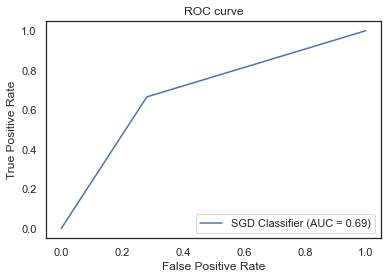

In [23]:
clf_results('SGD Classifier', model, X, y, X_train, y_train, X_test, y_test)

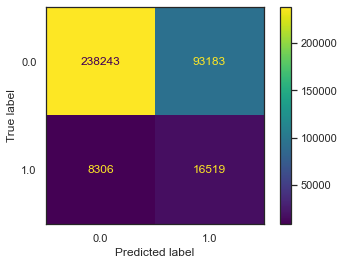

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X)
cm = confusion_matrix(y, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

### Hyperparameters optimization
#### Previous best model

In [11]:
clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=random_state, alpha=0.0005, verbose=1)
model = make_model(clf)
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('sampling', SMOTE(k_neighbors=3, random_state=77)),
                ('classification',
                 SGDClassifier(alpha=0.0005, loss='log_loss', random_state=77,
                               verbose=1))])

In [12]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'sampling', 'classification', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'sampling__k_neighbors', 'sampling__n_jobs', 'sampling__random_state', 'sampling__sampling_strategy', 'classification__alpha', 'classification__average', 'classification__class_weight', 'classification__early_stopping', 'classification__epsilon', 'classification__eta0', 'classification__fit_intercept', 'classification__l1_ratio', 'classification__learning_rate', 'classification__loss', 'classification__max_iter', 'classification__n_iter_no_change', 'classification__n_jobs', 'classification__penalty', 'classification__power_t', 'classification__random_state', 'classification__shuffle', 'classification__tol', 'classification__validation_fraction', 'classification__verbose', 'classification__warm_start'])

#### GridSearchCV

In [27]:
param_grid = {
    'classification__alpha' : np.arange(0.0005 , 0.001, 0.0001), # start, stop, step
    'classification__learning_rate' : ['constant', 'optimal', 'adaptive'],
    'classification__eta0' : np.arange(0, 0.5, 0.1)
}

In [29]:
grid = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
-- Epoch 1
Norm: 6.12, NNZs: 622, Bias: -1.500303, T: 309382, Avg. loss: 4.025027
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 4.20, NNZs: 622, Bias: -1.065779, T: 618764, Avg. loss: 0.692875
Total training time: 1.32 seconds.
-- Epoch 3
Norm: 3.44, NNZs: 622, Bias: -1.028918, T: 928146, Avg. loss: 0.602636
Total training time: 1.95 seconds.
-- Epoch 4
Norm: 3.16, NNZs: 622, Bias: -0.914357, T: 1237528, Avg. loss: 0.572517
Total training time: 2.58 seconds.
-- Epoch 5
Norm: 2.97, NNZs: 622, Bias: -0.857228, T: 1546910, Avg. loss: 0.558174
Total training time: 3.20 seconds.
-- Epoch 6
Norm: 2.83, NNZs: 622, Bias: -0.906664, T: 1856292, Avg. loss: 0.549219
Total training time: 3.82 seconds.
-- Epoch 7
Norm: 2.76, NNZs: 622, Bias: -0.896385, T: 2165674, Avg. loss: 0.543435
Total training time: 4.42 seconds.
-- Epoch 8
Norm: 2.75, NNZs: 622, Bias: -0.883444, T: 2475056, Avg. loss: 0.538798
Total training time: 5.05 second

Norm: 47.39, NNZs: 623, Bias: -13.660809, T: 618764, Avg. loss: 8.427615
Total training time: 1.33 seconds.
-- Epoch 3
Norm: 41.02, NNZs: 623, Bias: -15.278476, T: 928146, Avg. loss: 8.393387
Total training time: 1.92 seconds.
-- Epoch 4
Norm: 44.00, NNZs: 623, Bias: -11.632296, T: 1237528, Avg. loss: 8.455284
Total training time: 2.51 seconds.
-- Epoch 5
Norm: 41.79, NNZs: 623, Bias: -11.460446, T: 1546910, Avg. loss: 8.350718
Total training time: 3.10 seconds.
-- Epoch 6
Norm: 43.26, NNZs: 623, Bias: -11.376131, T: 1856292, Avg. loss: 8.382286
Total training time: 3.69 seconds.
-- Epoch 7
Norm: 43.39, NNZs: 623, Bias: -13.140722, T: 2165674, Avg. loss: 8.435961
Total training time: 4.28 seconds.
-- Epoch 8
Norm: 46.44, NNZs: 623, Bias: -15.159206, T: 2475056, Avg. loss: 8.402174
Total training time: 4.90 seconds.
-- Epoch 9
Norm: 55.84, NNZs: 623, Bias: -12.738468, T: 2784438, Avg. loss: 8.464618
Total training time: 5.49 seconds.
-- Epoch 10
Norm: 44.13, NNZs: 623, Bias: -12.851539,

Norm: 2.52, NNZs: 622, Bias: -0.875361, T: 4021992, Avg. loss: 0.526637
Total training time: 8.00 seconds.
-- Epoch 14
Norm: 2.51, NNZs: 622, Bias: -0.866994, T: 4331376, Avg. loss: 0.525198
Total training time: 8.58 seconds.
-- Epoch 15
Norm: 2.49, NNZs: 622, Bias: -0.872663, T: 4640760, Avg. loss: 0.524703
Total training time: 9.16 seconds.
-- Epoch 16
Norm: 2.50, NNZs: 622, Bias: -0.878660, T: 4950144, Avg. loss: 0.523783
Total training time: 9.75 seconds.
-- Epoch 17
Norm: 2.49, NNZs: 622, Bias: -0.876235, T: 5259528, Avg. loss: 0.523062
Total training time: 10.33 seconds.
-- Epoch 18
Norm: 2.49, NNZs: 622, Bias: -0.845400, T: 5568912, Avg. loss: 0.522265
Total training time: 10.91 seconds.
-- Epoch 19
Norm: 2.49, NNZs: 622, Bias: -0.855477, T: 5878296, Avg. loss: 0.521725
Total training time: 11.50 seconds.
Convergence after 19 epochs took 11.50 seconds
-- Epoch 1
Norm: 43.88, NNZs: 622, Bias: -15.584846, T: 309382, Avg. loss: 8.426548
Total training time: 0.64 seconds.
-- Epoch 2

Norm: 43.26, NNZs: 623, Bias: -11.376131, T: 1856292, Avg. loss: 8.382286
Total training time: 3.71 seconds.
-- Epoch 7
Norm: 43.39, NNZs: 623, Bias: -13.140722, T: 2165674, Avg. loss: 8.435961
Total training time: 4.29 seconds.
-- Epoch 8
Norm: 46.44, NNZs: 623, Bias: -15.159206, T: 2475056, Avg. loss: 8.402174
Total training time: 4.90 seconds.
-- Epoch 9
Norm: 55.84, NNZs: 623, Bias: -12.738468, T: 2784438, Avg. loss: 8.464618
Total training time: 5.51 seconds.
-- Epoch 10
Norm: 44.13, NNZs: 623, Bias: -12.851539, T: 3093820, Avg. loss: 8.413496
Total training time: 6.10 seconds.
-- Epoch 11
Norm: 16.11, NNZs: 623, Bias: -4.428770, T: 3403202, Avg. loss: 1.906257
Total training time: 6.71 seconds.
-- Epoch 12
Norm: 11.27, NNZs: 623, Bias: -2.992116, T: 3712584, Avg. loss: 1.776168
Total training time: 7.34 seconds.
-- Epoch 13
Norm: 10.26, NNZs: 623, Bias: -2.810404, T: 4021966, Avg. loss: 1.788804
Total training time: 7.94 seconds.
-- Epoch 14
Norm: 14.62, NNZs: 623, Bias: -3.50674

Norm: 14.41, NNZs: 622, Bias: -2.848387, T: 2165688, Avg. loss: 1.880100
Total training time: 4.24 seconds.
-- Epoch 8
Norm: 14.36, NNZs: 622, Bias: -3.042610, T: 2475072, Avg. loss: 1.787328
Total training time: 4.84 seconds.
-- Epoch 9
Norm: 9.86, NNZs: 622, Bias: -3.474431, T: 2784456, Avg. loss: 1.781657
Total training time: 5.43 seconds.
-- Epoch 10
Norm: 10.85, NNZs: 622, Bias: -2.935606, T: 3093840, Avg. loss: 1.795150
Total training time: 6.01 seconds.
-- Epoch 11
Norm: 10.69, NNZs: 622, Bias: -2.981194, T: 3403224, Avg. loss: 1.777730
Total training time: 6.60 seconds.
-- Epoch 12
Norm: 14.32, NNZs: 622, Bias: -2.659296, T: 3712608, Avg. loss: 1.793071
Total training time: 7.19 seconds.
-- Epoch 13
Norm: 11.93, NNZs: 622, Bias: -2.597102, T: 4021992, Avg. loss: 1.780680
Total training time: 7.78 seconds.
-- Epoch 14
Norm: 13.77, NNZs: 622, Bias: -3.268386, T: 4331376, Avg. loss: 1.775823
Total training time: 8.37 seconds.
-- Epoch 15
Norm: 11.12, NNZs: 622, Bias: -3.060486, T:

Norm: 66.48, NNZs: 623, Bias: -18.882164, T: 1546910, Avg. loss: 16.041527
Total training time: 3.11 seconds.
-- Epoch 6
Norm: 85.84, NNZs: 623, Bias: -22.088679, T: 1856292, Avg. loss: 16.033085
Total training time: 3.70 seconds.
-- Epoch 7
Norm: 73.65, NNZs: 623, Bias: -23.345641, T: 2165674, Avg. loss: 16.216577
Total training time: 4.28 seconds.
-- Epoch 8
Norm: 70.60, NNZs: 623, Bias: -24.007894, T: 2475056, Avg. loss: 16.060786
Total training time: 4.86 seconds.
-- Epoch 9
Norm: 90.15, NNZs: 623, Bias: -22.866899, T: 2784438, Avg. loss: 16.181915
Total training time: 5.46 seconds.
-- Epoch 10
Norm: 75.62, NNZs: 623, Bias: -20.369890, T: 3093820, Avg. loss: 16.163762
Total training time: 6.05 seconds.
-- Epoch 11
Norm: 109.55, NNZs: 623, Bias: -35.421491, T: 3403202, Avg. loss: 16.257177
Total training time: 6.64 seconds.
Convergence after 11 epochs took 6.64 seconds
-- Epoch 1
Norm: 75.51, NNZs: 622, Bias: -24.705559, T: 309384, Avg. loss: 16.140039
Total training time: 0.63 seco

Norm: 2.52, NNZs: 622, Bias: -0.875361, T: 4021992, Avg. loss: 0.526637
Total training time: 8.25 seconds.
-- Epoch 14
Norm: 2.51, NNZs: 622, Bias: -0.866994, T: 4331376, Avg. loss: 0.525198
Total training time: 8.91 seconds.
-- Epoch 15
Norm: 2.49, NNZs: 622, Bias: -0.872663, T: 4640760, Avg. loss: 0.524703
Total training time: 9.54 seconds.
-- Epoch 16
Norm: 2.50, NNZs: 622, Bias: -0.878660, T: 4950144, Avg. loss: 0.523783
Total training time: 10.16 seconds.
-- Epoch 17
Norm: 2.49, NNZs: 622, Bias: -0.876235, T: 5259528, Avg. loss: 0.523062
Total training time: 10.78 seconds.
-- Epoch 18
Norm: 2.49, NNZs: 622, Bias: -0.845400, T: 5568912, Avg. loss: 0.522265
Total training time: 11.40 seconds.
-- Epoch 19
Norm: 2.49, NNZs: 622, Bias: -0.855477, T: 5878296, Avg. loss: 0.521725
Total training time: 12.02 seconds.
Convergence after 19 epochs took 12.02 seconds
-- Epoch 1
Norm: 67.66, NNZs: 622, Bias: -25.895760, T: 309382, Avg. loss: 16.206881
Total training time: 0.63 seconds.
-- Epoch

Norm: 2.55, NNZs: 622, Bias: -0.831139, T: 19181684, Avg. loss: 0.515257
Total training time: 36.89 seconds.
-- Epoch 63
Norm: 2.55, NNZs: 622, Bias: -0.832369, T: 19491066, Avg. loss: 0.515260
Total training time: 37.49 seconds.
-- Epoch 64
Norm: 2.55, NNZs: 622, Bias: -0.830983, T: 19800448, Avg. loss: 0.515263
Total training time: 38.07 seconds.
-- Epoch 65
Norm: 2.55, NNZs: 622, Bias: -0.831048, T: 20109830, Avg. loss: 0.514919
Total training time: 38.69 seconds.
-- Epoch 66
Norm: 2.55, NNZs: 622, Bias: -0.831084, T: 20419212, Avg. loss: 0.514899
Total training time: 39.29 seconds.
-- Epoch 67
Norm: 2.55, NNZs: 622, Bias: -0.830976, T: 20728594, Avg. loss: 0.514898
Total training time: 39.88 seconds.
-- Epoch 68
Norm: 2.55, NNZs: 622, Bias: -0.831071, T: 21037976, Avg. loss: 0.514896
Total training time: 40.46 seconds.
-- Epoch 69
Norm: 2.55, NNZs: 622, Bias: -0.831031, T: 21347358, Avg. loss: 0.514895
Total training time: 41.06 seconds.
-- Epoch 70
Norm: 2.55, NNZs: 622, Bias: -0.

Norm: 2.50, NNZs: 623, Bias: -0.820941, T: 17325392, Avg. loss: 0.517297
Total training time: 33.46 seconds.
-- Epoch 57
Norm: 2.50, NNZs: 623, Bias: -0.822075, T: 17634774, Avg. loss: 0.517291
Total training time: 34.04 seconds.
-- Epoch 58
Norm: 2.50, NNZs: 623, Bias: -0.821423, T: 17944156, Avg. loss: 0.517279
Total training time: 34.65 seconds.
-- Epoch 59
Norm: 2.50, NNZs: 623, Bias: -0.821408, T: 18253538, Avg. loss: 0.516952
Total training time: 35.27 seconds.
-- Epoch 60
Norm: 2.50, NNZs: 623, Bias: -0.821294, T: 18562920, Avg. loss: 0.516933
Total training time: 35.88 seconds.
-- Epoch 61
Norm: 2.50, NNZs: 623, Bias: -0.821173, T: 18872302, Avg. loss: 0.516930
Total training time: 36.49 seconds.
-- Epoch 62
Norm: 2.50, NNZs: 623, Bias: -0.821182, T: 19181684, Avg. loss: 0.516929
Total training time: 37.12 seconds.
-- Epoch 63
Norm: 2.50, NNZs: 623, Bias: -0.821280, T: 19491066, Avg. loss: 0.516926
Total training time: 37.73 seconds.
-- Epoch 64
Norm: 2.50, NNZs: 623, Bias: -0.

Norm: 2.45, NNZs: 622, Bias: -0.846967, T: 17325504, Avg. loss: 0.512585
Total training time: 33.28 seconds.
-- Epoch 57
Norm: 2.45, NNZs: 622, Bias: -0.846928, T: 17634888, Avg. loss: 0.512589
Total training time: 33.86 seconds.
-- Epoch 58
Norm: 2.45, NNZs: 622, Bias: -0.846931, T: 17944272, Avg. loss: 0.512588
Total training time: 34.46 seconds.
-- Epoch 59
Norm: 2.45, NNZs: 622, Bias: -0.846931, T: 18253656, Avg. loss: 0.512503
Total training time: 35.04 seconds.
-- Epoch 60
Norm: 2.45, NNZs: 622, Bias: -0.846932, T: 18563040, Avg. loss: 0.512502
Total training time: 35.63 seconds.
-- Epoch 61
Norm: 2.45, NNZs: 622, Bias: -0.846935, T: 18872424, Avg. loss: 0.512501
Total training time: 36.21 seconds.
-- Epoch 62
Norm: 2.45, NNZs: 622, Bias: -0.846937, T: 19181808, Avg. loss: 0.512501
Total training time: 36.80 seconds.
-- Epoch 63
Norm: 2.45, NNZs: 622, Bias: -0.846943, T: 19491192, Avg. loss: 0.512501
Total training time: 37.39 seconds.
Convergence after 63 epochs took 37.39 secon

Norm: 2.69, NNZs: 623, Bias: -0.889057, T: 2165674, Avg. loss: 0.545163
Total training time: 4.16 seconds.
-- Epoch 8
Norm: 2.68, NNZs: 623, Bias: -0.888192, T: 2475056, Avg. loss: 0.540246
Total training time: 4.75 seconds.
-- Epoch 9
Norm: 2.63, NNZs: 623, Bias: -0.847750, T: 2784438, Avg. loss: 0.537562
Total training time: 5.36 seconds.
-- Epoch 10
Norm: 2.60, NNZs: 623, Bias: -0.835195, T: 3093820, Avg. loss: 0.534969
Total training time: 5.94 seconds.
-- Epoch 11
Norm: 2.59, NNZs: 623, Bias: -0.844835, T: 3403202, Avg. loss: 0.533626
Total training time: 6.53 seconds.
-- Epoch 12
Norm: 2.57, NNZs: 623, Bias: -0.855406, T: 3712584, Avg. loss: 0.531677
Total training time: 7.12 seconds.
-- Epoch 13
Norm: 2.57, NNZs: 623, Bias: -0.840833, T: 4021966, Avg. loss: 0.530703
Total training time: 7.71 seconds.
-- Epoch 14
Norm: 2.56, NNZs: 623, Bias: -0.852233, T: 4331348, Avg. loss: 0.529470
Total training time: 8.29 seconds.
-- Epoch 15
Norm: 2.55, NNZs: 623, Bias: -0.841963, T: 4640730

Norm: 2.69, NNZs: 622, Bias: -0.860946, T: 11137752, Avg. loss: 0.530880
Total training time: 21.31 seconds.
-- Epoch 37
Norm: 2.67, NNZs: 622, Bias: -0.838558, T: 11447134, Avg. loss: 0.527820
Total training time: 21.89 seconds.
-- Epoch 38
Norm: 2.64, NNZs: 622, Bias: -0.848819, T: 11756516, Avg. loss: 0.527474
Total training time: 22.48 seconds.
-- Epoch 39
Norm: 2.62, NNZs: 622, Bias: -0.856912, T: 12065898, Avg. loss: 0.527980
Total training time: 23.06 seconds.
-- Epoch 40
Norm: 2.61, NNZs: 622, Bias: -0.865879, T: 12375280, Avg. loss: 0.527509
Total training time: 23.65 seconds.
-- Epoch 41
Norm: 2.59, NNZs: 622, Bias: -0.858568, T: 12684662, Avg. loss: 0.527675
Total training time: 24.23 seconds.
-- Epoch 42
Norm: 2.59, NNZs: 622, Bias: -0.851579, T: 12994044, Avg. loss: 0.527970
Total training time: 24.82 seconds.
-- Epoch 43
Norm: 2.57, NNZs: 622, Bias: -0.838556, T: 13303426, Avg. loss: 0.518399
Total training time: 25.41 seconds.
-- Epoch 44
Norm: 2.56, NNZs: 622, Bias: -0.

Norm: 2.69, NNZs: 623, Bias: -0.861014, T: 12375280, Avg. loss: 0.532285
Total training time: 23.76 seconds.
-- Epoch 41
Norm: 2.64, NNZs: 623, Bias: -0.856252, T: 12684662, Avg. loss: 0.529756
Total training time: 24.34 seconds.
-- Epoch 42
Norm: 2.61, NNZs: 623, Bias: -0.840148, T: 12994044, Avg. loss: 0.529619
Total training time: 24.93 seconds.
-- Epoch 43
Norm: 2.61, NNZs: 623, Bias: -0.843374, T: 13303426, Avg. loss: 0.529402
Total training time: 25.52 seconds.
-- Epoch 44
Norm: 2.59, NNZs: 623, Bias: -0.832449, T: 13612808, Avg. loss: 0.529273
Total training time: 26.10 seconds.
-- Epoch 45
Norm: 2.58, NNZs: 623, Bias: -0.835903, T: 13922190, Avg. loss: 0.529443
Total training time: 26.69 seconds.
-- Epoch 46
Norm: 2.56, NNZs: 623, Bias: -0.852673, T: 14231572, Avg. loss: 0.529861
Total training time: 27.28 seconds.
-- Epoch 47
Norm: 2.54, NNZs: 623, Bias: -0.827124, T: 14540954, Avg. loss: 0.520403
Total training time: 27.86 seconds.
-- Epoch 48
Norm: 2.52, NNZs: 623, Bias: -0.

Norm: 2.51, NNZs: 622, Bias: -0.901788, T: 12375360, Avg. loss: 0.525361
Total training time: 23.70 seconds.
-- Epoch 41
Norm: 2.49, NNZs: 622, Bias: -0.882706, T: 12684744, Avg. loss: 0.525484
Total training time: 24.28 seconds.
-- Epoch 42
Norm: 2.47, NNZs: 622, Bias: -0.853369, T: 12994128, Avg. loss: 0.516126
Total training time: 24.87 seconds.
-- Epoch 43
Norm: 2.47, NNZs: 622, Bias: -0.847991, T: 13303512, Avg. loss: 0.515113
Total training time: 25.45 seconds.
-- Epoch 44
Norm: 2.46, NNZs: 622, Bias: -0.856249, T: 13612896, Avg. loss: 0.515216
Total training time: 26.04 seconds.
-- Epoch 45
Norm: 2.46, NNZs: 622, Bias: -0.850195, T: 13922280, Avg. loss: 0.515161
Total training time: 26.63 seconds.
-- Epoch 46
Norm: 2.46, NNZs: 622, Bias: -0.843653, T: 14231664, Avg. loss: 0.515217
Total training time: 27.21 seconds.
-- Epoch 47
Norm: 2.46, NNZs: 622, Bias: -0.861611, T: 14541048, Avg. loss: 0.515107
Total training time: 27.79 seconds.
-- Epoch 48
Norm: 2.45, NNZs: 622, Bias: -0.

Norm: 2.57, NNZs: 622, Bias: -0.844901, T: 6497022, Avg. loss: 0.523317
Total training time: 12.50 seconds.
Convergence after 21 epochs took 12.50 seconds
-- Epoch 1
Norm: 5.32, NNZs: 623, Bias: -1.529537, T: 309382, Avg. loss: 3.728527
Total training time: 0.65 seconds.
-- Epoch 2
Norm: 3.81, NNZs: 623, Bias: -1.043283, T: 618764, Avg. loss: 0.691321
Total training time: 1.32 seconds.
-- Epoch 3
Norm: 3.22, NNZs: 623, Bias: -1.028212, T: 928146, Avg. loss: 0.604561
Total training time: 1.94 seconds.
-- Epoch 4
Norm: 2.98, NNZs: 623, Bias: -0.935813, T: 1237528, Avg. loss: 0.575326
Total training time: 2.58 seconds.
-- Epoch 5
Norm: 2.85, NNZs: 623, Bias: -0.848485, T: 1546910, Avg. loss: 0.558845
Total training time: 3.16 seconds.
-- Epoch 6
Norm: 2.79, NNZs: 623, Bias: -0.902221, T: 1856292, Avg. loss: 0.550615
Total training time: 3.75 seconds.
-- Epoch 7
Norm: 2.69, NNZs: 623, Bias: -0.889057, T: 2165674, Avg. loss: 0.545163
Total training time: 4.34 seconds.
-- Epoch 8
Norm: 2.68,

Norm: 3.82, NNZs: 622, Bias: -1.046709, T: 8972078, Avg. loss: 0.641448
Total training time: 17.37 seconds.
-- Epoch 30
Norm: 3.66, NNZs: 622, Bias: -1.104745, T: 9281460, Avg. loss: 0.625413
Total training time: 17.96 seconds.
-- Epoch 31
Norm: 3.49, NNZs: 622, Bias: -1.024303, T: 9590842, Avg. loss: 0.629316
Total training time: 18.54 seconds.
-- Epoch 32
Norm: 3.36, NNZs: 622, Bias: -1.046199, T: 9900224, Avg. loss: 0.627938
Total training time: 19.12 seconds.
-- Epoch 33
Norm: 3.35, NNZs: 622, Bias: -1.016531, T: 10209606, Avg. loss: 0.626872
Total training time: 19.71 seconds.
-- Epoch 34
Norm: 3.41, NNZs: 622, Bias: -0.962403, T: 10518988, Avg. loss: 0.629414
Total training time: 20.33 seconds.
-- Epoch 35
Norm: 3.44, NNZs: 622, Bias: -1.071585, T: 10828370, Avg. loss: 0.625842
Total training time: 20.93 seconds.
-- Epoch 36
Norm: 2.76, NNZs: 622, Bias: -0.869814, T: 11137752, Avg. loss: 0.537818
Total training time: 21.52 seconds.
-- Epoch 37
Norm: 2.72, NNZs: 622, Bias: -0.8506

Norm: 8.63, NNZs: 623, Bias: -2.417092, T: 8662696, Avg. loss: 1.460066
Total training time: 16.93 seconds.
-- Epoch 29
Norm: 10.16, NNZs: 623, Bias: -2.253153, T: 8972078, Avg. loss: 1.471133
Total training time: 17.51 seconds.
-- Epoch 30
Norm: 8.42, NNZs: 623, Bias: -2.560149, T: 9281460, Avg. loss: 1.445804
Total training time: 18.10 seconds.
-- Epoch 31
Norm: 8.31, NNZs: 623, Bias: -2.274657, T: 9590842, Avg. loss: 1.461673
Total training time: 18.69 seconds.
-- Epoch 32
Norm: 3.64, NNZs: 623, Bias: -1.070619, T: 9900224, Avg. loss: 0.644154
Total training time: 19.27 seconds.
-- Epoch 33
Norm: 3.30, NNZs: 623, Bias: -1.047058, T: 10209606, Avg. loss: 0.628989
Total training time: 19.86 seconds.
-- Epoch 34
Norm: 3.56, NNZs: 623, Bias: -0.973144, T: 10518988, Avg. loss: 0.627481
Total training time: 20.44 seconds.
-- Epoch 35
Norm: 3.37, NNZs: 623, Bias: -1.088181, T: 10828370, Avg. loss: 0.627664
Total training time: 21.05 seconds.
-- Epoch 36
Norm: 3.37, NNZs: 623, Bias: -1.0340

Norm: 9.37, NNZs: 622, Bias: -2.788551, T: 7115832, Avg. loss: 1.460593
Total training time: 13.57 seconds.
-- Epoch 24
Norm: 10.19, NNZs: 622, Bias: -2.686163, T: 7425216, Avg. loss: 1.469110
Total training time: 14.20 seconds.
-- Epoch 25
Norm: 9.08, NNZs: 622, Bias: -2.656743, T: 7734600, Avg. loss: 1.467169
Total training time: 14.79 seconds.
-- Epoch 26
Norm: 11.44, NNZs: 622, Bias: -2.870511, T: 8043984, Avg. loss: 1.465343
Total training time: 15.37 seconds.
-- Epoch 27
Norm: 9.55, NNZs: 622, Bias: -2.919003, T: 8353368, Avg. loss: 1.458672
Total training time: 15.96 seconds.
-- Epoch 28
Norm: 4.14, NNZs: 622, Bias: -1.096235, T: 8662752, Avg. loss: 0.645541
Total training time: 16.54 seconds.
-- Epoch 29
Norm: 3.57, NNZs: 622, Bias: -1.055116, T: 8972136, Avg. loss: 0.625071
Total training time: 17.12 seconds.
-- Epoch 30
Norm: 3.50, NNZs: 622, Bias: -1.151018, T: 9281520, Avg. loss: 0.625829
Total training time: 17.71 seconds.
-- Epoch 31
Norm: 3.27, NNZs: 622, Bias: -1.051925

Norm: 2.65, NNZs: 623, Bias: -0.836278, T: 1546910, Avg. loss: 0.550911
Total training time: 3.04 seconds.
-- Epoch 6
Norm: 2.60, NNZs: 623, Bias: -0.886033, T: 1856292, Avg. loss: 0.544452
Total training time: 3.64 seconds.
-- Epoch 7
Norm: 2.53, NNZs: 623, Bias: -0.875437, T: 2165674, Avg. loss: 0.540058
Total training time: 4.23 seconds.
-- Epoch 8
Norm: 2.52, NNZs: 623, Bias: -0.872920, T: 2475056, Avg. loss: 0.536164
Total training time: 4.82 seconds.
-- Epoch 9
Norm: 2.47, NNZs: 623, Bias: -0.840020, T: 2784438, Avg. loss: 0.534001
Total training time: 5.40 seconds.
-- Epoch 10
Norm: 2.46, NNZs: 623, Bias: -0.827551, T: 3093820, Avg. loss: 0.531962
Total training time: 5.98 seconds.
-- Epoch 11
Norm: 2.44, NNZs: 623, Bias: -0.836239, T: 3403202, Avg. loss: 0.530764
Total training time: 6.57 seconds.
-- Epoch 12
Norm: 2.43, NNZs: 623, Bias: -0.848426, T: 3712584, Avg. loss: 0.529165
Total training time: 7.15 seconds.
-- Epoch 13
Norm: 2.43, NNZs: 623, Bias: -0.835308, T: 4021966, 

Norm: 3.72, NNZs: 622, Bias: -1.014150, T: 618764, Avg. loss: 0.655570
Total training time: 1.26 seconds.
-- Epoch 3
Norm: 3.10, NNZs: 622, Bias: -0.986999, T: 928146, Avg. loss: 0.584904
Total training time: 1.85 seconds.
-- Epoch 4
Norm: 2.89, NNZs: 622, Bias: -0.896820, T: 1237528, Avg. loss: 0.561351
Total training time: 2.49 seconds.
-- Epoch 5
Norm: 2.75, NNZs: 622, Bias: -0.842690, T: 1546910, Avg. loss: 0.550213
Total training time: 3.15 seconds.
-- Epoch 6
Norm: 2.64, NNZs: 622, Bias: -0.892757, T: 1856292, Avg. loss: 0.542950
Total training time: 3.74 seconds.
-- Epoch 7
Norm: 2.58, NNZs: 622, Bias: -0.882424, T: 2165674, Avg. loss: 0.538299
Total training time: 4.33 seconds.
-- Epoch 8
Norm: 2.58, NNZs: 622, Bias: -0.869067, T: 2475056, Avg. loss: 0.534678
Total training time: 4.91 seconds.
-- Epoch 9
Norm: 2.54, NNZs: 622, Bias: -0.836671, T: 2784438, Avg. loss: 0.532229
Total training time: 5.50 seconds.
-- Epoch 10
Norm: 2.53, NNZs: 622, Bias: -0.830365, T: 3093820, Avg. 

Norm: 3.57, NNZs: 622, Bias: -1.144326, T: 4640730, Avg. loss: 0.667981
Total training time: 8.86 seconds.
-- Epoch 16
Norm: 3.60, NNZs: 622, Bias: -1.078956, T: 4950112, Avg. loss: 0.664439
Total training time: 9.44 seconds.
-- Epoch 17
Norm: 3.55, NNZs: 622, Bias: -1.126865, T: 5259494, Avg. loss: 0.664453
Total training time: 10.02 seconds.
-- Epoch 18
Norm: 3.46, NNZs: 622, Bias: -1.131604, T: 5568876, Avg. loss: 0.665131
Total training time: 10.61 seconds.
-- Epoch 19
Norm: 3.33, NNZs: 622, Bias: -1.055248, T: 5878258, Avg. loss: 0.663909
Total training time: 11.20 seconds.
-- Epoch 20
Norm: 3.49, NNZs: 622, Bias: -1.135358, T: 6187640, Avg. loss: 0.666136
Total training time: 11.78 seconds.
-- Epoch 21
Norm: 3.57, NNZs: 622, Bias: -1.071451, T: 6497022, Avg. loss: 0.666536
Total training time: 12.36 seconds.
-- Epoch 22
Norm: 2.82, NNZs: 622, Bias: -0.878584, T: 6806404, Avg. loss: 0.541142
Total training time: 12.94 seconds.
-- Epoch 23
Norm: 2.68, NNZs: 622, Bias: -0.892823, T:

Norm: 3.67, NNZs: 623, Bias: -1.144887, T: 8353314, Avg. loss: 0.663477
Total training time: 16.08 seconds.
-- Epoch 28
Norm: 3.33, NNZs: 623, Bias: -1.129027, T: 8662696, Avg. loss: 0.664965
Total training time: 16.67 seconds.
-- Epoch 29
Norm: 3.35, NNZs: 623, Bias: -0.995884, T: 8972078, Avg. loss: 0.666897
Total training time: 17.24 seconds.
-- Epoch 30
Norm: 3.41, NNZs: 623, Bias: -1.082105, T: 9281460, Avg. loss: 0.663429
Total training time: 17.83 seconds.
-- Epoch 31
Norm: 3.50, NNZs: 623, Bias: -1.036413, T: 9590842, Avg. loss: 0.667412
Total training time: 18.41 seconds.
-- Epoch 32
Norm: 3.40, NNZs: 623, Bias: -1.121465, T: 9900224, Avg. loss: 0.666483
Total training time: 19.00 seconds.
-- Epoch 33
Norm: 2.63, NNZs: 623, Bias: -0.895958, T: 10209606, Avg. loss: 0.543925
Total training time: 19.58 seconds.
-- Epoch 34
Norm: 2.59, NNZs: 623, Bias: -0.834562, T: 10518988, Avg. loss: 0.538139
Total training time: 20.16 seconds.
-- Epoch 35
Norm: 2.52, NNZs: 623, Bias: -0.875254

Norm: 3.72, NNZs: 622, Bias: -1.129122, T: 8662752, Avg. loss: 0.665428
Total training time: 16.50 seconds.
-- Epoch 29
Norm: 3.43, NNZs: 622, Bias: -1.090575, T: 8972136, Avg. loss: 0.661719
Total training time: 17.08 seconds.
-- Epoch 30
Norm: 3.71, NNZs: 622, Bias: -1.216806, T: 9281520, Avg. loss: 0.663253
Total training time: 17.67 seconds.
-- Epoch 31
Norm: 3.47, NNZs: 622, Bias: -1.123204, T: 9590904, Avg. loss: 0.665330
Total training time: 18.25 seconds.
-- Epoch 32
Norm: 3.41, NNZs: 622, Bias: -1.034810, T: 9900288, Avg. loss: 0.663999
Total training time: 18.84 seconds.
-- Epoch 33
Norm: 3.48, NNZs: 622, Bias: -1.193402, T: 10209672, Avg. loss: 0.664132
Total training time: 19.42 seconds.
-- Epoch 34
Norm: 3.30, NNZs: 622, Bias: -1.047965, T: 10519056, Avg. loss: 0.666467
Total training time: 20.00 seconds.
-- Epoch 35
Norm: 2.60, NNZs: 622, Bias: -0.895265, T: 10828440, Avg. loss: 0.539502
Total training time: 20.59 seconds.
-- Epoch 36
Norm: 2.55, NNZs: 622, Bias: -0.89238

Norm: 2.89, NNZs: 622, Bias: -0.896820, T: 1237528, Avg. loss: 0.561351
Total training time: 2.50 seconds.
-- Epoch 5
Norm: 2.75, NNZs: 622, Bias: -0.842690, T: 1546910, Avg. loss: 0.550213
Total training time: 3.10 seconds.
-- Epoch 6
Norm: 2.64, NNZs: 622, Bias: -0.892757, T: 1856292, Avg. loss: 0.542950
Total training time: 3.74 seconds.
-- Epoch 7
Norm: 2.58, NNZs: 622, Bias: -0.882424, T: 2165674, Avg. loss: 0.538299
Total training time: 4.37 seconds.
-- Epoch 8
Norm: 2.58, NNZs: 622, Bias: -0.869067, T: 2475056, Avg. loss: 0.534678
Total training time: 4.95 seconds.
-- Epoch 9
Norm: 2.54, NNZs: 622, Bias: -0.836671, T: 2784438, Avg. loss: 0.532229
Total training time: 5.53 seconds.
-- Epoch 10
Norm: 2.53, NNZs: 622, Bias: -0.830365, T: 3093820, Avg. loss: 0.530399
Total training time: 6.11 seconds.
-- Epoch 11
Norm: 2.48, NNZs: 622, Bias: -0.859136, T: 3403202, Avg. loss: 0.529027
Total training time: 6.70 seconds.
-- Epoch 12
Norm: 2.48, NNZs: 622, Bias: -0.871748, T: 3712584, A

Norm: 5.32, NNZs: 622, Bias: -1.501326, T: 5259494, Avg. loss: 0.886918
Total training time: 10.30 seconds.
-- Epoch 18
Norm: 4.95, NNZs: 622, Bias: -1.492524, T: 5568876, Avg. loss: 0.885485
Total training time: 10.88 seconds.
-- Epoch 19
Norm: 4.79, NNZs: 622, Bias: -1.455654, T: 5878258, Avg. loss: 0.892587
Total training time: 11.48 seconds.
-- Epoch 20
Norm: 5.29, NNZs: 622, Bias: -1.523857, T: 6187640, Avg. loss: 0.887369
Total training time: 12.06 seconds.
-- Epoch 21
Norm: 5.68, NNZs: 622, Bias: -1.483634, T: 6497022, Avg. loss: 0.892078
Total training time: 12.66 seconds.
-- Epoch 22
Norm: 5.67, NNZs: 622, Bias: -1.602661, T: 6806404, Avg. loss: 0.890939
Total training time: 13.25 seconds.
-- Epoch 23
Norm: 5.25, NNZs: 622, Bias: -1.652832, T: 7115786, Avg. loss: 0.885225
Total training time: 13.83 seconds.
-- Epoch 24
Norm: 3.04, NNZs: 622, Bias: -0.988344, T: 7425168, Avg. loss: 0.573174
Total training time: 14.42 seconds.
-- Epoch 25
Norm: 2.76, NNZs: 622, Bias: -0.945412, 

Norm: 7.05, NNZs: 623, Bias: -1.774368, T: 8043932, Avg. loss: 0.921423
Total training time: 15.43 seconds.
-- Epoch 27
Norm: 5.58, NNZs: 623, Bias: -1.602665, T: 8353314, Avg. loss: 0.884355
Total training time: 16.05 seconds.
-- Epoch 28
Norm: 4.95, NNZs: 623, Bias: -1.499146, T: 8662696, Avg. loss: 0.883823
Total training time: 16.71 seconds.
-- Epoch 29
Norm: 4.97, NNZs: 623, Bias: -1.358882, T: 8972078, Avg. loss: 0.890087
Total training time: 17.32 seconds.
-- Epoch 30
Norm: 5.00, NNZs: 623, Bias: -1.508269, T: 9281460, Avg. loss: 0.881725
Total training time: 17.93 seconds.
-- Epoch 31
Norm: 5.06, NNZs: 623, Bias: -1.390113, T: 9590842, Avg. loss: 0.889756
Total training time: 18.52 seconds.
-- Epoch 32
Norm: 4.93, NNZs: 623, Bias: -1.447800, T: 9900224, Avg. loss: 0.889140
Total training time: 19.11 seconds.
-- Epoch 33
Norm: 5.28, NNZs: 623, Bias: -1.443715, T: 10209606, Avg. loss: 0.888865
Total training time: 19.74 seconds.
-- Epoch 34
Norm: 6.28, NNZs: 623, Bias: -1.405183,

Norm: 5.67, NNZs: 622, Bias: -1.672608, T: 7115832, Avg. loss: 0.887369
Total training time: 15.28 seconds.
-- Epoch 24
Norm: 5.54, NNZs: 622, Bias: -1.675501, T: 7425216, Avg. loss: 0.891098
Total training time: 15.92 seconds.
-- Epoch 25
Norm: 5.39, NNZs: 622, Bias: -1.623253, T: 7734600, Avg. loss: 0.888359
Total training time: 16.65 seconds.
-- Epoch 26
Norm: 2.97, NNZs: 622, Bias: -1.007850, T: 8043984, Avg. loss: 0.572348
Total training time: 17.32 seconds.
-- Epoch 27
Norm: 2.88, NNZs: 622, Bias: -0.923558, T: 8353368, Avg. loss: 0.561138
Total training time: 18.01 seconds.
-- Epoch 28
Norm: 2.73, NNZs: 622, Bias: -0.943139, T: 8662752, Avg. loss: 0.561808
Total training time: 18.61 seconds.
-- Epoch 29
Norm: 2.69, NNZs: 622, Bias: -0.932634, T: 8972136, Avg. loss: 0.560944
Total training time: 19.21 seconds.
-- Epoch 30
Norm: 2.68, NNZs: 622, Bias: -0.998036, T: 9281520, Avg. loss: 0.562150
Total training time: 19.81 seconds.
-- Epoch 31
Norm: 2.67, NNZs: 622, Bias: -0.920219, 

Norm: 2.75, NNZs: 622, Bias: -0.842690, T: 1546910, Avg. loss: 0.550213
Total training time: 3.28 seconds.
-- Epoch 6
Norm: 2.64, NNZs: 622, Bias: -0.892757, T: 1856292, Avg. loss: 0.542950
Total training time: 3.90 seconds.
-- Epoch 7
Norm: 2.58, NNZs: 622, Bias: -0.882424, T: 2165674, Avg. loss: 0.538299
Total training time: 4.51 seconds.
-- Epoch 8
Norm: 2.58, NNZs: 622, Bias: -0.869067, T: 2475056, Avg. loss: 0.534678
Total training time: 5.14 seconds.
-- Epoch 9
Norm: 2.54, NNZs: 622, Bias: -0.836671, T: 2784438, Avg. loss: 0.532229
Total training time: 5.79 seconds.
-- Epoch 10
Norm: 2.53, NNZs: 622, Bias: -0.830365, T: 3093820, Avg. loss: 0.530399
Total training time: 6.39 seconds.
-- Epoch 11
Norm: 2.48, NNZs: 622, Bias: -0.859136, T: 3403202, Avg. loss: 0.529027
Total training time: 7.05 seconds.
-- Epoch 12
Norm: 2.48, NNZs: 622, Bias: -0.871748, T: 3712584, Avg. loss: 0.527390
Total training time: 7.67 seconds.
-- Epoch 13
Norm: 2.49, NNZs: 622, Bias: -0.838374, T: 4021966, 

Norm: 7.01, NNZs: 622, Bias: -1.890665, T: 5568876, Avg. loss: 1.164293
Total training time: 10.77 seconds.
-- Epoch 19
Norm: 8.42, NNZs: 622, Bias: -1.990210, T: 5878258, Avg. loss: 1.164405
Total training time: 11.36 seconds.
-- Epoch 20
Norm: 7.54, NNZs: 622, Bias: -2.014773, T: 6187640, Avg. loss: 1.160946
Total training time: 11.94 seconds.
-- Epoch 21
Norm: 6.89, NNZs: 622, Bias: -1.963451, T: 6497022, Avg. loss: 1.167480
Total training time: 12.53 seconds.
-- Epoch 22
Norm: 8.60, NNZs: 622, Bias: -2.111443, T: 6806404, Avg. loss: 1.163369
Total training time: 13.11 seconds.
-- Epoch 23
Norm: 6.78, NNZs: 622, Bias: -2.216440, T: 7115786, Avg. loss: 1.158203
Total training time: 13.70 seconds.
-- Epoch 24
Norm: 6.24, NNZs: 622, Bias: -2.190399, T: 7425168, Avg. loss: 1.161000
Total training time: 14.29 seconds.
-- Epoch 25
Norm: 6.48, NNZs: 622, Bias: -2.122014, T: 7734550, Avg. loss: 1.161325
Total training time: 14.88 seconds.
-- Epoch 26
Norm: 7.53, NNZs: 622, Bias: -2.124409, 

Norm: 27.69, NNZs: 623, Bias: -8.585987, T: 6806404, Avg. loss: 5.069091
Total training time: 13.11 seconds.
-- Epoch 23
Norm: 27.30, NNZs: 623, Bias: -8.524265, T: 7115786, Avg. loss: 5.083355
Total training time: 13.69 seconds.
-- Epoch 24
Norm: 6.91, NNZs: 623, Bias: -2.037611, T: 7425168, Avg. loss: 1.236889
Total training time: 14.28 seconds.
-- Epoch 25
Norm: 6.32, NNZs: 623, Bias: -2.163981, T: 7734550, Avg. loss: 1.161687
Total training time: 14.88 seconds.
-- Epoch 26
Norm: 7.33, NNZs: 623, Bias: -2.296330, T: 8043932, Avg. loss: 1.142390
Total training time: 15.46 seconds.
-- Epoch 27
Norm: 9.31, NNZs: 623, Bias: -2.134380, T: 8353314, Avg. loss: 1.153620
Total training time: 16.05 seconds.
-- Epoch 28
Norm: 6.76, NNZs: 623, Bias: -1.937759, T: 8662696, Avg. loss: 1.159349
Total training time: 16.64 seconds.
-- Epoch 29
Norm: 6.58, NNZs: 623, Bias: -1.791028, T: 8972078, Avg. loss: 1.165600
Total training time: 17.24 seconds.
-- Epoch 30
Norm: 6.48, NNZs: 623, Bias: -2.008676

Norm: 7.97, NNZs: 622, Bias: -1.831849, T: 6806448, Avg. loss: 1.153242
Total training time: 13.26 seconds.
-- Epoch 23
Norm: 7.27, NNZs: 622, Bias: -2.216093, T: 7115832, Avg. loss: 1.157487
Total training time: 13.86 seconds.
-- Epoch 24
Norm: 7.80, NNZs: 622, Bias: -2.203662, T: 7425216, Avg. loss: 1.158575
Total training time: 14.45 seconds.
-- Epoch 25
Norm: 7.11, NNZs: 622, Bias: -2.102229, T: 7734600, Avg. loss: 1.159107
Total training time: 15.04 seconds.
-- Epoch 26
Norm: 8.76, NNZs: 622, Bias: -2.257074, T: 8043984, Avg. loss: 1.161080
Total training time: 15.62 seconds.
-- Epoch 27
Norm: 7.25, NNZs: 622, Bias: -2.210416, T: 8353368, Avg. loss: 1.155387
Total training time: 16.21 seconds.
-- Epoch 28
Norm: 3.57, NNZs: 622, Bias: -1.018656, T: 8662752, Avg. loss: 0.604999
Total training time: 16.83 seconds.
-- Epoch 29
Norm: 3.15, NNZs: 622, Bias: -0.991656, T: 8972136, Avg. loss: 0.591487
Total training time: 17.42 seconds.
-- Epoch 30
Norm: 3.05, NNZs: 622, Bias: -1.075220, 

-- Epoch 1
Norm: 128.34, NNZs: 623, Bias: -45.174112, T: 309382, Avg. loss: 29.732328
Total training time: 0.64 seconds.
-- Epoch 2
Norm: 119.77, NNZs: 623, Bias: -40.950430, T: 618764, Avg. loss: 29.837294
Total training time: 1.27 seconds.
-- Epoch 3
Norm: 118.71, NNZs: 623, Bias: -45.002758, T: 928146, Avg. loss: 29.847142
Total training time: 1.90 seconds.
-- Epoch 4
Norm: 133.71, NNZs: 623, Bias: -40.437766, T: 1237528, Avg. loss: 29.908934
Total training time: 2.51 seconds.
-- Epoch 5
Norm: 119.65, NNZs: 623, Bias: -36.120826, T: 1546910, Avg. loss: 29.358090
Total training time: 3.12 seconds.
-- Epoch 6
Norm: 141.72, NNZs: 623, Bias: -35.911336, T: 1856292, Avg. loss: 29.656626
Total training time: 3.77 seconds.
-- Epoch 7
Norm: 143.98, NNZs: 623, Bias: -37.551579, T: 2165674, Avg. loss: 29.630772
Total training time: 4.37 seconds.
-- Epoch 8
Norm: 109.07, NNZs: 623, Bias: -43.830548, T: 2475056, Avg. loss: 29.529014
Total training time: 5.00 seconds.
-- Epoch 9
Norm: 120.32, NN

Norm: 3.20, NNZs: 622, Bias: -0.945837, T: 618768, Avg. loss: 0.653228
Total training time: 1.29 seconds.
-- Epoch 3
Norm: 2.82, NNZs: 622, Bias: -0.995323, T: 928152, Avg. loss: 0.584388
Total training time: 1.93 seconds.
-- Epoch 4
Norm: 2.64, NNZs: 622, Bias: -0.918660, T: 1237536, Avg. loss: 0.561074
Total training time: 2.57 seconds.
-- Epoch 5
Norm: 2.55, NNZs: 622, Bias: -0.909520, T: 1546920, Avg. loss: 0.548338
Total training time: 3.21 seconds.
-- Epoch 6
Norm: 2.52, NNZs: 622, Bias: -0.876859, T: 1856304, Avg. loss: 0.540374
Total training time: 3.86 seconds.
-- Epoch 7
Norm: 2.51, NNZs: 622, Bias: -0.880779, T: 2165688, Avg. loss: 0.536064
Total training time: 4.54 seconds.
-- Epoch 8
Norm: 2.45, NNZs: 622, Bias: -0.866008, T: 2475072, Avg. loss: 0.532395
Total training time: 5.18 seconds.
-- Epoch 9
Norm: 2.41, NNZs: 622, Bias: -0.883735, T: 2784456, Avg. loss: 0.530174
Total training time: 5.83 seconds.
-- Epoch 10
Norm: 2.43, NNZs: 622, Bias: -0.861892, T: 3093840, Avg. 

Norm: 3.13, NNZs: 622, Bias: -1.093595, T: 15778482, Avg. loss: 0.628151
Total training time: 30.47 seconds.
-- Epoch 52
Norm: 3.23, NNZs: 622, Bias: -1.089701, T: 16087864, Avg. loss: 0.626470
Total training time: 31.12 seconds.
-- Epoch 53
Norm: 3.14, NNZs: 622, Bias: -1.036819, T: 16397246, Avg. loss: 0.630176
Total training time: 31.77 seconds.
-- Epoch 54
Norm: 2.68, NNZs: 622, Bias: -0.855165, T: 16706628, Avg. loss: 0.535027
Total training time: 32.41 seconds.
-- Epoch 55
Norm: 2.59, NNZs: 622, Bias: -0.870884, T: 17016010, Avg. loss: 0.532165
Total training time: 33.04 seconds.
-- Epoch 56
Norm: 2.55, NNZs: 622, Bias: -0.861521, T: 17325392, Avg. loss: 0.532640
Total training time: 33.69 seconds.
-- Epoch 57
Norm: 2.55, NNZs: 622, Bias: -0.860771, T: 17634774, Avg. loss: 0.532589
Total training time: 34.34 seconds.
-- Epoch 58
Norm: 2.53, NNZs: 622, Bias: -0.872994, T: 17944156, Avg. loss: 0.532392
Total training time: 35.01 seconds.
-- Epoch 59
Norm: 2.51, NNZs: 622, Bias: -0.

Norm: 8.30, NNZs: 623, Bias: -2.260578, T: 9590842, Avg. loss: 1.451968
Total training time: 18.27 seconds.
-- Epoch 32
Norm: 8.84, NNZs: 623, Bias: -2.317029, T: 9900224, Avg. loss: 1.463707
Total training time: 18.87 seconds.
-- Epoch 33
Norm: 8.70, NNZs: 623, Bias: -2.447618, T: 10209606, Avg. loss: 1.457355
Total training time: 19.47 seconds.
-- Epoch 34
Norm: 12.41, NNZs: 623, Bias: -2.256732, T: 10518988, Avg. loss: 1.451009
Total training time: 20.07 seconds.
-- Epoch 35
Norm: 10.04, NNZs: 623, Bias: -2.492614, T: 10828370, Avg. loss: 1.450419
Total training time: 20.67 seconds.
-- Epoch 36
Norm: 4.74, NNZs: 623, Bias: -1.060928, T: 11137752, Avg. loss: 0.644340
Total training time: 21.26 seconds.
-- Epoch 37
Norm: 3.74, NNZs: 623, Bias: -1.012931, T: 11447134, Avg. loss: 0.628020
Total training time: 21.85 seconds.
-- Epoch 38
Norm: 3.22, NNZs: 623, Bias: -1.082063, T: 11756516, Avg. loss: 0.627914
Total training time: 22.42 seconds.
-- Epoch 39
Norm: 3.38, NNZs: 623, Bias: -1.

Norm: 111.44, NNZs: 622, Bias: -44.835154, T: 6187680, Avg. loss: 29.611069
Total training time: 11.87 seconds.
-- Epoch 21
Norm: 41.51, NNZs: 622, Bias: -9.849908, T: 6497064, Avg. loss: 6.860630
Total training time: 12.46 seconds.
-- Epoch 22
Norm: 36.29, NNZs: 622, Bias: -8.901671, T: 6806448, Avg. loss: 6.725095
Total training time: 13.07 seconds.
-- Epoch 23
Norm: 34.53, NNZs: 622, Bias: -12.156500, T: 7115832, Avg. loss: 6.685511
Total training time: 13.68 seconds.
-- Epoch 24
Norm: 45.32, NNZs: 622, Bias: -11.028117, T: 7425216, Avg. loss: 6.704972
Total training time: 14.28 seconds.
-- Epoch 25
Norm: 30.10, NNZs: 622, Bias: -11.231185, T: 7734600, Avg. loss: 6.749875
Total training time: 14.85 seconds.
-- Epoch 26
Norm: 37.50, NNZs: 622, Bias: -13.077811, T: 8043984, Avg. loss: 6.737455
Total training time: 15.42 seconds.
-- Epoch 27
Norm: 34.36, NNZs: 622, Bias: -12.697785, T: 8353368, Avg. loss: 6.695622
Total training time: 15.99 seconds.
-- Epoch 28
Norm: 41.64, NNZs: 622, 

Norm: 2.58, NNZs: 622, Bias: -0.832884, T: 1546910, Avg. loss: 0.544762
Total training time: 3.12 seconds.
-- Epoch 6
Norm: 2.49, NNZs: 622, Bias: -0.882280, T: 1856292, Avg. loss: 0.538761
Total training time: 3.71 seconds.
-- Epoch 7
Norm: 2.45, NNZs: 622, Bias: -0.871792, T: 2165674, Avg. loss: 0.534767
Total training time: 4.28 seconds.
-- Epoch 8
Norm: 2.45, NNZs: 622, Bias: -0.858619, T: 2475056, Avg. loss: 0.531795
Total training time: 4.85 seconds.
-- Epoch 9
Norm: 2.42, NNZs: 622, Bias: -0.833183, T: 2784438, Avg. loss: 0.529755
Total training time: 5.43 seconds.
-- Epoch 10
Norm: 2.41, NNZs: 622, Bias: -0.823583, T: 3093820, Avg. loss: 0.528239
Total training time: 6.01 seconds.
-- Epoch 11
Norm: 2.37, NNZs: 622, Bias: -0.850885, T: 3403202, Avg. loss: 0.527091
Total training time: 6.58 seconds.
-- Epoch 12
Norm: 2.37, NNZs: 622, Bias: -0.862827, T: 3712584, Avg. loss: 0.525661
Total training time: 7.27 seconds.
-- Epoch 13
Norm: 2.37, NNZs: 622, Bias: -0.833003, T: 4021966, 

Norm: 35.52, NNZs: 622, Bias: -11.331899, T: 1856304, Avg. loss: 8.229723
Total training time: 3.92 seconds.
-- Epoch 7
Norm: 44.74, NNZs: 622, Bias: -11.936088, T: 2165688, Avg. loss: 8.224303
Total training time: 4.52 seconds.
-- Epoch 8
Norm: 50.50, NNZs: 622, Bias: -12.953238, T: 2475072, Avg. loss: 8.252521
Total training time: 5.09 seconds.
-- Epoch 9
Norm: 35.97, NNZs: 622, Bias: -14.718071, T: 2784456, Avg. loss: 8.226492
Total training time: 5.67 seconds.
-- Epoch 10
Norm: 48.92, NNZs: 622, Bias: -12.246049, T: 3093840, Avg. loss: 8.209612
Total training time: 6.25 seconds.
Convergence after 10 epochs took 6.25 seconds
-- Epoch 1
Norm: 4.35, NNZs: 622, Bias: -1.257195, T: 309382, Avg. loss: 2.977012
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 3.30, NNZs: 622, Bias: -0.981078, T: 618764, Avg. loss: 0.630312
Total training time: 1.26 seconds.
-- Epoch 3
Norm: 2.84, NNZs: 622, Bias: -0.956881, T: 928146, Avg. loss: 0.573043
Total training time: 1.87 seconds.
-- Epoch 4
No

Norm: 11.16, NNZs: 622, Bias: -2.373120, T: 4021966, Avg. loss: 1.787185
Total training time: 7.80 seconds.
-- Epoch 14
Norm: 13.50, NNZs: 622, Bias: -3.031955, T: 4331348, Avg. loss: 1.776705
Total training time: 8.40 seconds.
-- Epoch 15
Norm: 9.29, NNZs: 622, Bias: -3.031700, T: 4640730, Avg. loss: 1.782777
Total training time: 9.01 seconds.
-- Epoch 16
Norm: 3.54, NNZs: 622, Bias: -1.075130, T: 4950112, Avg. loss: 0.684562
Total training time: 9.59 seconds.
-- Epoch 17
Norm: 3.47, NNZs: 622, Bias: -1.125926, T: 5259494, Avg. loss: 0.664325
Total training time: 10.19 seconds.
-- Epoch 18
Norm: 3.36, NNZs: 622, Bias: -1.126225, T: 5568876, Avg. loss: 0.664365
Total training time: 10.76 seconds.
-- Epoch 19
Norm: 3.49, NNZs: 622, Bias: -1.054242, T: 5878258, Avg. loss: 0.663571
Total training time: 11.35 seconds.
-- Epoch 20
Norm: 3.62, NNZs: 622, Bias: -1.141874, T: 6187640, Avg. loss: 0.665995
Total training time: 11.94 seconds.
-- Epoch 21
Norm: 3.48, NNZs: 622, Bias: -1.066242, T:

Norm: 12.47, NNZs: 623, Bias: -2.903471, T: 7425168, Avg. loss: 1.768910
Total training time: 14.83 seconds.
-- Epoch 25
Norm: 11.32, NNZs: 623, Bias: -3.203782, T: 7734550, Avg. loss: 1.772027
Total training time: 15.45 seconds.
-- Epoch 26
Norm: 4.72, NNZs: 623, Bias: -1.265415, T: 8043932, Avg. loss: 0.682527
Total training time: 16.08 seconds.
-- Epoch 27
Norm: 3.73, NNZs: 623, Bias: -1.140569, T: 8353314, Avg. loss: 0.663217
Total training time: 16.68 seconds.
-- Epoch 28
Norm: 3.29, NNZs: 623, Bias: -1.128900, T: 8662696, Avg. loss: 0.664565
Total training time: 17.30 seconds.
-- Epoch 29
Norm: 3.24, NNZs: 623, Bias: -0.978805, T: 8972078, Avg. loss: 0.666487
Total training time: 17.91 seconds.
-- Epoch 30
Norm: 3.41, NNZs: 623, Bias: -1.087351, T: 9281460, Avg. loss: 0.664472
Total training time: 18.53 seconds.
-- Epoch 31
Norm: 3.39, NNZs: 623, Bias: -1.041552, T: 9590842, Avg. loss: 0.667328
Total training time: 19.15 seconds.
-- Epoch 32
Norm: 3.38, NNZs: 623, Bias: -1.124438

Norm: 3.68, NNZs: 622, Bias: -1.201960, T: 7734600, Avg. loss: 0.664722
Total training time: 16.16 seconds.
-- Epoch 26
Norm: 3.39, NNZs: 622, Bias: -1.221771, T: 8043984, Avg. loss: 0.663732
Total training time: 16.79 seconds.
-- Epoch 27
Norm: 3.47, NNZs: 622, Bias: -1.131625, T: 8353368, Avg. loss: 0.661891
Total training time: 17.42 seconds.
-- Epoch 28
Norm: 2.62, NNZs: 622, Bias: -0.891269, T: 8662752, Avg. loss: 0.539858
Total training time: 18.06 seconds.
-- Epoch 29
Norm: 2.51, NNZs: 622, Bias: -0.888798, T: 8972136, Avg. loss: 0.535283
Total training time: 18.69 seconds.
-- Epoch 30
Norm: 2.45, NNZs: 622, Bias: -0.926826, T: 9281520, Avg. loss: 0.535062
Total training time: 19.35 seconds.
-- Epoch 31
Norm: 2.42, NNZs: 622, Bias: -0.869034, T: 9590904, Avg. loss: 0.534855
Total training time: 19.99 seconds.
-- Epoch 32
Norm: 2.39, NNZs: 622, Bias: -0.864875, T: 9900288, Avg. loss: 0.534998
Total training time: 20.61 seconds.
-- Epoch 33
Norm: 2.41, NNZs: 622, Bias: -0.903552, 

Norm: 79.47, NNZs: 622, Bias: -20.874235, T: 2475072, Avg. loss: 15.648966
Total training time: 4.74 seconds.
Convergence after 8 epochs took 4.74 seconds
-- Epoch 1
Norm: 4.35, NNZs: 622, Bias: -1.257195, T: 309382, Avg. loss: 2.977012
Total training time: 0.68 seconds.
-- Epoch 2
Norm: 3.30, NNZs: 622, Bias: -0.981078, T: 618764, Avg. loss: 0.630312
Total training time: 1.31 seconds.
-- Epoch 3
Norm: 2.84, NNZs: 622, Bias: -0.956881, T: 928146, Avg. loss: 0.573043
Total training time: 1.93 seconds.
-- Epoch 4
Norm: 2.69, NNZs: 622, Bias: -0.885078, T: 1237528, Avg. loss: 0.553775
Total training time: 2.55 seconds.
-- Epoch 5
Norm: 2.58, NNZs: 622, Bias: -0.832884, T: 1546910, Avg. loss: 0.544762
Total training time: 3.24 seconds.
-- Epoch 6
Norm: 2.49, NNZs: 622, Bias: -0.882280, T: 1856292, Avg. loss: 0.538761
Total training time: 3.87 seconds.
-- Epoch 7
Norm: 2.45, NNZs: 622, Bias: -0.871792, T: 2165674, Avg. loss: 0.534767
Total training time: 4.48 seconds.
-- Epoch 8
Norm: 2.45,

Norm: 19.85, NNZs: 622, Bias: -5.921312, T: 5259494, Avg. loss: 3.419601
Total training time: 10.36 seconds.
-- Epoch 18
Norm: 17.51, NNZs: 622, Bias: -4.940975, T: 5568876, Avg. loss: 3.436698
Total training time: 10.99 seconds.
-- Epoch 19
Norm: 19.71, NNZs: 622, Bias: -5.509902, T: 5878258, Avg. loss: 3.429381
Total training time: 11.57 seconds.
-- Epoch 20
Norm: 17.92, NNZs: 622, Bias: -5.620041, T: 6187640, Avg. loss: 3.423164
Total training time: 12.15 seconds.
-- Epoch 21
Norm: 20.50, NNZs: 622, Bias: -5.726644, T: 6497022, Avg. loss: 3.470876
Total training time: 12.80 seconds.
-- Epoch 22
Norm: 22.01, NNZs: 622, Bias: -6.371655, T: 6806404, Avg. loss: 3.419111
Total training time: 13.37 seconds.
-- Epoch 23
Norm: 5.44, NNZs: 622, Bias: -1.667649, T: 7115786, Avg. loss: 0.929324
Total training time: 13.96 seconds.
-- Epoch 24
Norm: 4.63, NNZs: 622, Bias: -1.633617, T: 7425168, Avg. loss: 0.888912
Total training time: 14.53 seconds.
-- Epoch 25
Norm: 4.75, NNZs: 622, Bias: -1.58

Norm: 17.00, NNZs: 623, Bias: -4.774219, T: 4640730, Avg. loss: 3.410732
Total training time: 9.50 seconds.
-- Epoch 16
Norm: 26.48, NNZs: 623, Bias: -5.494072, T: 4950112, Avg. loss: 3.407059
Total training time: 10.14 seconds.
-- Epoch 17
Norm: 19.20, NNZs: 623, Bias: -6.368811, T: 5259494, Avg. loss: 3.381580
Total training time: 10.76 seconds.
-- Epoch 18
Norm: 18.27, NNZs: 623, Bias: -7.900358, T: 5568876, Avg. loss: 3.412236
Total training time: 11.38 seconds.
-- Epoch 19
Norm: 19.49, NNZs: 623, Bias: -5.661471, T: 5878258, Avg. loss: 3.406205
Total training time: 12.02 seconds.
-- Epoch 20
Norm: 20.82, NNZs: 623, Bias: -6.451091, T: 6187640, Avg. loss: 3.365561
Total training time: 12.66 seconds.
-- Epoch 21
Norm: 18.43, NNZs: 623, Bias: -4.947122, T: 6497022, Avg. loss: 3.425797
Total training time: 13.26 seconds.
-- Epoch 22
Norm: 20.16, NNZs: 623, Bias: -5.726230, T: 6806404, Avg. loss: 3.398194
Total training time: 13.91 seconds.
-- Epoch 23
Norm: 17.93, NNZs: 623, Bias: -5.

Norm: 24.86, NNZs: 622, Bias: -4.937859, T: 3712608, Avg. loss: 3.424925
Total training time: 7.22 seconds.
-- Epoch 13
Norm: 21.44, NNZs: 622, Bias: -4.589848, T: 4021992, Avg. loss: 3.413561
Total training time: 7.83 seconds.
-- Epoch 14
Norm: 23.07, NNZs: 622, Bias: -6.035012, T: 4331376, Avg. loss: 3.401552
Total training time: 8.43 seconds.
-- Epoch 15
Norm: 17.15, NNZs: 622, Bias: -5.815668, T: 4640760, Avg. loss: 3.406779
Total training time: 9.01 seconds.
-- Epoch 16
Norm: 27.00, NNZs: 622, Bias: -7.381038, T: 4950144, Avg. loss: 3.432382
Total training time: 9.63 seconds.
-- Epoch 17
Norm: 4.92, NNZs: 622, Bias: -1.591620, T: 5259528, Avg. loss: 0.971989
Total training time: 10.22 seconds.
-- Epoch 18
Norm: 5.76, NNZs: 622, Bias: -1.471401, T: 5568912, Avg. loss: 0.888325
Total training time: 10.84 seconds.
-- Epoch 19
Norm: 5.54, NNZs: 622, Bias: -1.374346, T: 5878296, Avg. loss: 0.885956
Total training time: 11.45 seconds.
-- Epoch 20
Norm: 5.53, NNZs: 622, Bias: -1.570540, 

-- Epoch 1
Norm: 96.13, NNZs: 622, Bias: -33.749813, T: 309384, Avg. loss: 22.472289
Total training time: 0.63 seconds.
-- Epoch 2
Norm: 100.18, NNZs: 622, Bias: -29.019735, T: 618768, Avg. loss: 22.518012
Total training time: 1.23 seconds.
-- Epoch 3
Norm: 91.68, NNZs: 622, Bias: -39.594226, T: 928152, Avg. loss: 22.561231
Total training time: 1.83 seconds.
-- Epoch 4
Norm: 84.80, NNZs: 622, Bias: -33.333398, T: 1237536, Avg. loss: 22.582090
Total training time: 2.44 seconds.
-- Epoch 5
Norm: 96.34, NNZs: 622, Bias: -34.161054, T: 1546920, Avg. loss: 22.489723
Total training time: 3.06 seconds.
-- Epoch 6
Norm: 95.49, NNZs: 622, Bias: -27.999005, T: 1856304, Avg. loss: 22.606985
Total training time: 3.65 seconds.
Convergence after 6 epochs took 3.65 seconds
-- Epoch 1
Norm: 4.35, NNZs: 622, Bias: -1.257195, T: 309382, Avg. loss: 2.977012
Total training time: 0.65 seconds.
-- Epoch 2
Norm: 3.30, NNZs: 622, Bias: -0.981078, T: 618764, Avg. loss: 0.630312
Total training time: 1.25 second

Norm: 25.23, NNZs: 622, Bias: -9.667213, T: 3712584, Avg. loss: 5.050464
Total training time: 7.34 seconds.
-- Epoch 13
Norm: 26.89, NNZs: 622, Bias: -6.591931, T: 4021966, Avg. loss: 5.075311
Total training time: 7.96 seconds.
-- Epoch 14
Norm: 9.06, NNZs: 622, Bias: -2.095140, T: 4331348, Avg. loss: 1.219407
Total training time: 8.58 seconds.
-- Epoch 15
Norm: 6.41, NNZs: 622, Bias: -2.018126, T: 4640730, Avg. loss: 1.161462
Total training time: 9.21 seconds.
-- Epoch 16
Norm: 6.43, NNZs: 622, Bias: -1.856599, T: 4950112, Avg. loss: 1.164379
Total training time: 9.84 seconds.
-- Epoch 17
Norm: 7.88, NNZs: 622, Bias: -1.933073, T: 5259494, Avg. loss: 1.159081
Total training time: 10.46 seconds.
-- Epoch 18
Norm: 6.81, NNZs: 622, Bias: -1.895059, T: 5568876, Avg. loss: 1.158548
Total training time: 11.07 seconds.
-- Epoch 19
Norm: 7.12, NNZs: 622, Bias: -1.981363, T: 5878258, Avg. loss: 1.164098
Total training time: 11.68 seconds.
-- Epoch 20
Norm: 7.19, NNZs: 622, Bias: -2.066672, T: 

Norm: 26.21, NNZs: 623, Bias: -8.207028, T: 6806404, Avg. loss: 5.030173
Total training time: 13.38 seconds.
-- Epoch 23
Norm: 28.85, NNZs: 623, Bias: -8.779354, T: 7115786, Avg. loss: 5.047202
Total training time: 14.04 seconds.
-- Epoch 24
Norm: 33.49, NNZs: 623, Bias: -8.339815, T: 7425168, Avg. loss: 5.096233
Total training time: 14.69 seconds.
-- Epoch 25
Norm: 31.29, NNZs: 623, Bias: -8.881622, T: 7734550, Avg. loss: 5.026382
Total training time: 15.34 seconds.
-- Epoch 26
Norm: 8.04, NNZs: 623, Bias: -2.275682, T: 8043932, Avg. loss: 1.199140
Total training time: 15.97 seconds.
-- Epoch 27
Norm: 8.49, NNZs: 623, Bias: -2.128753, T: 8353314, Avg. loss: 1.149793
Total training time: 16.57 seconds.
-- Epoch 28
Norm: 6.53, NNZs: 623, Bias: -1.934814, T: 8662696, Avg. loss: 1.153820
Total training time: 17.20 seconds.
-- Epoch 29
Norm: 7.48, NNZs: 623, Bias: -1.775565, T: 8972078, Avg. loss: 1.167753
Total training time: 17.80 seconds.
-- Epoch 30
Norm: 6.36, NNZs: 623, Bias: -2.0286

Norm: 7.20, NNZs: 622, Bias: -2.373985, T: 4950144, Avg. loss: 1.157582
Total training time: 9.78 seconds.
-- Epoch 17
Norm: 6.32, NNZs: 622, Bias: -2.004824, T: 5259528, Avg. loss: 1.154100
Total training time: 10.45 seconds.
-- Epoch 18
Norm: 7.62, NNZs: 622, Bias: -1.923605, T: 5568912, Avg. loss: 1.158889
Total training time: 11.04 seconds.
-- Epoch 19
Norm: 6.98, NNZs: 622, Bias: -1.747825, T: 5878296, Avg. loss: 1.154500
Total training time: 11.63 seconds.
-- Epoch 20
Norm: 7.73, NNZs: 622, Bias: -2.184806, T: 6187680, Avg. loss: 1.155053
Total training time: 12.26 seconds.
-- Epoch 21
Norm: 3.66, NNZs: 622, Bias: -0.993830, T: 6497064, Avg. loss: 0.608618
Total training time: 12.85 seconds.
-- Epoch 22
Norm: 3.20, NNZs: 622, Bias: -1.000326, T: 6806448, Avg. loss: 0.590889
Total training time: 13.44 seconds.
-- Epoch 23
Norm: 2.99, NNZs: 622, Bias: -1.080891, T: 7115832, Avg. loss: 0.592581
Total training time: 14.06 seconds.
-- Epoch 24
Norm: 2.85, NNZs: 622, Bias: -1.045602, T

Norm: 2.84, NNZs: 622, Bias: -0.956881, T: 928146, Avg. loss: 0.573043
Total training time: 1.90 seconds.
-- Epoch 4
Norm: 2.69, NNZs: 622, Bias: -0.885078, T: 1237528, Avg. loss: 0.553775
Total training time: 2.53 seconds.
-- Epoch 5
Norm: 2.58, NNZs: 622, Bias: -0.832884, T: 1546910, Avg. loss: 0.544762
Total training time: 3.13 seconds.
-- Epoch 6
Norm: 2.49, NNZs: 622, Bias: -0.882280, T: 1856292, Avg. loss: 0.538761
Total training time: 3.75 seconds.
-- Epoch 7
Norm: 2.45, NNZs: 622, Bias: -0.871792, T: 2165674, Avg. loss: 0.534767
Total training time: 4.35 seconds.
-- Epoch 8
Norm: 2.45, NNZs: 622, Bias: -0.858619, T: 2475056, Avg. loss: 0.531795
Total training time: 4.96 seconds.
-- Epoch 9
Norm: 2.42, NNZs: 622, Bias: -0.833183, T: 2784438, Avg. loss: 0.529755
Total training time: 5.58 seconds.
-- Epoch 10
Norm: 2.41, NNZs: 622, Bias: -0.823583, T: 3093820, Avg. loss: 0.528239
Total training time: 6.17 seconds.
-- Epoch 11
Norm: 2.37, NNZs: 622, Bias: -0.850885, T: 3403202, Avg

Norm: 8.75, NNZs: 622, Bias: -2.585012, T: 6187640, Avg. loss: 1.458100
Total training time: 12.56 seconds.
-- Epoch 21
Norm: 9.49, NNZs: 622, Bias: -2.496772, T: 6497022, Avg. loss: 1.468533
Total training time: 13.17 seconds.
-- Epoch 22
Norm: 10.35, NNZs: 622, Bias: -2.507812, T: 6806404, Avg. loss: 1.462003
Total training time: 13.76 seconds.
-- Epoch 23
Norm: 8.18, NNZs: 622, Bias: -2.744597, T: 7115786, Avg. loss: 1.452232
Total training time: 14.36 seconds.
-- Epoch 24
Norm: 9.96, NNZs: 622, Bias: -2.797667, T: 7425168, Avg. loss: 1.457925
Total training time: 14.99 seconds.
-- Epoch 25
Norm: 7.71, NNZs: 622, Bias: -2.698732, T: 7734550, Avg. loss: 1.458777
Total training time: 15.61 seconds.
-- Epoch 26
Norm: 9.12, NNZs: 622, Bias: -2.626018, T: 8043932, Avg. loss: 1.473563
Total training time: 16.21 seconds.
-- Epoch 27
Norm: 9.98, NNZs: 622, Bias: -2.946389, T: 8353314, Avg. loss: 1.460608
Total training time: 16.80 seconds.
-- Epoch 28
Norm: 7.47, NNZs: 622, Bias: -2.279332,

Norm: 30.38, NNZs: 623, Bias: -10.352690, T: 5878258, Avg. loss: 6.699769
Total training time: 11.82 seconds.
-- Epoch 20
Norm: 32.08, NNZs: 623, Bias: -12.161228, T: 6187640, Avg. loss: 6.657857
Total training time: 12.43 seconds.
-- Epoch 21
Norm: 32.33, NNZs: 623, Bias: -8.850691, T: 6497022, Avg. loss: 6.664453
Total training time: 13.03 seconds.
-- Epoch 22
Norm: 32.76, NNZs: 623, Bias: -11.150248, T: 6806404, Avg. loss: 6.652944
Total training time: 13.62 seconds.
-- Epoch 23
Norm: 8.13, NNZs: 623, Bias: -2.477118, T: 7115786, Avg. loss: 1.535046
Total training time: 14.21 seconds.
-- Epoch 24
Norm: 7.81, NNZs: 623, Bias: -2.440356, T: 7425168, Avg. loss: 1.460822
Total training time: 14.82 seconds.
-- Epoch 25
Norm: 7.86, NNZs: 623, Bias: -2.653840, T: 7734550, Avg. loss: 1.459650
Total training time: 15.42 seconds.
-- Epoch 26
Norm: 9.58, NNZs: 623, Bias: -2.825019, T: 8043932, Avg. loss: 1.436965
Total training time: 16.02 seconds.
-- Epoch 27
Norm: 11.35, NNZs: 623, Bias: -2.

Norm: 10.48, NNZs: 622, Bias: -2.605689, T: 4331376, Avg. loss: 1.539731
Total training time: 8.74 seconds.
-- Epoch 15
Norm: 8.60, NNZs: 622, Bias: -2.484643, T: 4640760, Avg. loss: 1.452203
Total training time: 9.31 seconds.
-- Epoch 16
Norm: 8.81, NNZs: 622, Bias: -2.969782, T: 4950144, Avg. loss: 1.457043
Total training time: 9.88 seconds.
-- Epoch 17
Norm: 8.99, NNZs: 622, Bias: -2.452476, T: 5259528, Avg. loss: 1.448297
Total training time: 10.47 seconds.
-- Epoch 18
Norm: 9.65, NNZs: 622, Bias: -2.341876, T: 5568912, Avg. loss: 1.455790
Total training time: 11.07 seconds.
-- Epoch 19
Norm: 8.83, NNZs: 622, Bias: -2.198639, T: 5878296, Avg. loss: 1.451165
Total training time: 11.64 seconds.
-- Epoch 20
Norm: 9.30, NNZs: 622, Bias: -2.617863, T: 6187680, Avg. loss: 1.450786
Total training time: 12.22 seconds.
-- Epoch 21
Norm: 11.10, NNZs: 622, Bias: -2.203340, T: 6497064, Avg. loss: 1.446997
Total training time: 12.79 seconds.
-- Epoch 22
Norm: 9.87, NNZs: 622, Bias: -2.216294, T

Norm: 2.29, NNZs: 622, Bias: -0.829088, T: 4021966, Avg. loss: 0.523796
Total training time: 7.71 seconds.
-- Epoch 14
Norm: 2.28, NNZs: 622, Bias: -0.832979, T: 4331348, Avg. loss: 0.523134
Total training time: 8.31 seconds.
-- Epoch 15
Norm: 2.26, NNZs: 622, Bias: -0.851257, T: 4640730, Avg. loss: 0.522772
Total training time: 8.89 seconds.
-- Epoch 16
Norm: 2.26, NNZs: 622, Bias: -0.828220, T: 4950112, Avg. loss: 0.522122
Total training time: 9.49 seconds.
-- Epoch 17
Norm: 2.25, NNZs: 622, Bias: -0.842844, T: 5259494, Avg. loss: 0.521951
Total training time: 10.07 seconds.
Convergence after 17 epochs took 10.07 seconds
-- Epoch 1
Norm: 4.06, NNZs: 623, Bias: -1.213506, T: 309382, Avg. loss: 2.501695
Total training time: 0.68 seconds.
-- Epoch 2
Norm: 3.04, NNZs: 623, Bias: -0.938176, T: 618764, Avg. loss: 0.612068
Total training time: 1.28 seconds.
-- Epoch 3
Norm: 2.63, NNZs: 623, Bias: -0.936592, T: 928146, Avg. loss: 0.567148
Total training time: 1.86 seconds.
-- Epoch 4
Norm: 2

Norm: 42.83, NNZs: 622, Bias: -11.360939, T: 2165688, Avg. loss: 8.151474
Total training time: 4.28 seconds.
-- Epoch 8
Norm: 46.93, NNZs: 622, Bias: -11.593077, T: 2475072, Avg. loss: 8.157642
Total training time: 4.88 seconds.
Convergence after 8 epochs took 4.88 seconds
-- Epoch 1
Norm: 4.12, NNZs: 622, Bias: -1.187272, T: 309382, Avg. loss: 2.656970
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 3.15, NNZs: 622, Bias: -0.960632, T: 618764, Avg. loss: 0.612694
Total training time: 1.27 seconds.
-- Epoch 3
Norm: 2.70, NNZs: 622, Bias: -0.937259, T: 928146, Avg. loss: 0.564891
Total training time: 1.86 seconds.
-- Epoch 4
Norm: 2.56, NNZs: 622, Bias: -0.878617, T: 1237528, Avg. loss: 0.548492
Total training time: 2.46 seconds.
-- Epoch 5
Norm: 2.48, NNZs: 622, Bias: -0.827496, T: 1546910, Avg. loss: 0.540837
Total training time: 3.04 seconds.
-- Epoch 6
Norm: 2.39, NNZs: 622, Bias: -0.875043, T: 1856292, Avg. loss: 0.535723
Total training time: 3.62 seconds.
-- Epoch 7
Norm: 2.36

Norm: 11.06, NNZs: 622, Bias: -3.062509, T: 5259494, Avg. loss: 1.761784
Total training time: 10.26 seconds.
-- Epoch 18
Norm: 10.15, NNZs: 622, Bias: -2.742549, T: 5568876, Avg. loss: 1.768751
Total training time: 10.85 seconds.
-- Epoch 19
Norm: 11.62, NNZs: 622, Bias: -2.989546, T: 5878258, Avg. loss: 1.775719
Total training time: 11.47 seconds.
-- Epoch 20
Norm: 10.56, NNZs: 622, Bias: -3.078835, T: 6187640, Avg. loss: 1.771914
Total training time: 12.11 seconds.
-- Epoch 21
Norm: 11.17, NNZs: 622, Bias: -3.044845, T: 6497022, Avg. loss: 1.783441
Total training time: 12.80 seconds.
-- Epoch 22
Norm: 12.51, NNZs: 622, Bias: -3.034655, T: 6806404, Avg. loss: 1.770163
Total training time: 13.47 seconds.
-- Epoch 23
Norm: 4.44, NNZs: 622, Bias: -1.229956, T: 7115786, Avg. loss: 0.687132
Total training time: 14.14 seconds.
-- Epoch 24
Norm: 3.24, NNZs: 622, Bias: -1.208529, T: 7425168, Avg. loss: 0.662514
Total training time: 14.76 seconds.
-- Epoch 25
Norm: 3.14, NNZs: 622, Bias: -1.15

Norm: 10.02, NNZs: 623, Bias: -2.530677, T: 6497022, Avg. loss: 1.764863
Total training time: 12.59 seconds.
-- Epoch 22
Norm: 10.47, NNZs: 623, Bias: -3.105345, T: 6806404, Avg. loss: 1.762943
Total training time: 13.20 seconds.
-- Epoch 23
Norm: 10.54, NNZs: 623, Bias: -3.042382, T: 7115786, Avg. loss: 1.759717
Total training time: 13.79 seconds.
-- Epoch 24
Norm: 10.69, NNZs: 623, Bias: -3.078349, T: 7425168, Avg. loss: 1.765481
Total training time: 14.39 seconds.
-- Epoch 25
Norm: 11.49, NNZs: 623, Bias: -3.217042, T: 7734550, Avg. loss: 1.769254
Total training time: 15.01 seconds.
-- Epoch 26
Norm: 4.36, NNZs: 623, Bias: -1.261177, T: 8043932, Avg. loss: 0.682328
Total training time: 15.59 seconds.
-- Epoch 27
Norm: 3.63, NNZs: 623, Bias: -1.137630, T: 8353314, Avg. loss: 0.662814
Total training time: 16.18 seconds.
-- Epoch 28
Norm: 3.22, NNZs: 623, Bias: -1.124902, T: 8662696, Avg. loss: 0.664585
Total training time: 16.78 seconds.
-- Epoch 29
Norm: 3.17, NNZs: 623, Bias: -0.974

Norm: 3.68, NNZs: 622, Bias: -1.085078, T: 6806448, Avg. loss: 0.661895
Total training time: 13.09 seconds.
-- Epoch 23
Norm: 3.51, NNZs: 622, Bias: -1.243244, T: 7115832, Avg. loss: 0.663876
Total training time: 13.69 seconds.
-- Epoch 24
Norm: 3.43, NNZs: 622, Bias: -1.216611, T: 7425216, Avg. loss: 0.665543
Total training time: 14.29 seconds.
-- Epoch 25
Norm: 3.62, NNZs: 622, Bias: -1.200683, T: 7734600, Avg. loss: 0.664824
Total training time: 14.86 seconds.
-- Epoch 26
Norm: 3.49, NNZs: 622, Bias: -1.203594, T: 8043984, Avg. loss: 0.664228
Total training time: 15.44 seconds.
-- Epoch 27
Norm: 3.34, NNZs: 622, Bias: -1.132320, T: 8353368, Avg. loss: 0.661925
Total training time: 16.00 seconds.
-- Epoch 28
Norm: 2.54, NNZs: 622, Bias: -0.888710, T: 8662752, Avg. loss: 0.539296
Total training time: 16.59 seconds.
-- Epoch 29
Norm: 2.42, NNZs: 622, Bias: -0.886398, T: 8972136, Avg. loss: 0.535413
Total training time: 17.21 seconds.
-- Epoch 30
Norm: 2.37, NNZs: 622, Bias: -0.923923, 

-- Epoch 1
Norm: 69.36, NNZs: 622, Bias: -23.294907, T: 309384, Avg. loss: 15.457149
Total training time: 0.62 seconds.
-- Epoch 2
Norm: 69.86, NNZs: 622, Bias: -18.692409, T: 618768, Avg. loss: 15.498787
Total training time: 1.26 seconds.
-- Epoch 3
Norm: 65.93, NNZs: 622, Bias: -26.923339, T: 928152, Avg. loss: 15.417146
Total training time: 1.90 seconds.
-- Epoch 4
Norm: 64.55, NNZs: 622, Bias: -25.210556, T: 1237536, Avg. loss: 15.479269
Total training time: 2.47 seconds.
-- Epoch 5
Norm: 68.76, NNZs: 622, Bias: -25.783045, T: 1546920, Avg. loss: 15.485577
Total training time: 3.05 seconds.
-- Epoch 6
Norm: 68.38, NNZs: 622, Bias: -21.831088, T: 1856304, Avg. loss: 15.428180
Total training time: 3.62 seconds.
-- Epoch 7
Norm: 67.52, NNZs: 622, Bias: -21.018898, T: 2165688, Avg. loss: 15.413381
Total training time: 4.18 seconds.
-- Epoch 8
Norm: 88.83, NNZs: 622, Bias: -24.572798, T: 2475072, Avg. loss: 15.441434
Total training time: 4.77 seconds.
-- Epoch 9
Norm: 65.87, NNZs: 622, 

Norm: 79.56, NNZs: 622, Bias: -27.824352, T: 928146, Avg. loss: 15.516205
Total training time: 1.79 seconds.
-- Epoch 4
Norm: 79.23, NNZs: 622, Bias: -19.927642, T: 1237528, Avg. loss: 15.556742
Total training time: 2.36 seconds.
-- Epoch 5
Norm: 67.47, NNZs: 622, Bias: -19.411099, T: 1546910, Avg. loss: 15.499005
Total training time: 2.95 seconds.
-- Epoch 6
Norm: 81.78, NNZs: 622, Bias: -20.736659, T: 1856292, Avg. loss: 15.584652
Total training time: 3.53 seconds.
-- Epoch 7
Norm: 77.30, NNZs: 622, Bias: -19.231296, T: 2165674, Avg. loss: 15.524370
Total training time: 4.10 seconds.
-- Epoch 8
Norm: 60.69, NNZs: 622, Bias: -21.591376, T: 2475056, Avg. loss: 15.497710
Total training time: 4.69 seconds.
-- Epoch 9
Norm: 69.84, NNZs: 622, Bias: -19.600576, T: 2784438, Avg. loss: 15.596581
Total training time: 5.27 seconds.
-- Epoch 10
Norm: 63.61, NNZs: 622, Bias: -18.024212, T: 3093820, Avg. loss: 15.577842
Total training time: 5.84 seconds.
-- Epoch 11
Norm: 81.56, NNZs: 622, Bias: -

Norm: 2.25, NNZs: 622, Bias: -0.824667, T: 21966122, Avg. loss: 0.515247
Total training time: 42.13 seconds.
Convergence after 71 epochs took 42.13 seconds
-- Epoch 1
Norm: 69.19, NNZs: 623, Bias: -24.273995, T: 309382, Avg. loss: 15.431594
Total training time: 0.62 seconds.
-- Epoch 2
Norm: 68.06, NNZs: 623, Bias: -21.064760, T: 618764, Avg. loss: 15.539020
Total training time: 1.22 seconds.
-- Epoch 3
Norm: 63.54, NNZs: 623, Bias: -26.229228, T: 928146, Avg. loss: 15.639068
Total training time: 1.80 seconds.
-- Epoch 4
Norm: 66.82, NNZs: 623, Bias: -19.936630, T: 1237528, Avg. loss: 15.465202
Total training time: 2.39 seconds.
-- Epoch 5
Norm: 64.66, NNZs: 623, Bias: -18.704972, T: 1546910, Avg. loss: 15.376424
Total training time: 2.99 seconds.
-- Epoch 6
Norm: 74.94, NNZs: 623, Bias: -21.621926, T: 1856292, Avg. loss: 15.447974
Total training time: 3.57 seconds.
-- Epoch 7
Norm: 72.49, NNZs: 623, Bias: -19.069474, T: 2165674, Avg. loss: 15.514603
Total training time: 4.16 seconds.


Norm: 2.19, NNZs: 623, Bias: -0.814782, T: 21037976, Avg. loss: 0.517273
Total training time: 39.79 seconds.
-- Epoch 69
Norm: 2.19, NNZs: 623, Bias: -0.814761, T: 21347358, Avg. loss: 0.517273
Total training time: 40.39 seconds.
-- Epoch 70
Norm: 2.19, NNZs: 623, Bias: -0.814740, T: 21656740, Avg. loss: 0.517273
Total training time: 40.98 seconds.
-- Epoch 71
Norm: 2.19, NNZs: 623, Bias: -0.814732, T: 21966122, Avg. loss: 0.517272
Total training time: 41.58 seconds.
Convergence after 71 epochs took 41.58 seconds
-- Epoch 1
Norm: 69.36, NNZs: 622, Bias: -23.294907, T: 309384, Avg. loss: 15.457149
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 69.86, NNZs: 622, Bias: -18.692409, T: 618768, Avg. loss: 15.498787
Total training time: 1.30 seconds.
-- Epoch 3
Norm: 65.93, NNZs: 622, Bias: -26.923339, T: 928152, Avg. loss: 15.417146
Total training time: 1.92 seconds.
-- Epoch 4
Norm: 64.55, NNZs: 622, Bias: -25.210556, T: 1237536, Avg. loss: 15.479269
Total training time: 2.53 seconds.


Norm: 2.19, NNZs: 622, Bias: -0.839911, T: 20109960, Avg. loss: 0.512879
Total training time: 39.12 seconds.
-- Epoch 66
Norm: 2.19, NNZs: 622, Bias: -0.839886, T: 20419344, Avg. loss: 0.512878
Total training time: 39.70 seconds.
-- Epoch 67
Norm: 2.19, NNZs: 622, Bias: -0.839863, T: 20728728, Avg. loss: 0.512878
Total training time: 40.43 seconds.
-- Epoch 68
Norm: 2.19, NNZs: 622, Bias: -0.839838, T: 21038112, Avg. loss: 0.512878
Total training time: 41.01 seconds.
-- Epoch 69
Norm: 2.19, NNZs: 622, Bias: -0.839814, T: 21347496, Avg. loss: 0.512877
Total training time: 41.60 seconds.
Convergence after 69 epochs took 41.60 seconds
-- Epoch 1
Norm: 83.69, NNZs: 622, Bias: -31.228990, T: 309382, Avg. loss: 22.245666
Total training time: 0.65 seconds.
-- Epoch 2
Norm: 84.99, NNZs: 622, Bias: -25.405298, T: 618764, Avg. loss: 22.331983
Total training time: 1.24 seconds.
-- Epoch 3
Norm: 103.76, NNZs: 622, Bias: -38.101814, T: 928146, Avg. loss: 22.302481
Total training time: 1.84 seconds.

Norm: 2.24, NNZs: 623, Bias: -0.824356, T: 3403202, Avg. loss: 0.527397
Total training time: 6.83 seconds.
-- Epoch 12
Norm: 2.23, NNZs: 623, Bias: -0.838374, T: 3712584, Avg. loss: 0.526295
Total training time: 7.44 seconds.
-- Epoch 13
Norm: 2.23, NNZs: 623, Bias: -0.827476, T: 4021966, Avg. loss: 0.525793
Total training time: 8.02 seconds.
-- Epoch 14
Norm: 2.23, NNZs: 623, Bias: -0.830202, T: 4331348, Avg. loss: 0.525031
Total training time: 8.61 seconds.
-- Epoch 15
Norm: 2.22, NNZs: 623, Bias: -0.828713, T: 4640730, Avg. loss: 0.524296
Total training time: 9.19 seconds.
-- Epoch 16
Norm: 2.21, NNZs: 623, Bias: -0.818993, T: 4950112, Avg. loss: 0.523934
Total training time: 9.76 seconds.
-- Epoch 17
Norm: 2.21, NNZs: 623, Bias: -0.839697, T: 5259494, Avg. loss: 0.523547
Total training time: 10.35 seconds.
Convergence after 17 epochs took 10.35 seconds
-- Epoch 1
Norm: 3.44, NNZs: 622, Bias: -1.210364, T: 309384, Avg. loss: 2.489743
Total training time: 0.67 seconds.
-- Epoch 2
Nor

Norm: 2.24, NNZs: 622, Bias: -0.833224, T: 14231572, Avg. loss: 0.517865
Total training time: 27.16 seconds.
-- Epoch 47
Norm: 2.25, NNZs: 622, Bias: -0.826177, T: 14540954, Avg. loss: 0.517967
Total training time: 27.74 seconds.
-- Epoch 48
Norm: 2.24, NNZs: 622, Bias: -0.829190, T: 14850336, Avg. loss: 0.517974
Total training time: 28.32 seconds.
-- Epoch 49
Norm: 2.24, NNZs: 622, Bias: -0.827073, T: 15159718, Avg. loss: 0.516267
Total training time: 28.91 seconds.
-- Epoch 50
Norm: 2.24, NNZs: 622, Bias: -0.826398, T: 15469100, Avg. loss: 0.515926
Total training time: 29.49 seconds.
-- Epoch 51
Norm: 2.24, NNZs: 622, Bias: -0.825356, T: 15778482, Avg. loss: 0.515913
Total training time: 30.08 seconds.
-- Epoch 52
Norm: 2.24, NNZs: 622, Bias: -0.824555, T: 16087864, Avg. loss: 0.515907
Total training time: 30.65 seconds.
-- Epoch 53
Norm: 2.24, NNZs: 622, Bias: -0.823086, T: 16397246, Avg. loss: 0.515914
Total training time: 31.23 seconds.
-- Epoch 54
Norm: 2.24, NNZs: 622, Bias: -0.

Norm: 2.86, NNZs: 623, Bias: -0.900094, T: 15469100, Avg. loss: 0.609500
Total training time: 29.36 seconds.
-- Epoch 51
Norm: 2.76, NNZs: 623, Bias: -0.990422, T: 15778482, Avg. loss: 0.596338
Total training time: 29.97 seconds.
-- Epoch 52
Norm: 2.69, NNZs: 623, Bias: -0.948538, T: 16087864, Avg. loss: 0.594484
Total training time: 30.58 seconds.
-- Epoch 53
Norm: 2.70, NNZs: 623, Bias: -0.959957, T: 16397246, Avg. loss: 0.595887
Total training time: 31.16 seconds.
-- Epoch 54
Norm: 2.78, NNZs: 623, Bias: -0.932664, T: 16706628, Avg. loss: 0.596421
Total training time: 31.75 seconds.
-- Epoch 55
Norm: 2.75, NNZs: 623, Bias: -1.002255, T: 17016010, Avg. loss: 0.593613
Total training time: 32.34 seconds.
-- Epoch 56
Norm: 2.65, NNZs: 623, Bias: -0.940442, T: 17325392, Avg. loss: 0.594180
Total training time: 32.92 seconds.
-- Epoch 57
Norm: 2.67, NNZs: 623, Bias: -0.963504, T: 17634774, Avg. loss: 0.595865
Total training time: 33.50 seconds.
-- Epoch 58
Norm: 2.34, NNZs: 623, Bias: -0.

Norm: 6.71, NNZs: 622, Bias: -1.847887, T: 9900288, Avg. loss: 1.153365
Total training time: 19.09 seconds.
-- Epoch 33
Norm: 3.14, NNZs: 622, Bias: -1.045613, T: 10209672, Avg. loss: 0.605049
Total training time: 19.81 seconds.
-- Epoch 34
Norm: 2.72, NNZs: 622, Bias: -0.940221, T: 10519056, Avg. loss: 0.592884
Total training time: 20.42 seconds.
-- Epoch 35
Norm: 2.83, NNZs: 622, Bias: -1.008094, T: 10828440, Avg. loss: 0.593516
Total training time: 21.01 seconds.
-- Epoch 36
Norm: 2.87, NNZs: 622, Bias: -0.994447, T: 11137824, Avg. loss: 0.592200
Total training time: 21.66 seconds.
-- Epoch 37
Norm: 2.75, NNZs: 622, Bias: -1.030188, T: 11447208, Avg. loss: 0.591854
Total training time: 22.25 seconds.
-- Epoch 38
Norm: 2.81, NNZs: 622, Bias: -1.040873, T: 11756592, Avg. loss: 0.591901
Total training time: 22.84 seconds.
-- Epoch 39
Norm: 2.69, NNZs: 622, Bias: -0.994216, T: 12065976, Avg. loss: 0.592703
Total training time: 23.45 seconds.
-- Epoch 40
Norm: 2.32, NNZs: 622, Bias: -0.8

Norm: 2.36, NNZs: 622, Bias: -0.864256, T: 2165674, Avg. loss: 0.532228
Total training time: 4.13 seconds.
-- Epoch 8
Norm: 2.34, NNZs: 622, Bias: -0.851430, T: 2475056, Avg. loss: 0.529650
Total training time: 4.71 seconds.
-- Epoch 9
Norm: 2.32, NNZs: 622, Bias: -0.831188, T: 2784438, Avg. loss: 0.527973
Total training time: 5.30 seconds.
-- Epoch 10
Norm: 2.31, NNZs: 622, Bias: -0.819169, T: 3093820, Avg. loss: 0.526679
Total training time: 5.89 seconds.
-- Epoch 11
Norm: 2.28, NNZs: 622, Bias: -0.845055, T: 3403202, Avg. loss: 0.525691
Total training time: 6.48 seconds.
-- Epoch 12
Norm: 2.28, NNZs: 622, Bias: -0.856269, T: 3712584, Avg. loss: 0.524437
Total training time: 7.07 seconds.
-- Epoch 13
Norm: 2.29, NNZs: 622, Bias: -0.829088, T: 4021966, Avg. loss: 0.523796
Total training time: 7.65 seconds.
-- Epoch 14
Norm: 2.28, NNZs: 622, Bias: -0.832979, T: 4331348, Avg. loss: 0.523134
Total training time: 8.24 seconds.
-- Epoch 15
Norm: 2.26, NNZs: 622, Bias: -0.851257, T: 4640730

Norm: 7.55, NNZs: 622, Bias: -2.630271, T: 7734550, Avg. loss: 1.458868
Total training time: 15.43 seconds.
-- Epoch 26
Norm: 9.02, NNZs: 622, Bias: -2.626892, T: 8043932, Avg. loss: 1.467645
Total training time: 16.04 seconds.
-- Epoch 27
Norm: 9.47, NNZs: 622, Bias: -2.847318, T: 8353314, Avg. loss: 1.458734
Total training time: 16.63 seconds.
-- Epoch 28
Norm: 8.11, NNZs: 622, Bias: -2.222653, T: 8662696, Avg. loss: 1.465363
Total training time: 17.23 seconds.
-- Epoch 29
Norm: 3.63, NNZs: 622, Bias: -1.034384, T: 8972078, Avg. loss: 0.639421
Total training time: 17.86 seconds.
-- Epoch 30
Norm: 3.40, NNZs: 622, Bias: -1.098144, T: 9281460, Avg. loss: 0.625307
Total training time: 18.45 seconds.
-- Epoch 31
Norm: 3.17, NNZs: 622, Bias: -1.009703, T: 9590842, Avg. loss: 0.629200
Total training time: 19.05 seconds.
-- Epoch 32
Norm: 3.13, NNZs: 622, Bias: -1.032027, T: 9900224, Avg. loss: 0.628443
Total training time: 19.65 seconds.
-- Epoch 33
Norm: 3.15, NNZs: 622, Bias: -1.007822, 

Norm: 29.41, NNZs: 623, Bias: -10.875697, T: 7425168, Avg. loss: 6.645698
Total training time: 14.44 seconds.
-- Epoch 25
Norm: 40.48, NNZs: 623, Bias: -11.073268, T: 7734550, Avg. loss: 6.586484
Total training time: 15.05 seconds.
-- Epoch 26
Norm: 9.60, NNZs: 623, Bias: -2.860300, T: 8043932, Avg. loss: 1.494040
Total training time: 15.65 seconds.
-- Epoch 27
Norm: 11.00, NNZs: 623, Bias: -2.716332, T: 8353314, Avg. loss: 1.443574
Total training time: 16.24 seconds.
-- Epoch 28
Norm: 7.68, NNZs: 623, Bias: -2.234533, T: 8662696, Avg. loss: 1.450329
Total training time: 16.83 seconds.
-- Epoch 29
Norm: 7.92, NNZs: 623, Bias: -2.112789, T: 8972078, Avg. loss: 1.462507
Total training time: 17.43 seconds.
-- Epoch 30
Norm: 8.25, NNZs: 623, Bias: -2.468710, T: 9281460, Avg. loss: 1.433474
Total training time: 18.02 seconds.
-- Epoch 31
Norm: 7.47, NNZs: 623, Bias: -2.248537, T: 9590842, Avg. loss: 1.445980
Total training time: 18.63 seconds.
-- Epoch 32
Norm: 8.61, NNZs: 623, Bias: -2.370

Norm: 30.63, NNZs: 622, Bias: -10.580850, T: 4640760, Avg. loss: 6.578208
Total training time: 9.12 seconds.
-- Epoch 16
Norm: 30.02, NNZs: 622, Bias: -11.928686, T: 4950144, Avg. loss: 6.630153
Total training time: 9.72 seconds.
-- Epoch 17
Norm: 7.70, NNZs: 622, Bias: -2.489839, T: 5259528, Avg. loss: 1.517072
Total training time: 10.43 seconds.
-- Epoch 18
Norm: 9.30, NNZs: 622, Bias: -2.351397, T: 5568912, Avg. loss: 1.461698
Total training time: 11.02 seconds.
-- Epoch 19
Norm: 8.52, NNZs: 622, Bias: -2.171177, T: 5878296, Avg. loss: 1.445471
Total training time: 11.63 seconds.
-- Epoch 20
Norm: 8.66, NNZs: 622, Bias: -2.483971, T: 6187680, Avg. loss: 1.448444
Total training time: 12.20 seconds.
-- Epoch 21
Norm: 10.13, NNZs: 622, Bias: -2.278715, T: 6497064, Avg. loss: 1.444006
Total training time: 12.79 seconds.
-- Epoch 22
Norm: 9.87, NNZs: 622, Bias: -2.242333, T: 6806448, Avg. loss: 1.445205
Total training time: 13.38 seconds.
-- Epoch 23
Norm: 8.79, NNZs: 622, Bias: -2.75816

Norm: 2.20, NNZs: 622, Bias: -0.829508, T: 4331348, Avg. loss: 0.522394
Total training time: 8.40 seconds.
-- Epoch 15
Norm: 2.19, NNZs: 622, Bias: -0.846118, T: 4640730, Avg. loss: 0.522061
Total training time: 9.01 seconds.
-- Epoch 16
Norm: 2.19, NNZs: 622, Bias: -0.825299, T: 4950112, Avg. loss: 0.521500
Total training time: 9.58 seconds.
-- Epoch 17
Norm: 2.17, NNZs: 622, Bias: -0.839055, T: 5259494, Avg. loss: 0.521339
Total training time: 10.18 seconds.
Convergence after 17 epochs took 10.18 seconds
-- Epoch 1
Norm: 3.83, NNZs: 623, Bias: -1.165931, T: 309382, Avg. loss: 2.272113
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 2.87, NNZs: 623, Bias: -0.921911, T: 618764, Avg. loss: 0.599181
Total training time: 1.26 seconds.
-- Epoch 3
Norm: 2.51, NNZs: 623, Bias: -0.919100, T: 928146, Avg. loss: 0.560392
Total training time: 1.87 seconds.
-- Epoch 4
Norm: 2.37, NNZs: 623, Bias: -0.885574, T: 1237528, Avg. loss: 0.546787
Total training time: 2.53 seconds.
-- Epoch 5
Norm: 2.

Norm: 2.30, NNZs: 622, Bias: -0.867944, T: 1856292, Avg. loss: 0.533434
Total training time: 3.65 seconds.
-- Epoch 7
Norm: 2.27, NNZs: 622, Bias: -0.857137, T: 2165674, Avg. loss: 0.530330
Total training time: 4.27 seconds.
-- Epoch 8
Norm: 2.25, NNZs: 622, Bias: -0.844785, T: 2475056, Avg. loss: 0.528083
Total training time: 4.86 seconds.
-- Epoch 9
Norm: 2.24, NNZs: 622, Bias: -0.828785, T: 2784438, Avg. loss: 0.526627
Total training time: 5.46 seconds.
-- Epoch 10
Norm: 2.23, NNZs: 622, Bias: -0.815141, T: 3093820, Avg. loss: 0.525513
Total training time: 6.05 seconds.
-- Epoch 11
Norm: 2.20, NNZs: 622, Bias: -0.839776, T: 3403202, Avg. loss: 0.524637
Total training time: 6.63 seconds.
-- Epoch 12
Norm: 2.20, NNZs: 622, Bias: -0.850290, T: 3712584, Avg. loss: 0.523525
Total training time: 7.26 seconds.
-- Epoch 13
Norm: 2.21, NNZs: 622, Bias: -0.825341, T: 4021966, Avg. loss: 0.522961
Total training time: 7.90 seconds.
-- Epoch 14
Norm: 2.20, NNZs: 622, Bias: -0.829508, T: 4331348,

Norm: 3.78, NNZs: 622, Bias: -1.209131, T: 8353314, Avg. loss: 0.665360
Total training time: 15.98 seconds.
-- Epoch 28
Norm: 3.14, NNZs: 622, Bias: -1.054212, T: 8662696, Avg. loss: 0.664609
Total training time: 16.55 seconds.
-- Epoch 29
Norm: 3.37, NNZs: 622, Bias: -1.081898, T: 8972078, Avg. loss: 0.662058
Total training time: 17.13 seconds.
-- Epoch 30
Norm: 2.42, NNZs: 622, Bias: -0.857093, T: 9281460, Avg. loss: 0.542994
Total training time: 17.70 seconds.
-- Epoch 31
Norm: 2.30, NNZs: 622, Bias: -0.853280, T: 9590842, Avg. loss: 0.537987
Total training time: 18.36 seconds.
-- Epoch 32
Norm: 2.30, NNZs: 622, Bias: -0.864659, T: 9900224, Avg. loss: 0.537825
Total training time: 19.03 seconds.
-- Epoch 33
Norm: 2.31, NNZs: 622, Bias: -0.863274, T: 10209606, Avg. loss: 0.537378
Total training time: 19.62 seconds.
-- Epoch 34
Norm: 2.29, NNZs: 622, Bias: -0.842275, T: 10518988, Avg. loss: 0.537617
Total training time: 20.19 seconds.
-- Epoch 35
Norm: 2.27, NNZs: 622, Bias: -0.880627

Norm: 3.22, NNZs: 623, Bias: -1.031272, T: 9590842, Avg. loss: 0.666883
Total training time: 18.51 seconds.
-- Epoch 32
Norm: 3.22, NNZs: 623, Bias: -1.117950, T: 9900224, Avg. loss: 0.666948
Total training time: 19.10 seconds.
-- Epoch 33
Norm: 2.36, NNZs: 623, Bias: -0.888739, T: 10209606, Avg. loss: 0.544567
Total training time: 19.70 seconds.
-- Epoch 34
Norm: 2.33, NNZs: 623, Bias: -0.827653, T: 10518988, Avg. loss: 0.538454
Total training time: 20.28 seconds.
-- Epoch 35
Norm: 2.26, NNZs: 623, Bias: -0.868473, T: 10828370, Avg. loss: 0.539308
Total training time: 20.87 seconds.
-- Epoch 36
Norm: 2.26, NNZs: 623, Bias: -0.851982, T: 11137752, Avg. loss: 0.538933
Total training time: 21.46 seconds.
-- Epoch 37
Norm: 2.27, NNZs: 623, Bias: -0.833540, T: 11447134, Avg. loss: 0.538863
Total training time: 22.09 seconds.
-- Epoch 38
Norm: 2.25, NNZs: 623, Bias: -0.859462, T: 11756516, Avg. loss: 0.539141
Total training time: 22.75 seconds.
-- Epoch 39
Norm: 2.24, NNZs: 623, Bias: -0.87

Norm: 2.24, NNZs: 622, Bias: -0.860073, T: 9900288, Avg. loss: 0.535262
Total training time: 18.92 seconds.
-- Epoch 33
Norm: 2.27, NNZs: 622, Bias: -0.899094, T: 10209672, Avg. loss: 0.534883
Total training time: 19.55 seconds.
-- Epoch 34
Norm: 2.22, NNZs: 622, Bias: -0.854018, T: 10519056, Avg. loss: 0.535648
Total training time: 20.19 seconds.
-- Epoch 35
Norm: 2.16, NNZs: 622, Bias: -0.846493, T: 10828440, Avg. loss: 0.518621
Total training time: 20.77 seconds.
-- Epoch 36
Norm: 2.15, NNZs: 622, Bias: -0.838565, T: 11137824, Avg. loss: 0.517348
Total training time: 21.36 seconds.
-- Epoch 37
Norm: 2.14, NNZs: 622, Bias: -0.846062, T: 11447208, Avg. loss: 0.517330
Total training time: 21.96 seconds.
-- Epoch 38
Norm: 2.14, NNZs: 622, Bias: -0.847781, T: 11756592, Avg. loss: 0.517223
Total training time: 22.54 seconds.
-- Epoch 39
Norm: 2.14, NNZs: 622, Bias: -0.853928, T: 12065976, Avg. loss: 0.517276
Total training time: 23.13 seconds.
-- Epoch 40
Norm: 2.13, NNZs: 622, Bias: -0.8

Norm: 2.24, NNZs: 622, Bias: -0.828785, T: 2784438, Avg. loss: 0.526627
Total training time: 5.53 seconds.
-- Epoch 10
Norm: 2.23, NNZs: 622, Bias: -0.815141, T: 3093820, Avg. loss: 0.525513
Total training time: 6.14 seconds.
-- Epoch 11
Norm: 2.20, NNZs: 622, Bias: -0.839776, T: 3403202, Avg. loss: 0.524637
Total training time: 6.71 seconds.
-- Epoch 12
Norm: 2.20, NNZs: 622, Bias: -0.850290, T: 3712584, Avg. loss: 0.523525
Total training time: 7.29 seconds.
-- Epoch 13
Norm: 2.21, NNZs: 622, Bias: -0.825341, T: 4021966, Avg. loss: 0.522961
Total training time: 7.85 seconds.
-- Epoch 14
Norm: 2.20, NNZs: 622, Bias: -0.829508, T: 4331348, Avg. loss: 0.522394
Total training time: 8.43 seconds.
-- Epoch 15
Norm: 2.19, NNZs: 622, Bias: -0.846118, T: 4640730, Avg. loss: 0.522061
Total training time: 9.01 seconds.
-- Epoch 16
Norm: 2.19, NNZs: 622, Bias: -0.825299, T: 4950112, Avg. loss: 0.521500
Total training time: 9.59 seconds.
-- Epoch 17
Norm: 2.17, NNZs: 622, Bias: -0.839055, T: 52594

Norm: 6.42, NNZs: 622, Bias: -1.801696, T: 9281460, Avg. loss: 0.885593
Total training time: 17.84 seconds.
-- Epoch 31
Norm: 5.95, NNZs: 622, Bias: -1.434869, T: 9590842, Avg. loss: 0.886196
Total training time: 18.43 seconds.
-- Epoch 32
Norm: 5.21, NNZs: 622, Bias: -1.421327, T: 9900224, Avg. loss: 0.889970
Total training time: 18.99 seconds.
-- Epoch 33
Norm: 5.13, NNZs: 622, Bias: -1.494797, T: 10209606, Avg. loss: 0.886326
Total training time: 19.58 seconds.
-- Epoch 34
Norm: 5.40, NNZs: 622, Bias: -1.377856, T: 10518988, Avg. loss: 0.888207
Total training time: 20.15 seconds.
-- Epoch 35
Norm: 2.89, NNZs: 622, Bias: -0.944275, T: 10828370, Avg. loss: 0.574831
Total training time: 20.72 seconds.
-- Epoch 36
Norm: 2.57, NNZs: 622, Bias: -0.926819, T: 11137752, Avg. loss: 0.564064
Total training time: 21.29 seconds.
-- Epoch 37
Norm: 2.56, NNZs: 622, Bias: -0.921223, T: 11447134, Avg. loss: 0.564333
Total training time: 21.87 seconds.
-- Epoch 38
Norm: 2.60, NNZs: 622, Bias: -0.914

Norm: 21.97, NNZs: 623, Bias: -5.469080, T: 7425168, Avg. loss: 3.385531
Total training time: 14.33 seconds.
-- Epoch 25
Norm: 16.37, NNZs: 623, Bias: -6.368358, T: 7734550, Avg. loss: 3.381766
Total training time: 14.93 seconds.
-- Epoch 26
Norm: 5.50, NNZs: 623, Bias: -1.722197, T: 8043932, Avg. loss: 0.916162
Total training time: 15.52 seconds.
-- Epoch 27
Norm: 5.97, NNZs: 623, Bias: -1.599980, T: 8353314, Avg. loss: 0.883782
Total training time: 16.11 seconds.
-- Epoch 28
Norm: 4.40, NNZs: 623, Bias: -1.460539, T: 8662696, Avg. loss: 0.884205
Total training time: 16.70 seconds.
-- Epoch 29
Norm: 4.88, NNZs: 623, Bias: -1.348392, T: 8972078, Avg. loss: 0.889331
Total training time: 17.33 seconds.
-- Epoch 30
Norm: 4.64, NNZs: 623, Bias: -1.485189, T: 9281460, Avg. loss: 0.879273
Total training time: 17.92 seconds.
-- Epoch 31
Norm: 4.65, NNZs: 623, Bias: -1.349039, T: 9590842, Avg. loss: 0.886669
Total training time: 18.51 seconds.
-- Epoch 32
Norm: 4.82, NNZs: 623, Bias: -1.465484

Norm: 5.66, NNZs: 622, Bias: -1.380313, T: 6497064, Avg. loss: 0.883716
Total training time: 12.79 seconds.
-- Epoch 22
Norm: 5.59, NNZs: 622, Bias: -1.410099, T: 6806448, Avg. loss: 0.879961
Total training time: 13.39 seconds.
-- Epoch 23
Norm: 5.15, NNZs: 622, Bias: -1.651927, T: 7115832, Avg. loss: 0.884464
Total training time: 13.97 seconds.
-- Epoch 24
Norm: 5.42, NNZs: 622, Bias: -1.673762, T: 7425216, Avg. loss: 0.889873
Total training time: 14.55 seconds.
-- Epoch 25
Norm: 5.01, NNZs: 622, Bias: -1.606762, T: 7734600, Avg. loss: 0.885964
Total training time: 15.14 seconds.
-- Epoch 26
Norm: 5.85, NNZs: 622, Bias: -1.682444, T: 8043984, Avg. loss: 0.883279
Total training time: 15.74 seconds.
-- Epoch 27
Norm: 5.04, NNZs: 622, Bias: -1.614452, T: 8353368, Avg. loss: 0.881851
Total training time: 16.33 seconds.
-- Epoch 28
Norm: 2.85, NNZs: 622, Bias: -0.948163, T: 8662752, Avg. loss: 0.568395
Total training time: 16.92 seconds.
-- Epoch 29
Norm: 2.57, NNZs: 622, Bias: -0.931545, 

-- Epoch 1
Norm: 3.57, NNZs: 622, Bias: -1.136266, T: 309382, Avg. loss: 2.448368
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 2.87, NNZs: 622, Bias: -0.939512, T: 618764, Avg. loss: 0.599416
Total training time: 1.24 seconds.
-- Epoch 3
Norm: 2.53, NNZs: 622, Bias: -0.920196, T: 928146, Avg. loss: 0.558437
Total training time: 1.81 seconds.
-- Epoch 4
Norm: 2.43, NNZs: 622, Bias: -0.871434, T: 1237528, Avg. loss: 0.544430
Total training time: 2.37 seconds.
-- Epoch 5
Norm: 2.37, NNZs: 622, Bias: -0.821906, T: 1546910, Avg. loss: 0.537837
Total training time: 2.94 seconds.
-- Epoch 6
Norm: 2.30, NNZs: 622, Bias: -0.867944, T: 1856292, Avg. loss: 0.533434
Total training time: 3.52 seconds.
-- Epoch 7
Norm: 2.27, NNZs: 622, Bias: -0.857137, T: 2165674, Avg. loss: 0.530330
Total training time: 4.09 seconds.
-- Epoch 8
Norm: 2.25, NNZs: 622, Bias: -0.844785, T: 2475056, Avg. loss: 0.528083
Total training time: 4.74 seconds.
-- Epoch 9
Norm: 2.24, NNZs: 622, Bias: -0.828785, T: 27844

Norm: 7.43, NNZs: 622, Bias: -2.066982, T: 6806404, Avg. loss: 1.158664
Total training time: 13.09 seconds.
-- Epoch 23
Norm: 6.45, NNZs: 622, Bias: -2.160434, T: 7115786, Avg. loss: 1.149084
Total training time: 13.68 seconds.
-- Epoch 24
Norm: 6.22, NNZs: 622, Bias: -2.178426, T: 7425168, Avg. loss: 1.152830
Total training time: 14.25 seconds.
-- Epoch 25
Norm: 5.98, NNZs: 622, Bias: -2.104869, T: 7734550, Avg. loss: 1.158319
Total training time: 14.83 seconds.
-- Epoch 26
Norm: 7.01, NNZs: 622, Bias: -2.080606, T: 8043932, Avg. loss: 1.165205
Total training time: 15.40 seconds.
-- Epoch 27
Norm: 7.53, NNZs: 622, Bias: -2.248509, T: 8353314, Avg. loss: 1.158447
Total training time: 15.98 seconds.
-- Epoch 28
Norm: 6.33, NNZs: 622, Bias: -1.813722, T: 8662696, Avg. loss: 1.162452
Total training time: 16.57 seconds.
-- Epoch 29
Norm: 3.23, NNZs: 622, Bias: -0.963415, T: 8972078, Avg. loss: 0.602226
Total training time: 17.16 seconds.
-- Epoch 30
Norm: 2.98, NNZs: 622, Bias: -0.994610, 

Norm: 7.31, NNZs: 623, Bias: -2.236033, T: 8043932, Avg. loss: 1.137018
Total training time: 15.62 seconds.
-- Epoch 27
Norm: 8.63, NNZs: 623, Bias: -2.150142, T: 8353314, Avg. loss: 1.148881
Total training time: 16.20 seconds.
-- Epoch 28
Norm: 6.31, NNZs: 623, Bias: -1.881672, T: 8662696, Avg. loss: 1.147397
Total training time: 16.79 seconds.
-- Epoch 29
Norm: 6.29, NNZs: 623, Bias: -1.765547, T: 8972078, Avg. loss: 1.159824
Total training time: 17.37 seconds.
-- Epoch 30
Norm: 6.20, NNZs: 623, Bias: -1.986454, T: 9281460, Avg. loss: 1.141593
Total training time: 17.96 seconds.
-- Epoch 31
Norm: 6.17, NNZs: 623, Bias: -1.787529, T: 9590842, Avg. loss: 1.151647
Total training time: 18.55 seconds.
-- Epoch 32
Norm: 2.88, NNZs: 623, Bias: -0.990390, T: 9900224, Avg. loss: 0.604969
Total training time: 19.14 seconds.
-- Epoch 33
Norm: 2.65, NNZs: 623, Bias: -0.981327, T: 10209606, Avg. loss: 0.596087
Total training time: 19.73 seconds.
-- Epoch 34
Norm: 2.95, NNZs: 623, Bias: -0.915838,

Norm: 8.18, NNZs: 622, Bias: -2.238916, T: 8043984, Avg. loss: 1.155806
Total training time: 15.43 seconds.
-- Epoch 27
Norm: 6.63, NNZs: 622, Bias: -2.197897, T: 8353368, Avg. loss: 1.146813
Total training time: 16.00 seconds.
-- Epoch 28
Norm: 2.99, NNZs: 622, Bias: -0.997097, T: 8662752, Avg. loss: 0.601835
Total training time: 16.60 seconds.
-- Epoch 29
Norm: 2.73, NNZs: 622, Bias: -0.976896, T: 8972136, Avg. loss: 0.592172
Total training time: 17.17 seconds.
-- Epoch 30
Norm: 2.74, NNZs: 622, Bias: -1.060966, T: 9281520, Avg. loss: 0.592667
Total training time: 17.74 seconds.
-- Epoch 31
Norm: 2.67, NNZs: 622, Bias: -0.972196, T: 9590904, Avg. loss: 0.593230
Total training time: 18.32 seconds.
-- Epoch 32
Norm: 2.65, NNZs: 622, Bias: -0.920560, T: 9900288, Avg. loss: 0.592428
Total training time: 18.90 seconds.
-- Epoch 33
Norm: 2.70, NNZs: 622, Bias: -1.034922, T: 10209672, Avg. loss: 0.591088
Total training time: 19.52 seconds.
-- Epoch 34
Norm: 2.60, NNZs: 622, Bias: -0.935485,

Norm: 100.94, NNZs: 622, Bias: -37.972306, T: 1237536, Avg. loss: 27.940526
Total training time: 2.42 seconds.
-- Epoch 5
Norm: 118.17, NNZs: 622, Bias: -40.624249, T: 1546920, Avg. loss: 28.123987
Total training time: 3.02 seconds.
-- Epoch 6
Norm: 98.28, NNZs: 622, Bias: -34.125968, T: 1856304, Avg. loss: 28.032004
Total training time: 3.60 seconds.
-- Epoch 7
Norm: 103.68, NNZs: 622, Bias: -30.746648, T: 2165688, Avg. loss: 27.910464
Total training time: 4.16 seconds.
-- Epoch 8
Norm: 133.98, NNZs: 622, Bias: -34.859212, T: 2475072, Avg. loss: 28.062034
Total training time: 4.79 seconds.
Convergence after 8 epochs took 4.79 seconds
-- Epoch 1
Norm: 3.57, NNZs: 622, Bias: -1.136266, T: 309382, Avg. loss: 2.448368
Total training time: 0.67 seconds.
-- Epoch 2
Norm: 2.87, NNZs: 622, Bias: -0.939512, T: 618764, Avg. loss: 0.599416
Total training time: 1.31 seconds.
-- Epoch 3
Norm: 2.53, NNZs: 622, Bias: -0.920196, T: 928146, Avg. loss: 0.558437
Total training time: 2.00 seconds.
-- Epo

Norm: 30.69, NNZs: 622, Bias: -10.278820, T: 5259494, Avg. loss: 6.614385
Total training time: 10.02 seconds.
-- Epoch 18
Norm: 8.60, NNZs: 622, Bias: -2.235163, T: 5568876, Avg. loss: 1.514667
Total training time: 10.60 seconds.
-- Epoch 19
Norm: 8.54, NNZs: 622, Bias: -2.444070, T: 5878258, Avg. loss: 1.457999
Total training time: 11.19 seconds.
-- Epoch 20
Norm: 8.82, NNZs: 622, Bias: -2.535953, T: 6187640, Avg. loss: 1.454463
Total training time: 11.80 seconds.
-- Epoch 21
Norm: 9.10, NNZs: 622, Bias: -2.472033, T: 6497022, Avg. loss: 1.460428
Total training time: 12.39 seconds.
-- Epoch 22
Norm: 10.19, NNZs: 622, Bias: -2.607624, T: 6806404, Avg. loss: 1.451222
Total training time: 13.00 seconds.
-- Epoch 23
Norm: 8.01, NNZs: 622, Bias: -2.741626, T: 7115786, Avg. loss: 1.445543
Total training time: 13.58 seconds.
-- Epoch 24
Norm: 10.13, NNZs: 622, Bias: -2.815994, T: 7425168, Avg. loss: 1.454485
Total training time: 14.17 seconds.
-- Epoch 25
Norm: 7.32, NNZs: 622, Bias: -2.6613

Norm: 47.35, NNZs: 623, Bias: -11.206458, T: 4950112, Avg. loss: 6.556655
Total training time: 9.85 seconds.
-- Epoch 17
Norm: 32.27, NNZs: 623, Bias: -12.718448, T: 5259494, Avg. loss: 6.520008
Total training time: 10.47 seconds.
-- Epoch 18
Norm: 32.62, NNZs: 623, Bias: -14.338533, T: 5568876, Avg. loss: 6.543065
Total training time: 11.09 seconds.
-- Epoch 19
Norm: 31.08, NNZs: 623, Bias: -10.300149, T: 5878258, Avg. loss: 6.569200
Total training time: 11.69 seconds.
-- Epoch 20
Norm: 30.34, NNZs: 623, Bias: -11.092007, T: 6187640, Avg. loss: 6.519761
Total training time: 12.34 seconds.
-- Epoch 21
Norm: 28.59, NNZs: 623, Bias: -7.473853, T: 6497022, Avg. loss: 6.544182
Total training time: 12.97 seconds.
-- Epoch 22
Norm: 33.19, NNZs: 623, Bias: -10.811126, T: 6806404, Avg. loss: 6.522847
Total training time: 13.59 seconds.
-- Epoch 23
Norm: 7.67, NNZs: 623, Bias: -2.404104, T: 7115786, Avg. loss: 1.506701
Total training time: 14.21 seconds.
-- Epoch 24
Norm: 9.39, NNZs: 623, Bias:

Norm: 103.68, NNZs: 622, Bias: -30.746648, T: 2165688, Avg. loss: 27.910464
Total training time: 4.10 seconds.
-- Epoch 8
Norm: 133.98, NNZs: 622, Bias: -34.859212, T: 2475072, Avg. loss: 28.062034
Total training time: 4.70 seconds.
-- Epoch 9
Norm: 28.46, NNZs: 622, Bias: -12.286886, T: 2784456, Avg. loss: 6.678937
Total training time: 5.28 seconds.
-- Epoch 10
Norm: 39.79, NNZs: 622, Bias: -10.381307, T: 3093840, Avg. loss: 6.548794
Total training time: 5.88 seconds.
-- Epoch 11
Norm: 29.01, NNZs: 622, Bias: -9.318769, T: 3403224, Avg. loss: 6.540867
Total training time: 6.47 seconds.
-- Epoch 12
Norm: 37.53, NNZs: 622, Bias: -8.516041, T: 3712608, Avg. loss: 6.548838
Total training time: 7.05 seconds.
-- Epoch 13
Norm: 33.14, NNZs: 622, Bias: -8.943110, T: 4021992, Avg. loss: 6.571820
Total training time: 7.62 seconds.
-- Epoch 14
Norm: 38.72, NNZs: 622, Bias: -10.627821, T: 4331376, Avg. loss: 6.514101
Total training time: 8.18 seconds.
-- Epoch 15
Norm: 31.04, NNZs: 622, Bias: -11

Norm: 2.12, NNZs: 622, Bias: -0.836951, T: 23203800, Avg. loss: 0.513008
Total training time: 44.73 seconds.
-- Epoch 76
Norm: 2.12, NNZs: 622, Bias: -0.836966, T: 23513184, Avg. loss: 0.513007
Total training time: 45.32 seconds.
-- Epoch 77
Norm: 2.12, NNZs: 622, Bias: -0.836990, T: 23822568, Avg. loss: 0.513005
Total training time: 45.92 seconds.
-- Epoch 78
Norm: 2.12, NNZs: 622, Bias: -0.836960, T: 24131952, Avg. loss: 0.513005
Total training time: 46.52 seconds.
-- Epoch 79
Norm: 2.12, NNZs: 622, Bias: -0.836963, T: 24441336, Avg. loss: 0.512971
Total training time: 47.10 seconds.
-- Epoch 80
Norm: 2.12, NNZs: 622, Bias: -0.836967, T: 24750720, Avg. loss: 0.512970
Total training time: 47.69 seconds.
-- Epoch 81
Norm: 2.12, NNZs: 622, Bias: -0.836970, T: 25060104, Avg. loss: 0.512970
Total training time: 48.27 seconds.
-- Epoch 82
Norm: 2.12, NNZs: 622, Bias: -0.836974, T: 25369488, Avg. loss: 0.512970
Total training time: 48.85 seconds.
-- Epoch 83
Norm: 2.12, NNZs: 622, Bias: -0.

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampling',
                                        SMOTE(k_neighbors=3, random_state=77)),
                                       ('classification',
                                        SGDClassifier(alpha=0.0005,
                                                      loss='log_loss',
                                                      random_state=77,
                                                      verbose=1))]),
             param_grid={'classification__alpha': array([0.0005, 0.0006, 0.0007, 0.0008, 0.0009]),
                         'classification__eta0': array([0. , 0.1, 0.2, 0.3, 0.4]),
                         'classification__learning_rate': ['constant',
                                                           'optimal',
                                                           'adaptive']},
             verbose=1)

In [30]:
print(grid.best_score_)
print(grid.best_params_)

0.7219649122807018
{'classification__alpha': 0.0007000000000000001, 'classification__eta0': 0.0, 'classification__learning_rate': 'optimal'}


In [31]:
model = grid.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test)

-- Epoch 1
Norm: 3.53, NNZs: 624, Bias: -0.905891, T: 464074, Avg. loss: 2.174157
Total training time: 1.13 seconds.
-- Epoch 2
Norm: 2.77, NNZs: 624, Bias: -0.939976, T: 928148, Avg. loss: 0.589834
Total training time: 2.06 seconds.
-- Epoch 3
Norm: 2.52, NNZs: 624, Bias: -0.886169, T: 1392222, Avg. loss: 0.555999
Total training time: 2.99 seconds.
-- Epoch 4
Norm: 2.40, NNZs: 624, Bias: -0.873398, T: 1856296, Avg. loss: 0.543669
Total training time: 3.85 seconds.
-- Epoch 5
Norm: 2.36, NNZs: 624, Bias: -0.844269, T: 2320370, Avg. loss: 0.536914
Total training time: 4.70 seconds.
-- Epoch 6
Norm: 2.30, NNZs: 624, Bias: -0.842358, T: 2784444, Avg. loss: 0.533479
Total training time: 5.58 seconds.
-- Epoch 7
Norm: 2.28, NNZs: 624, Bias: -0.860194, T: 3248518, Avg. loss: 0.530886
Total training time: 6.47 seconds.
-- Epoch 8
Norm: 2.26, NNZs: 624, Bias: -0.849588, T: 3712592, Avg. loss: 0.528953
Total training time: 7.34 seconds.
-- Epoch 9
Norm: 2.26, NNZs: 624, Bias: -0.829482, T: 4176

0.719375725139414

#### Results

Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('sampling', SMOTE(k_neighbors=3, random_state=77)),
                ('classification',
                 SGDClassifier(alpha=0.0007000000000000001, loss='log_loss',
                               random_state=77, verbose=1))])
Train score: 0.719065664160401
Test_score: 0.719375725139414
ROC AUC train score: 0.759456220161721
ROC AUC test score: 0.7590854409207455
              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83    331426
         1.0       0.15      0.66      0.25     24825

    accuracy                           0.72    356251
   macro avg       0.56      0.69      0.54    356251
weighted avg       0.91      0.72      0.79    356251

Confusion matrix
 [[239850  91576]
 [  8474  16351]]


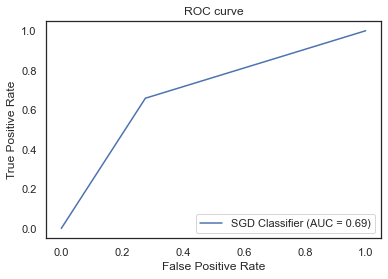

In [32]:
clf_results('SGD Classifier', model, X, y, X_train, y_train, X_test, y_test)

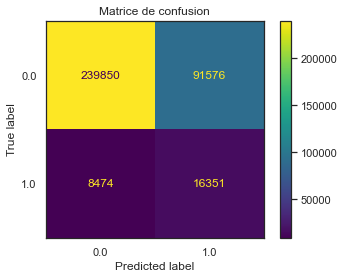

In [38]:
conf_mat_visu(model, X, y)